In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! git clone https://github.com/amirgholami/adahessian.git #original, if we want to modify something need to replace with a forked one

Cloning into 'adahessian'...
remote: Enumerating objects: 562, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 562 (delta 90), reused 164 (delta 84), pack-reused 387
Receiving objects: 100% (562/562), 2.00 MiB | 5.72 MiB/s, done.
Resolving deltas: 100% (202/202), done.


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Opti-ML') #to access other files
sys.path.insert(0,"adahessian/image_classification/")
#import os
#assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
#if try to use tpu in colab
#!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

In [ ]:
# Useful starting lines
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.model_selection import KFold
#import torch_xla
#import torch_xla.core.xla_model as xm

from optimizer import set_parameter_requires_grad, initialize_model, train_and_test, test_model
from optim_adahessian import Adahessian

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# classic dataset CIFAR10
train_data=datasets.CIFAR10(root='data',train=True,download=True,transform=ToTensor())
test_data=datasets.CIFAR10(root='data',train=False,download=True,transform=ToTensor())

100%|██████████| 170498071/170498071 [00:05<00:00, 28985365.76it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
# Use a small subset of the data
# only error: 'Subset' object has no attribute 'targets'
if False: # put False if don't want it
  rng = np.random.default_rng()

  indices = rng.choice(len(train_data), 1000, replace=False)
  train_data = torch.utils.data.Subset(train_data, indices)

  indices = rng.choice(len(test_data), 200, replace=False)
  test_data = torch.utils.data.Subset(test_data, indices)

In [ ]:
print("train data of type:",type(train_data),"with length",len(train_data))
print("test data of type:",type(test_data),"with length",len(test_data))

train data of type: <class 'torchvision.datasets.cifar.CIFAR10'> with length 50000
test data of type: <class 'torchvision.datasets.cifar.CIFAR10'> with length 10000


In [ ]:
print("samples of type",type(train_data[0]),"with length",len(train_data[0]))
print("   - First entry: Image of type",type(train_data[0][0]),"and size",train_data[0][0].size())
print("   - Second entry: Label of type",type(train_data[0][1]))
print("The first sample:\n",train_data[0])

samples of type <class 'tuple'> with length 2
   - First entry: Image of type <class 'torch.Tensor'> and size torch.Size([3, 32, 32])
   - Second entry: Label of type <class 'int'>
The first sample:
 (tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627

In [ ]:
labels=np.unique(np.array(train_data.targets)) #check labels
print(labels)

[0 1 2 3 4 5 6 7 8 9]


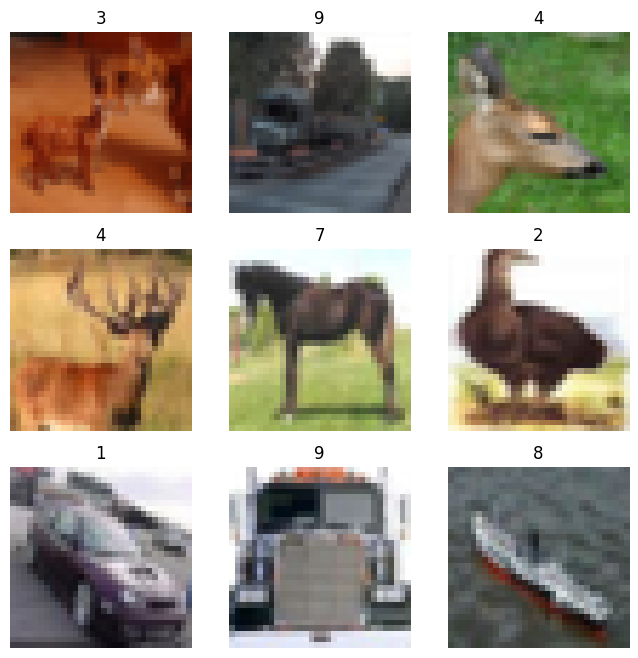

In [ ]:
#visualize
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()

### Here we use the same seed for the same random initialization for dataloader and model weights. So that the comparisons are more rigorous.


In [ ]:
batch_size = 256
seed = 100
k_folds = 5
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
#trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
kfold = KFold(n_splits=k_folds, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

#device = xm.xla_device()

Using cuda device


In [ ]:
req_grad = True
use_pretrained=False
# Initialize the model for this run
model, input_size = initialize_model(use_pretrained=use_pretrained)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Send the model to GPU

model = model.to(device)
#print all the parameters that we are going to update
params_to_update = model.parameters()
print("Params to learn:")
if req_grad:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

[image_classification/optim_adahessian.py](https://github.com/amirgholami/adahessian/blob/master/image_classification/optim_adahessian.py) on github:


```
"""Implements Adahessian algorithm.
    It has been proposed in `ADAHESSIAN: An Adaptive Second Order Optimizer for Machine Learning`.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 0.15)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-4)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        hessian_power (float, optional): Hessian power (default: 1). You can also try 0.5. For some tasks we found this to result in better performance.
        single_gpu (Bool, optional): Do you use distributed training or not "torch.nn.parallel.DistributedDataParallel" (default: True)
    """
```
- hessian_power is the "$k$"
- the weight decay is something like 0.1,...,0.0001
- below are definitions of parameters


In [ ]:
lr=0.005 # default: 0.15
betas = (0.9, 0.999) # default: (0.9, 0.999)
weight_decay = 0.0005 # default: 0
hessian_power = 1 # default: 1
num_epoch = 360
momentum = 0.95

#optimizer_name = 'adahessian'
optimizer_name = 'SGD'

if optimizer_name == 'adahessian':
  optimizer = Adahessian(params_to_update, lr=lr, betas=betas, weight_decay=weight_decay,hessian_power=hessian_power) #set the parameter
elif optimizer_name == 'SGD':
  optimizer = optim.SGD(params_to_update, lr=lr, momentum=momentum, weight_decay=weight_decay)
elif optimizer_name == "adam":
  optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

scheduler_name = "multilr"
scheduler = None
if scheduler_name == "multilr":
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[180, 270], gamma=0.1)

path='./drive/MyDrive/Opti-ML/model_weights/model_0615_sgd2'
train_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/train_loss_0615_2.txt'
train_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/train_acc_0615_2.txt'
val_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/val_loss_0615_2.txt'
val_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/val_acc_0615_2.txt'

### Run the training and kfold-validation process. Save the loss and accuracies.

In [ ]:
best_k, train_loss, val_loss, train_acc, val_acc=train_and_test(model,train_data,batch_size,kfold,criterion,optimizer_name,scheduler,num_epoch,path,use_pretrained,lr,betas,momentum,weight_decay,hessian_power,device)
with open(train_loss_path, 'w') as fp:
    for item in train_loss:
        # write each item on a new line
        fp.write("%s\n" % item)
with open(train_acc_path, 'w') as fp:
    for item in train_acc:
        # write each item on a new line
        fp.write("%s\n" % item)
with open(val_loss_path, 'w') as fp:
    for item in val_loss:
        # write each item on a new line
        fp.write("%s\n" % item)
with open(val_acc_path, 'w') as fp:
    for item in val_acc:
        # write each item on a new line
        fp.write("%s\n" % item)

FOLD 0
--------------------------------


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch 0/359
----------


/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train Loss: 1.3255
Validation Loss: 1.3375


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|          | 1/360 [00:33<3:20:27, 33.50s/it]

Train accuracy: 0.4346
Validation accuracy: 0.4251
Epoch 1/359
----------
Train Loss: 0.9989
Validation Loss: 1.3157


  1%|          | 2/360 [00:59<2:54:11, 29.19s/it]

Train accuracy: 0.4664
Validation accuracy: 0.4361
Epoch 2/359
----------
Train Loss: 0.8272
Validation Loss: 0.9261


  1%|          | 3/360 [01:25<2:45:22, 27.79s/it]

Train accuracy: 0.6749
Validation accuracy: 0.5920
Epoch 3/359
----------
Train Loss: 0.7046
Validation Loss: 1.1044


  1%|          | 4/360 [01:51<2:41:00, 27.14s/it]

Train accuracy: 0.6209
Validation accuracy: 0.5460
Epoch 4/359
----------
Train Loss: 0.5964
Validation Loss: 0.9033


  1%|▏         | 5/360 [02:17<2:37:56, 26.70s/it]

Train accuracy: 0.7568
Validation accuracy: 0.6298
Epoch 5/359
----------
Train Loss: 0.4924
Validation Loss: 0.9555


  2%|▏         | 6/360 [02:43<2:36:11, 26.47s/it]

Train accuracy: 0.7893
Validation accuracy: 0.6197
Epoch 6/359
----------
Train Loss: 0.4097
Validation Loss: 1.2431


  2%|▏         | 7/360 [03:09<2:34:43, 26.30s/it]

Train accuracy: 0.7099
Validation accuracy: 0.5663
Epoch 7/359
----------
Train Loss: 0.3385
Validation Loss: 1.5041


  2%|▏         | 8/360 [03:35<2:33:33, 26.18s/it]

Train accuracy: 0.6938
Validation accuracy: 0.5454
Epoch 8/359
----------
Train Loss: 0.2763
Validation Loss: 1.3664


  2%|▎         | 9/360 [04:01<2:32:56, 26.14s/it]

Train accuracy: 0.7782
Validation accuracy: 0.5925
Epoch 9/359
----------
Train Loss: 0.2370
Validation Loss: 1.2531


  3%|▎         | 10/360 [04:27<2:32:23, 26.13s/it]

Train accuracy: 0.8439
Validation accuracy: 0.6246
Epoch 10/359
----------
Train Loss: 0.1871
Validation Loss: 1.2198


  3%|▎         | 11/360 [04:53<2:31:43, 26.08s/it]

Train accuracy: 0.8706
Validation accuracy: 0.6202
Epoch 11/359
----------
Train Loss: 0.1609
Validation Loss: 1.2899


  3%|▎         | 12/360 [05:19<2:30:49, 26.00s/it]

Train accuracy: 0.9006
Validation accuracy: 0.6368
Epoch 12/359
----------
Train Loss: 0.1359
Validation Loss: 1.2521


  4%|▎         | 13/360 [05:45<2:30:35, 26.04s/it]

Train accuracy: 0.9177
Validation accuracy: 0.6389
Epoch 13/359
----------
Train Loss: 0.1087
Validation Loss: 1.3742


  4%|▍         | 14/360 [06:11<2:29:46, 25.97s/it]

Train accuracy: 0.9146
Validation accuracy: 0.6374
Epoch 14/359
----------
Train Loss: 0.1186
Validation Loss: 1.2909


  4%|▍         | 15/360 [06:37<2:28:54, 25.90s/it]

Train accuracy: 0.9361
Validation accuracy: 0.6585
Epoch 15/359
----------
Train Loss: 0.0911
Validation Loss: 1.2393


  4%|▍         | 16/360 [07:03<2:28:22, 25.88s/it]

Train accuracy: 0.9701
Validation accuracy: 0.6667
Epoch 16/359
----------
Train Loss: 0.0750
Validation Loss: 1.4444


  5%|▍         | 17/360 [07:28<2:27:39, 25.83s/it]

Train accuracy: 0.9301
Validation accuracy: 0.6441
Epoch 17/359
----------
Train Loss: 0.0603
Validation Loss: 1.3245


  5%|▌         | 18/360 [07:54<2:27:28, 25.87s/it]

Train accuracy: 0.9749
Validation accuracy: 0.6811
Epoch 18/359
----------
Train Loss: 0.0752
Validation Loss: 1.3454


  5%|▌         | 19/360 [08:20<2:26:37, 25.80s/it]

Train accuracy: 0.9715
Validation accuracy: 0.6740
Epoch 19/359
----------
Train Loss: 0.0753
Validation Loss: 1.3860


  6%|▌         | 20/360 [08:46<2:26:19, 25.82s/it]

Train accuracy: 0.9578
Validation accuracy: 0.6705
Epoch 20/359
----------
Train Loss: 0.0540
Validation Loss: 1.3225


  6%|▌         | 21/360 [09:12<2:25:44, 25.80s/it]

Train accuracy: 0.9768
Validation accuracy: 0.6753
Epoch 21/359
----------
Train Loss: 0.0345
Validation Loss: 1.4099


  6%|▌         | 22/360 [09:38<2:25:27, 25.82s/it]

Train accuracy: 0.9733
Validation accuracy: 0.6751
Epoch 22/359
----------
Train Loss: 0.0279
Validation Loss: 1.4228


  6%|▋         | 23/360 [10:03<2:25:07, 25.84s/it]

Train accuracy: 0.9830
Validation accuracy: 0.6800
Epoch 23/359
----------
Train Loss: 0.0258
Validation Loss: 1.3865


  7%|▋         | 24/360 [10:29<2:24:23, 25.78s/it]

Train accuracy: 0.9932
Validation accuracy: 0.6891
Epoch 24/359
----------
Train Loss: 0.0212
Validation Loss: 1.4714


  7%|▋         | 25/360 [10:55<2:23:59, 25.79s/it]

Train accuracy: 0.9805
Validation accuracy: 0.6811
Epoch 25/359
----------
Train Loss: 0.0339
Validation Loss: 1.4424


  7%|▋         | 26/360 [11:21<2:23:40, 25.81s/it]

Train accuracy: 0.9832
Validation accuracy: 0.6838
Epoch 26/359
----------
Train Loss: 0.0437
Validation Loss: 1.3702


  8%|▊         | 27/360 [11:47<2:23:15, 25.81s/it]

Train accuracy: 0.9865
Validation accuracy: 0.6897
Epoch 27/359
----------
Train Loss: 0.0488
Validation Loss: 1.3505


  8%|▊         | 28/360 [12:13<2:23:07, 25.86s/it]

Train accuracy: 0.9877
Validation accuracy: 0.6876
Epoch 28/359
----------
Train Loss: 0.0308
Validation Loss: 1.4237


  8%|▊         | 29/360 [12:39<2:22:58, 25.92s/it]

Train accuracy: 0.9829
Validation accuracy: 0.6819
Epoch 29/359
----------
Train Loss: 0.0270
Validation Loss: 1.4281


  8%|▊         | 30/360 [13:05<2:22:44, 25.95s/it]

Train accuracy: 0.9878
Validation accuracy: 0.6838
Epoch 30/359
----------
Train Loss: 0.0271
Validation Loss: 1.5155


  9%|▊         | 31/360 [13:30<2:21:49, 25.86s/it]

Train accuracy: 0.9776
Validation accuracy: 0.6698
Epoch 31/359
----------
Train Loss: 0.0257
Validation Loss: 1.5228


  9%|▉         | 32/360 [13:56<2:21:27, 25.88s/it]

Train accuracy: 0.9791
Validation accuracy: 0.6817
Epoch 32/359
----------
Train Loss: 0.0290
Validation Loss: 1.4645


  9%|▉         | 33/360 [14:22<2:20:41, 25.82s/it]

Train accuracy: 0.9852
Validation accuracy: 0.6872
Epoch 33/359
----------
Train Loss: 0.0259
Validation Loss: 1.4259


  9%|▉         | 34/360 [14:48<2:20:20, 25.83s/it]

Train accuracy: 0.9901
Validation accuracy: 0.6855
Epoch 34/359
----------
Train Loss: 0.0329
Validation Loss: 1.4282


 10%|▉         | 35/360 [15:14<2:20:29, 25.94s/it]

Train accuracy: 0.9883
Validation accuracy: 0.6841
Epoch 35/359
----------
Train Loss: 0.0295
Validation Loss: 1.4298


 10%|█         | 36/360 [15:40<2:20:57, 26.10s/it]

Train accuracy: 0.9872
Validation accuracy: 0.6848
Epoch 36/359
----------
Train Loss: 0.0275
Validation Loss: 1.4458


 10%|█         | 37/360 [16:06<2:20:21, 26.07s/it]

Train accuracy: 0.9870
Validation accuracy: 0.6877
Epoch 37/359
----------
Train Loss: 0.0281
Validation Loss: 1.4410


 11%|█         | 38/360 [16:33<2:20:19, 26.15s/it]

Train accuracy: 0.9869
Validation accuracy: 0.6905
Epoch 38/359
----------
Train Loss: 0.0232
Validation Loss: 1.4276


 11%|█         | 39/360 [16:59<2:20:43, 26.30s/it]

Train accuracy: 0.9879
Validation accuracy: 0.6876
Epoch 39/359
----------
Train Loss: 0.0214
Validation Loss: 1.4069


 11%|█         | 40/360 [17:25<2:19:58, 26.24s/it]

Train accuracy: 0.9936
Validation accuracy: 0.6889
Epoch 40/359
----------
Train Loss: 0.0198
Validation Loss: 1.4248


 11%|█▏        | 41/360 [17:52<2:19:36, 26.26s/it]

Train accuracy: 0.9919
Validation accuracy: 0.6891
Epoch 41/359
----------
Train Loss: 0.0331
Validation Loss: 1.4874


 12%|█▏        | 42/360 [18:18<2:19:15, 26.27s/it]

Train accuracy: 0.9838
Validation accuracy: 0.6745
Epoch 42/359
----------
Train Loss: 0.0319
Validation Loss: 1.4040


 12%|█▏        | 43/360 [18:45<2:19:15, 26.36s/it]

Train accuracy: 0.9905
Validation accuracy: 0.6908
Epoch 43/359
----------
Train Loss: 0.0230
Validation Loss: 1.4190


 12%|█▏        | 44/360 [19:11<2:18:57, 26.38s/it]

Train accuracy: 0.9910
Validation accuracy: 0.6936
Epoch 44/359
----------
Train Loss: 0.0165
Validation Loss: 1.3839


 12%|█▎        | 45/360 [19:37<2:17:47, 26.25s/it]

Train accuracy: 0.9968
Validation accuracy: 0.6981
Epoch 45/359
----------
Train Loss: 0.0152
Validation Loss: 1.3968


 13%|█▎        | 46/360 [20:03<2:16:56, 26.17s/it]

Train accuracy: 0.9947
Validation accuracy: 0.6975
Epoch 46/359
----------
Train Loss: 0.0095
Validation Loss: 1.4090


 13%|█▎        | 47/360 [20:29<2:16:04, 26.08s/it]

Train accuracy: 0.9973
Validation accuracy: 0.6918
Epoch 47/359
----------
Train Loss: 0.0086
Validation Loss: 1.3990


 13%|█▎        | 48/360 [20:55<2:15:49, 26.12s/it]

Train accuracy: 0.9975
Validation accuracy: 0.7004
Epoch 48/359
----------
Train Loss: 0.0073
Validation Loss: 1.3604


 14%|█▎        | 49/360 [21:21<2:15:05, 26.06s/it]

Train accuracy: 0.9977
Validation accuracy: 0.7050
Epoch 49/359
----------
Train Loss: 0.0043
Validation Loss: 1.3491


 14%|█▍        | 50/360 [21:47<2:15:18, 26.19s/it]

Train accuracy: 0.9998
Validation accuracy: 0.7068
Epoch 50/359
----------
Train Loss: 0.0015
Validation Loss: 1.3144


 14%|█▍        | 51/360 [22:14<2:14:51, 26.19s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7132
Epoch 51/359
----------
Train Loss: 0.0010
Validation Loss: 1.2957


 14%|█▍        | 52/360 [22:40<2:14:29, 26.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7178
Epoch 52/359
----------
Train Loss: 0.0003
Validation Loss: 1.2769


 15%|█▍        | 53/360 [23:06<2:14:07, 26.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7184
Epoch 53/359
----------
Train Loss: 0.0002
Validation Loss: 1.2581


 15%|█▌        | 54/360 [23:32<2:13:50, 26.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7216
Epoch 54/359
----------
Train Loss: 0.0002
Validation Loss: 1.2480


 15%|█▌        | 55/360 [23:59<2:13:33, 26.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7214
Epoch 55/359
----------
Train Loss: 0.0002
Validation Loss: 1.2392


 16%|█▌        | 56/360 [24:25<2:12:37, 26.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7206
Epoch 56/359
----------
Train Loss: 0.0002
Validation Loss: 1.2219


 16%|█▌        | 57/360 [24:51<2:12:15, 26.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7223
Epoch 57/359
----------
Train Loss: 0.0002
Validation Loss: 1.2093


 16%|█▌        | 58/360 [25:17<2:11:15, 26.08s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7229
Epoch 58/359
----------
Train Loss: 0.0002
Validation Loss: 1.2037


 16%|█▋        | 59/360 [25:43<2:10:52, 26.09s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7209
Epoch 59/359
----------
Train Loss: 0.0002
Validation Loss: 1.1847


 17%|█▋        | 60/360 [26:09<2:10:24, 26.08s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7231
Epoch 60/359
----------
Train Loss: 0.0002
Validation Loss: 1.1861


 17%|█▋        | 61/360 [26:35<2:10:05, 26.11s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7241
Epoch 61/359
----------
Train Loss: 0.0002
Validation Loss: 1.1743


 17%|█▋        | 62/360 [27:01<2:09:53, 26.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7232
Epoch 62/359
----------
Train Loss: 0.0002
Validation Loss: 1.1642


 18%|█▊        | 63/360 [27:28<2:09:32, 26.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7223
Epoch 63/359
----------
Train Loss: 0.0003
Validation Loss: 1.1576


 18%|█▊        | 64/360 [27:54<2:09:10, 26.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7235
Epoch 64/359
----------
Train Loss: 0.0003
Validation Loss: 1.1491


 18%|█▊        | 65/360 [28:20<2:08:44, 26.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7210
Epoch 65/359
----------
Train Loss: 0.0035
Validation Loss: 1.2039


 18%|█▊        | 66/360 [28:46<2:08:30, 26.23s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7115
Epoch 66/359
----------
Train Loss: 0.0008
Validation Loss: 1.1701


 19%|█▊        | 67/360 [29:12<2:07:56, 26.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7211
Epoch 67/359
----------
Train Loss: 0.0004
Validation Loss: 1.1516


 19%|█▉        | 68/360 [29:39<2:07:44, 26.25s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7225
Epoch 68/359
----------
Train Loss: 0.0003
Validation Loss: 1.1463


 19%|█▉        | 69/360 [30:05<2:07:23, 26.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7217
Epoch 69/359
----------
Train Loss: 0.0003
Validation Loss: 1.1334


 19%|█▉        | 70/360 [30:32<2:07:07, 26.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7230
Epoch 70/359
----------
Train Loss: 0.0003
Validation Loss: 1.1257


 20%|█▉        | 71/360 [30:58<2:06:30, 26.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7229
Epoch 71/359
----------
Train Loss: 0.0002
Validation Loss: 1.1185


 20%|██        | 72/360 [31:24<2:06:19, 26.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7230
Epoch 72/359
----------
Train Loss: 0.0002
Validation Loss: 1.1039


 20%|██        | 73/360 [31:50<2:05:52, 26.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7240
Epoch 73/359
----------
Train Loss: 0.0002
Validation Loss: 1.1008


 21%|██        | 74/360 [32:17<2:05:29, 26.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7239
Epoch 74/359
----------
Train Loss: 0.0002
Validation Loss: 1.0922


 21%|██        | 75/360 [32:43<2:04:56, 26.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7249
Epoch 75/359
----------
Train Loss: 0.0003
Validation Loss: 1.0877


 21%|██        | 76/360 [33:09<2:04:19, 26.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7232
Epoch 76/359
----------
Train Loss: 0.0003
Validation Loss: 1.0750


 21%|██▏       | 77/360 [33:36<2:03:56, 26.28s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7241
Epoch 77/359
----------
Train Loss: 0.0003
Validation Loss: 1.0711


 22%|██▏       | 78/360 [34:02<2:03:35, 26.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7235
Epoch 78/359
----------
Train Loss: 0.0003
Validation Loss: 1.0662


 22%|██▏       | 79/360 [34:29<2:03:52, 26.45s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7233
Epoch 79/359
----------
Train Loss: 0.0003
Validation Loss: 1.0588


 22%|██▏       | 80/360 [34:55<2:03:30, 26.47s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7236
Epoch 80/359
----------
Train Loss: 0.0003
Validation Loss: 1.0589


 22%|██▎       | 81/360 [35:22<2:02:58, 26.45s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7222
Epoch 81/359
----------
Train Loss: 0.0003
Validation Loss: 1.0511


 23%|██▎       | 82/360 [35:48<2:02:31, 26.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7256
Epoch 82/359
----------
Train Loss: 0.0003
Validation Loss: 1.0450


 23%|██▎       | 83/360 [36:14<2:01:35, 26.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7232
Epoch 83/359
----------
Train Loss: 0.0003
Validation Loss: 1.0419


 23%|██▎       | 84/360 [36:41<2:01:17, 26.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7232
Epoch 84/359
----------
Train Loss: 0.0003
Validation Loss: 1.0331


 24%|██▎       | 85/360 [37:06<2:00:16, 26.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7244
Epoch 85/359
----------
Train Loss: 0.0003
Validation Loss: 1.0354


 24%|██▍       | 86/360 [37:32<1:59:20, 26.13s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7256
Epoch 86/359
----------
Train Loss: 0.0003
Validation Loss: 1.0312


 24%|██▍       | 87/360 [37:58<1:58:41, 26.09s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7225
Epoch 87/359
----------
Train Loss: 0.0003
Validation Loss: 1.0237


 24%|██▍       | 88/360 [38:25<1:58:37, 26.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7252
Epoch 88/359
----------
Train Loss: 0.0003
Validation Loss: 1.0221


 25%|██▍       | 89/360 [38:51<1:58:18, 26.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7228
Epoch 89/359
----------
Train Loss: 0.0003
Validation Loss: 1.0167


 25%|██▌       | 90/360 [39:17<1:57:54, 26.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7245
Epoch 90/359
----------
Train Loss: 0.0003
Validation Loss: 1.0117


 25%|██▌       | 91/360 [39:43<1:57:27, 26.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7241
Epoch 91/359
----------
Train Loss: 0.0003
Validation Loss: 1.0126


 26%|██▌       | 92/360 [40:10<1:57:30, 26.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7254
Epoch 92/359
----------
Train Loss: 0.0003
Validation Loss: 1.0050


 26%|██▌       | 93/360 [40:36<1:57:18, 26.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7251
Epoch 93/359
----------
Train Loss: 0.0003
Validation Loss: 1.0041


 26%|██▌       | 94/360 [41:03<1:56:52, 26.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7236
Epoch 94/359
----------
Train Loss: 0.0003
Validation Loss: 0.9973


 26%|██▋       | 95/360 [41:29<1:56:29, 26.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7225
Epoch 95/359
----------
Train Loss: 0.0003
Validation Loss: 0.9971


 27%|██▋       | 96/360 [41:56<1:56:23, 26.45s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7251
Epoch 96/359
----------
Train Loss: 0.0003
Validation Loss: 0.9929


 27%|██▋       | 97/360 [42:22<1:56:09, 26.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7259
Epoch 97/359
----------
Train Loss: 0.0003
Validation Loss: 0.9912


 27%|██▋       | 98/360 [42:49<1:55:37, 26.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7230
Epoch 98/359
----------
Train Loss: 0.0003
Validation Loss: 0.9892


 28%|██▊       | 99/360 [43:16<1:55:23, 26.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7246
Epoch 99/359
----------
Train Loss: 0.0003
Validation Loss: 0.9883


 28%|██▊       | 100/360 [43:42<1:55:07, 26.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7258
Epoch 100/359
----------
Train Loss: 0.0004
Validation Loss: 0.9843


 28%|██▊       | 101/360 [44:08<1:54:15, 26.47s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7254
Epoch 101/359
----------
Train Loss: 0.0004
Validation Loss: 0.9807


 28%|██▊       | 102/360 [44:35<1:53:38, 26.43s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7247
Epoch 102/359
----------
Train Loss: 0.0004
Validation Loss: 0.9802


 29%|██▊       | 103/360 [45:01<1:53:10, 26.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7239
Epoch 103/359
----------
Train Loss: 0.0004
Validation Loss: 0.9787


 29%|██▉       | 104/360 [45:28<1:52:42, 26.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7256
Epoch 104/359
----------
Train Loss: 0.0004
Validation Loss: 0.9809


 29%|██▉       | 105/360 [45:54<1:52:10, 26.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7241
Epoch 105/359
----------
Train Loss: 0.0004
Validation Loss: 0.9766


 29%|██▉       | 106/360 [46:20<1:51:47, 26.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7256
Epoch 106/359
----------
Train Loss: 0.0004
Validation Loss: 0.9698


 30%|██▉       | 107/360 [46:47<1:51:10, 26.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7242
Epoch 107/359
----------
Train Loss: 0.0004
Validation Loss: 0.9737


 30%|███       | 108/360 [47:13<1:50:54, 26.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7255
Epoch 108/359
----------
Train Loss: 0.0004
Validation Loss: 0.9735


 30%|███       | 109/360 [47:40<1:50:32, 26.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7253
Epoch 109/359
----------
Train Loss: 0.0004
Validation Loss: 0.9716


 31%|███       | 110/360 [48:06<1:49:37, 26.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7232
Epoch 110/359
----------
Train Loss: 0.0004
Validation Loss: 0.9705


 31%|███       | 111/360 [48:32<1:49:03, 26.28s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7246
Epoch 111/359
----------
Train Loss: 0.0004
Validation Loss: 0.9671


 31%|███       | 112/360 [48:58<1:48:17, 26.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7226
Epoch 112/359
----------
Train Loss: 0.0004
Validation Loss: 0.9681


 31%|███▏      | 113/360 [49:24<1:47:18, 26.07s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7251
Epoch 113/359
----------
Train Loss: 0.0004
Validation Loss: 0.9615


 32%|███▏      | 114/360 [49:50<1:46:41, 26.02s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7242
Epoch 114/359
----------
Train Loss: 0.0004
Validation Loss: 0.9684


 32%|███▏      | 115/360 [50:16<1:46:17, 26.03s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7236
Epoch 115/359
----------
Train Loss: 0.0004
Validation Loss: 0.9682


 32%|███▏      | 116/360 [50:41<1:45:32, 25.95s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7235
Epoch 116/359
----------
Train Loss: 0.0004
Validation Loss: 0.9601


 32%|███▎      | 117/360 [51:07<1:44:55, 25.91s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7239
Epoch 117/359
----------
Train Loss: 0.0004
Validation Loss: 0.9615


 33%|███▎      | 118/360 [51:33<1:44:29, 25.91s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7233
Epoch 118/359
----------
Train Loss: 0.0004
Validation Loss: 0.9628


 33%|███▎      | 119/360 [51:59<1:43:51, 25.86s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7235
Epoch 119/359
----------
Train Loss: 0.0004
Validation Loss: 0.9615


 33%|███▎      | 120/360 [52:25<1:43:36, 25.90s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7254
Epoch 120/359
----------
Train Loss: 0.0004
Validation Loss: 0.9637


 34%|███▎      | 121/360 [52:51<1:43:00, 25.86s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7245
Epoch 121/359
----------
Train Loss: 0.0004
Validation Loss: 0.9590


 34%|███▍      | 122/360 [53:16<1:42:29, 25.84s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7223
Epoch 122/359
----------
Train Loss: 0.0004
Validation Loss: 0.9623


 34%|███▍      | 123/360 [53:42<1:41:40, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7227
Epoch 123/359
----------
Train Loss: 0.0004
Validation Loss: 0.9589


 34%|███▍      | 124/360 [54:08<1:41:27, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7236
Epoch 124/359
----------
Train Loss: 0.0004
Validation Loss: 0.9596


 35%|███▍      | 125/360 [54:34<1:41:00, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7236
Epoch 125/359
----------
Train Loss: 0.0004
Validation Loss: 0.9598


 35%|███▌      | 126/360 [54:59<1:40:26, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7233
Epoch 126/359
----------
Train Loss: 0.0004
Validation Loss: 0.9592


 35%|███▌      | 127/360 [55:25<1:40:08, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7233
Epoch 127/359
----------
Train Loss: 0.0004
Validation Loss: 0.9608


 36%|███▌      | 128/360 [55:51<1:39:45, 25.80s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7237
Epoch 128/359
----------
Train Loss: 0.0004
Validation Loss: 0.9597


 36%|███▌      | 129/360 [56:17<1:39:27, 25.83s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7255
Epoch 129/359
----------
Train Loss: 0.0004
Validation Loss: 0.9584


 36%|███▌      | 130/360 [56:43<1:38:52, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7258
Epoch 130/359
----------
Train Loss: 0.0004
Validation Loss: 0.9541


 36%|███▋      | 131/360 [57:09<1:38:55, 25.92s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7260
Epoch 131/359
----------
Train Loss: 0.0004
Validation Loss: 0.9575


 37%|███▋      | 132/360 [57:35<1:38:35, 25.95s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7259
Epoch 132/359
----------
Train Loss: 0.0004
Validation Loss: 0.9594


 37%|███▋      | 133/360 [58:01<1:38:34, 26.05s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7248
Epoch 133/359
----------
Train Loss: 0.0004
Validation Loss: 0.9595


 37%|███▋      | 134/360 [58:27<1:38:28, 26.14s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7256
Epoch 134/359
----------
Train Loss: 0.0004
Validation Loss: 0.9626


 38%|███▊      | 135/360 [58:55<1:39:09, 26.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7229
Epoch 135/359
----------
Train Loss: 0.0004
Validation Loss: 0.9588


 38%|███▊      | 136/360 [59:22<1:39:41, 26.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7234
Epoch 136/359
----------
Train Loss: 0.0004
Validation Loss: 0.9590


 38%|███▊      | 137/360 [59:48<1:38:52, 26.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7249
Epoch 137/359
----------
Train Loss: 0.0846
Validation Loss: 2.3934


 38%|███▊      | 138/360 [1:00:14<1:37:54, 26.46s/it]

Train accuracy: 0.4272
Validation accuracy: 0.3839
Epoch 138/359
----------
Train Loss: 0.6551
Validation Loss: 0.8470


 39%|███▊      | 139/360 [1:00:40<1:36:54, 26.31s/it]

Train accuracy: 0.7624
Validation accuracy: 0.6447
Epoch 139/359
----------
Train Loss: 0.3748
Validation Loss: 0.9422


 39%|███▉      | 140/360 [1:01:07<1:36:24, 26.29s/it]

Train accuracy: 0.8024
Validation accuracy: 0.6350
Epoch 140/359
----------
Train Loss: 0.2714
Validation Loss: 0.8823


 39%|███▉      | 141/360 [1:01:33<1:35:57, 26.29s/it]

Train accuracy: 0.8836
Validation accuracy: 0.6744
Epoch 141/359
----------
Train Loss: 0.2077
Validation Loss: 0.9711


 39%|███▉      | 142/360 [1:01:59<1:35:16, 26.22s/it]

Train accuracy: 0.8897
Validation accuracy: 0.6736
Epoch 142/359
----------
Train Loss: 0.1722
Validation Loss: 1.0180


 40%|███▉      | 143/360 [1:02:25<1:34:46, 26.21s/it]

Train accuracy: 0.8935
Validation accuracy: 0.6682
Epoch 143/359
----------
Train Loss: 0.1262
Validation Loss: 0.9551


 40%|████      | 144/360 [1:02:51<1:34:19, 26.20s/it]

Train accuracy: 0.9589
Validation accuracy: 0.7044
Epoch 144/359
----------
Train Loss: 0.0937
Validation Loss: 1.0042


 40%|████      | 145/360 [1:03:17<1:33:49, 26.19s/it]

Train accuracy: 0.9526
Validation accuracy: 0.7013
Epoch 145/359
----------
Train Loss: 0.0866
Validation Loss: 1.0951


 41%|████      | 146/360 [1:03:44<1:33:17, 26.16s/it]

Train accuracy: 0.9307
Validation accuracy: 0.6803
Epoch 146/359
----------
Train Loss: 0.0830
Validation Loss: 1.0396


 41%|████      | 147/360 [1:04:10<1:33:16, 26.27s/it]

Train accuracy: 0.9514
Validation accuracy: 0.6972
Epoch 147/359
----------
Train Loss: 0.0619
Validation Loss: 1.0335


 41%|████      | 148/360 [1:04:36<1:32:42, 26.24s/it]

Train accuracy: 0.9773
Validation accuracy: 0.7137
Epoch 148/359
----------
Train Loss: 0.0584
Validation Loss: 1.0047


 41%|████▏     | 149/360 [1:05:03<1:32:46, 26.38s/it]

Train accuracy: 0.9811
Validation accuracy: 0.7200
Epoch 149/359
----------
Train Loss: 0.0458
Validation Loss: 1.0273


 42%|████▏     | 150/360 [1:05:29<1:32:17, 26.37s/it]

Train accuracy: 0.9886
Validation accuracy: 0.7278
Epoch 150/359
----------
Train Loss: 0.0316
Validation Loss: 1.0632


 42%|████▏     | 151/360 [1:05:56<1:31:49, 26.36s/it]

Train accuracy: 0.9831
Validation accuracy: 0.7164
Epoch 151/359
----------
Train Loss: 0.0329
Validation Loss: 1.1567


 42%|████▏     | 152/360 [1:06:22<1:31:18, 26.34s/it]

Train accuracy: 0.9673
Validation accuracy: 0.7068
Epoch 152/359
----------
Train Loss: 0.0265
Validation Loss: 1.1444


 42%|████▎     | 153/360 [1:06:48<1:30:41, 26.29s/it]

Train accuracy: 0.9777
Validation accuracy: 0.7119
Epoch 153/359
----------
Train Loss: 0.0291
Validation Loss: 1.0995


 43%|████▎     | 154/360 [1:07:14<1:29:57, 26.20s/it]

Train accuracy: 0.9846
Validation accuracy: 0.7161
Epoch 154/359
----------
Train Loss: 0.0338
Validation Loss: 1.1108


 43%|████▎     | 155/360 [1:07:40<1:29:11, 26.11s/it]

Train accuracy: 0.9854
Validation accuracy: 0.7156
Epoch 155/359
----------
Train Loss: 0.0360
Validation Loss: 1.0999


 43%|████▎     | 156/360 [1:08:06<1:28:31, 26.04s/it]

Train accuracy: 0.9872
Validation accuracy: 0.7209
Epoch 156/359
----------
Train Loss: 0.0293
Validation Loss: 1.1083


 44%|████▎     | 157/360 [1:08:32<1:27:50, 25.96s/it]

Train accuracy: 0.9885
Validation accuracy: 0.7147
Epoch 157/359
----------
Train Loss: 0.0308
Validation Loss: 1.0710


 44%|████▍     | 158/360 [1:08:57<1:27:10, 25.89s/it]

Train accuracy: 0.9857
Validation accuracy: 0.7240
Epoch 158/359
----------
Train Loss: 0.0428
Validation Loss: 1.0864


 44%|████▍     | 159/360 [1:09:23<1:26:35, 25.85s/it]

Train accuracy: 0.9845
Validation accuracy: 0.7180
Epoch 159/359
----------
Train Loss: 0.0270
Validation Loss: 1.0473


 44%|████▍     | 160/360 [1:09:49<1:25:53, 25.77s/it]

Train accuracy: 0.9938
Validation accuracy: 0.7305
Epoch 160/359
----------
Train Loss: 0.0141
Validation Loss: 1.0911


 45%|████▍     | 161/360 [1:10:14<1:25:28, 25.77s/it]

Train accuracy: 0.9961
Validation accuracy: 0.7249
Epoch 161/359
----------
Train Loss: 0.0108
Validation Loss: 1.0524


 45%|████▌     | 162/360 [1:10:40<1:24:53, 25.72s/it]

Train accuracy: 0.9979
Validation accuracy: 0.7355
Epoch 162/359
----------
Train Loss: 0.0079
Validation Loss: 1.1065


 45%|████▌     | 163/360 [1:11:06<1:24:25, 25.71s/it]

Train accuracy: 0.9925
Validation accuracy: 0.7280
Epoch 163/359
----------
Train Loss: 0.0047
Validation Loss: 1.0587


 46%|████▌     | 164/360 [1:11:31<1:23:51, 25.67s/it]

Train accuracy: 0.9993
Validation accuracy: 0.7438
Epoch 164/359
----------
Train Loss: 0.0060
Validation Loss: 1.0523


 46%|████▌     | 165/360 [1:11:57<1:23:36, 25.73s/it]

Train accuracy: 0.9992
Validation accuracy: 0.7431
Epoch 165/359
----------
Train Loss: 0.0076
Validation Loss: 1.0527


 46%|████▌     | 166/360 [1:12:23<1:23:26, 25.81s/it]

Train accuracy: 0.9982
Validation accuracy: 0.7379
Epoch 166/359
----------
Train Loss: 0.0035
Validation Loss: 1.0219


 46%|████▋     | 167/360 [1:12:49<1:23:08, 25.85s/it]

Train accuracy: 0.9998
Validation accuracy: 0.7490
Epoch 167/359
----------
Train Loss: 0.0018
Validation Loss: 1.0163


 47%|████▋     | 168/360 [1:13:15<1:22:56, 25.92s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7468
Epoch 168/359
----------
Train Loss: 0.0010
Validation Loss: 1.0050


 47%|████▋     | 169/360 [1:13:41<1:22:48, 26.01s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7497
Epoch 169/359
----------
Train Loss: 0.0008
Validation Loss: 0.9931


 47%|████▋     | 170/360 [1:14:08<1:22:48, 26.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7519
Epoch 170/359
----------
Train Loss: 0.0005
Validation Loss: 0.9879


 48%|████▊     | 171/360 [1:14:34<1:22:13, 26.10s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7543
Epoch 171/359
----------
Train Loss: 0.0003
Validation Loss: 0.9668


 48%|████▊     | 172/360 [1:15:00<1:21:50, 26.12s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7564
Epoch 172/359
----------
Train Loss: 0.0003
Validation Loss: 0.9546


 48%|████▊     | 173/360 [1:15:26<1:21:29, 26.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7566
Epoch 173/359
----------
Train Loss: 0.0003
Validation Loss: 0.9513


 48%|████▊     | 174/360 [1:15:52<1:20:51, 26.08s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7564
Epoch 174/359
----------
Train Loss: 0.0003
Validation Loss: 0.9394


 49%|████▊     | 175/360 [1:16:18<1:20:29, 26.10s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7553
Epoch 175/359
----------
Train Loss: 0.0003
Validation Loss: 0.9381


 49%|████▉     | 176/360 [1:16:44<1:19:55, 26.06s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7580
Epoch 176/359
----------
Train Loss: 0.0003
Validation Loss: 0.9325


 49%|████▉     | 177/360 [1:17:10<1:19:28, 26.06s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7541
Epoch 177/359
----------
Train Loss: 0.0003
Validation Loss: 0.9216


 49%|████▉     | 178/360 [1:17:37<1:19:08, 26.09s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7557
Epoch 178/359
----------
Train Loss: 0.0003
Validation Loss: 0.9107


 50%|████▉     | 179/360 [1:18:03<1:18:53, 26.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7579
Epoch 179/359
----------
Train Loss: 0.0003
Validation Loss: 0.9086


 50%|█████     | 180/360 [1:18:29<1:18:23, 26.13s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7572
Epoch 180/359
----------
Train Loss: 0.0003
Validation Loss: 0.9060


 50%|█████     | 181/360 [1:18:55<1:17:48, 26.08s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7572
Epoch 181/359
----------
Train Loss: 0.0003
Validation Loss: 0.9038


 51%|█████     | 182/360 [1:19:21<1:17:21, 26.07s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7562
Epoch 182/359
----------
Train Loss: 0.0003
Validation Loss: 0.8975


 51%|█████     | 183/360 [1:19:47<1:16:57, 26.09s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7590
Epoch 183/359
----------
Train Loss: 0.0003
Validation Loss: 0.8892


 51%|█████     | 184/360 [1:20:13<1:16:47, 26.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7573
Epoch 184/359
----------
Train Loss: 0.0004
Validation Loss: 0.8844


 51%|█████▏    | 185/360 [1:20:40<1:16:37, 26.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7579
Epoch 185/359
----------
Train Loss: 0.0004
Validation Loss: 0.8821


 52%|█████▏    | 186/360 [1:21:06<1:16:11, 26.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7581
Epoch 186/359
----------
Train Loss: 0.0004
Validation Loss: 0.8750


 52%|█████▏    | 187/360 [1:21:32<1:15:29, 26.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7587
Epoch 187/359
----------
Train Loss: 0.0004
Validation Loss: 0.8747


 52%|█████▏    | 188/360 [1:21:59<1:15:13, 26.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7592
Epoch 188/359
----------
Train Loss: 0.0004
Validation Loss: 0.8726


 52%|█████▎    | 189/360 [1:22:25<1:14:44, 26.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7590
Epoch 189/359
----------
Train Loss: 0.0004
Validation Loss: 0.8679


 53%|█████▎    | 190/360 [1:22:51<1:14:17, 26.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7587
Epoch 190/359
----------
Train Loss: 0.0004
Validation Loss: 0.8670


 53%|█████▎    | 191/360 [1:23:17<1:13:41, 26.16s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7591
Epoch 191/359
----------
Train Loss: 0.0004
Validation Loss: 0.8623


 53%|█████▎    | 192/360 [1:23:43<1:13:18, 26.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7595
Epoch 192/359
----------
Train Loss: 0.0004
Validation Loss: 0.8566


 54%|█████▎    | 193/360 [1:24:09<1:12:42, 26.12s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7589
Epoch 193/359
----------
Train Loss: 0.0004
Validation Loss: 0.8562


 54%|█████▍    | 194/360 [1:24:35<1:12:04, 26.05s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7579
Epoch 194/359
----------
Train Loss: 0.0004
Validation Loss: 0.8553


 54%|█████▍    | 195/360 [1:25:01<1:11:53, 26.14s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7593
Epoch 195/359
----------
Train Loss: 0.0004
Validation Loss: 0.8492


 54%|█████▍    | 196/360 [1:25:28<1:11:30, 26.16s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7600
Epoch 196/359
----------
Train Loss: 0.0004
Validation Loss: 0.8548


 55%|█████▍    | 197/360 [1:25:54<1:11:02, 26.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7577
Epoch 197/359
----------
Train Loss: 0.0004
Validation Loss: 0.8513


 55%|█████▌    | 198/360 [1:26:20<1:10:43, 26.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7571
Epoch 198/359
----------
Train Loss: 0.0004
Validation Loss: 0.8466


 55%|█████▌    | 199/360 [1:26:46<1:09:58, 26.08s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7591
Epoch 199/359
----------
Train Loss: 0.0004
Validation Loss: 0.8464


 56%|█████▌    | 200/360 [1:27:12<1:09:32, 26.08s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7591
Epoch 200/359
----------
Train Loss: 0.0005
Validation Loss: 0.8464


 56%|█████▌    | 201/360 [1:27:38<1:09:12, 26.11s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7582
Epoch 201/359
----------
Train Loss: 0.0005
Validation Loss: 0.8457


 56%|█████▌    | 202/360 [1:28:04<1:08:43, 26.10s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7580
Epoch 202/359
----------
Train Loss: 0.0005
Validation Loss: 0.8440


 56%|█████▋    | 203/360 [1:28:30<1:08:11, 26.06s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7586
Epoch 203/359
----------
Train Loss: 0.0005
Validation Loss: 0.8451


 57%|█████▋    | 204/360 [1:28:56<1:07:55, 26.13s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7585
Epoch 204/359
----------
Train Loss: 0.0005
Validation Loss: 0.8426


 57%|█████▋    | 205/360 [1:29:22<1:07:16, 26.04s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7584
Epoch 205/359
----------
Train Loss: 0.0005
Validation Loss: 0.8408


 57%|█████▋    | 206/360 [1:29:48<1:06:49, 26.04s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7591
Epoch 206/359
----------
Train Loss: 0.0005
Validation Loss: 0.8432


 57%|█████▊    | 207/360 [1:30:14<1:06:23, 26.04s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7583
Epoch 207/359
----------
Train Loss: 0.0005
Validation Loss: 0.8407


 58%|█████▊    | 208/360 [1:30:40<1:05:53, 26.01s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7589
Epoch 208/359
----------
Train Loss: 0.0005
Validation Loss: 0.8443


 58%|█████▊    | 209/360 [1:31:06<1:05:32, 26.04s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7589
Epoch 209/359
----------
Train Loss: 0.0005
Validation Loss: 0.8468


 58%|█████▊    | 210/360 [1:31:32<1:04:57, 25.98s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7571
Epoch 210/359
----------
Train Loss: 0.0005
Validation Loss: 0.8440


 59%|█████▊    | 211/360 [1:31:58<1:04:37, 26.02s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7589
Epoch 211/359
----------
Train Loss: 0.0005
Validation Loss: 0.8462


 59%|█████▉    | 212/360 [1:32:24<1:04:08, 26.00s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7585
Epoch 212/359
----------
Train Loss: 0.0005
Validation Loss: 0.8421


 59%|█████▉    | 213/360 [1:32:50<1:03:39, 25.98s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7588
Epoch 213/359
----------
Train Loss: 0.0005
Validation Loss: 0.8451


 59%|█████▉    | 214/360 [1:33:16<1:03:06, 25.94s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7573
Epoch 214/359
----------
Train Loss: 0.0005
Validation Loss: 0.8442


 60%|█████▉    | 215/360 [1:33:42<1:02:29, 25.86s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7584
Epoch 215/359
----------
Train Loss: 0.0005
Validation Loss: 0.8460


 60%|██████    | 216/360 [1:34:08<1:01:58, 25.82s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7593
Epoch 216/359
----------
Train Loss: 0.0005
Validation Loss: 0.8486


 60%|██████    | 217/360 [1:34:33<1:01:22, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7582
Epoch 217/359
----------
Train Loss: 0.0005
Validation Loss: 0.8500


 61%|██████    | 218/360 [1:34:59<1:00:49, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7585
Epoch 218/359
----------
Train Loss: 0.0005
Validation Loss: 0.8502


 61%|██████    | 219/360 [1:35:24<1:00:18, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7570
Epoch 219/359
----------
Train Loss: 0.0005
Validation Loss: 0.8475


 61%|██████    | 220/360 [1:35:50<1:00:07, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7582
Epoch 220/359
----------
Train Loss: 0.0005
Validation Loss: 0.8529


 61%|██████▏   | 221/360 [1:36:16<59:52, 25.84s/it]  

Train accuracy: 1.0000
Validation accuracy: 0.7575
Epoch 221/359
----------
Train Loss: 0.0005
Validation Loss: 0.8518


 62%|██████▏   | 222/360 [1:36:42<59:31, 25.88s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7565
Epoch 222/359
----------
Train Loss: 0.0005
Validation Loss: 0.8497


 62%|██████▏   | 223/360 [1:37:08<59:05, 25.88s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7575
Epoch 223/359
----------
Train Loss: 0.0005
Validation Loss: 0.8526


 62%|██████▏   | 224/360 [1:37:34<58:42, 25.90s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7572
Epoch 224/359
----------
Train Loss: 0.0005
Validation Loss: 0.8523


 62%|██████▎   | 225/360 [1:38:00<58:14, 25.88s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7592
Epoch 225/359
----------
Train Loss: 0.0005
Validation Loss: 0.8575


 63%|██████▎   | 226/360 [1:38:26<57:51, 25.91s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7574
Epoch 226/359
----------
Train Loss: 0.0005
Validation Loss: 0.8533


 63%|██████▎   | 227/360 [1:38:52<57:18, 25.85s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7571
Epoch 227/359
----------
Train Loss: 0.0005
Validation Loss: 0.8567


 63%|██████▎   | 228/360 [1:39:17<56:42, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7577
Epoch 228/359
----------
Train Loss: 0.0005
Validation Loss: 0.8570


 64%|██████▎   | 229/360 [1:39:43<56:19, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7562
Epoch 229/359
----------
Train Loss: 0.0005
Validation Loss: 0.8573


 64%|██████▍   | 230/360 [1:40:09<55:50, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7577
Epoch 230/359
----------
Train Loss: 0.0005
Validation Loss: 0.8595


 64%|██████▍   | 231/360 [1:40:35<55:24, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7561
Epoch 231/359
----------
Train Loss: 0.0005
Validation Loss: 0.8602


 64%|██████▍   | 232/360 [1:41:00<54:58, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7584
Epoch 232/359
----------
Train Loss: 0.0005
Validation Loss: 0.8613


 65%|██████▍   | 233/360 [1:41:26<54:39, 25.82s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7583
Epoch 233/359
----------
Train Loss: 0.0005
Validation Loss: 0.8658


 65%|██████▌   | 234/360 [1:41:52<54:07, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7582
Epoch 234/359
----------
Train Loss: 0.0006
Validation Loss: 0.8665


 65%|██████▌   | 235/360 [1:42:18<53:37, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7568
Epoch 235/359
----------
Train Loss: 0.0006
Validation Loss: 0.8685


 66%|██████▌   | 236/360 [1:42:43<53:11, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7570
Epoch 236/359
----------
Train Loss: 0.0006
Validation Loss: 0.8679


 66%|██████▌   | 237/360 [1:43:09<52:42, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7562
Epoch 237/359
----------
Train Loss: 0.0006
Validation Loss: 0.8742


 66%|██████▌   | 238/360 [1:43:35<52:17, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7574
Epoch 238/359
----------
Train Loss: 0.0006
Validation Loss: 0.8764


 66%|██████▋   | 239/360 [1:44:00<51:50, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7564
Epoch 239/359
----------
Train Loss: 0.0006
Validation Loss: 0.8727


 67%|██████▋   | 240/360 [1:44:26<51:25, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7560
Epoch 240/359
----------
Train Loss: 0.0006
Validation Loss: 0.8749


 67%|██████▋   | 241/360 [1:44:52<51:01, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7569
Epoch 241/359
----------
Train Loss: 0.0006
Validation Loss: 0.8727


 67%|██████▋   | 242/360 [1:45:18<50:34, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7574
Epoch 242/359
----------
Train Loss: 0.0006
Validation Loss: 0.8741


 68%|██████▊   | 243/360 [1:45:43<50:13, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7575
Epoch 243/359
----------
Train Loss: 0.0006
Validation Loss: 0.8805


 68%|██████▊   | 244/360 [1:46:09<49:40, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7551
Epoch 244/359
----------
Train Loss: 0.0006
Validation Loss: 0.8808


 68%|██████▊   | 245/360 [1:46:35<49:22, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7572
Epoch 245/359
----------
Train Loss: 0.0006
Validation Loss: 0.8799


 68%|██████▊   | 246/360 [1:47:00<48:48, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7555
Epoch 246/359
----------
Train Loss: 0.0007
Validation Loss: 0.8971


 69%|██████▊   | 247/360 [1:47:26<48:23, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7567
Epoch 247/359
----------
Train Loss: 0.0006
Validation Loss: 0.8881


 69%|██████▉   | 248/360 [1:47:52<48:03, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7595
Epoch 248/359
----------
Train Loss: 0.0006
Validation Loss: 0.8850


 69%|██████▉   | 249/360 [1:48:18<47:37, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7572
Epoch 249/359
----------
Train Loss: 0.0006
Validation Loss: 0.8938


 69%|██████▉   | 250/360 [1:48:43<47:06, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7557
Epoch 250/359
----------
Train Loss: 0.4547
Validation Loss: 0.7648


 70%|██████▉   | 251/360 [1:49:09<46:36, 25.66s/it]

Train accuracy: 0.7678
Validation accuracy: 0.6796
Epoch 251/359
----------
Train Loss: 0.4265
Validation Loss: 0.7564


 70%|███████   | 252/360 [1:49:35<46:15, 25.70s/it]

Train accuracy: 0.8528
Validation accuracy: 0.6940
Epoch 252/359
----------
Train Loss: 0.2780
Validation Loss: 0.8381


 70%|███████   | 253/360 [1:50:00<45:52, 25.73s/it]

Train accuracy: 0.8748
Validation accuracy: 0.6839
Epoch 253/359
----------
Train Loss: 0.1881
Validation Loss: 0.8770


 71%|███████   | 254/360 [1:50:26<45:25, 25.71s/it]

Train accuracy: 0.9083
Validation accuracy: 0.6988
Epoch 254/359
----------
Train Loss: 0.1494
Validation Loss: 0.8861


 71%|███████   | 255/360 [1:50:51<44:47, 25.59s/it]

Train accuracy: 0.9250
Validation accuracy: 0.7001
Epoch 255/359
----------
Train Loss: 0.1175
Validation Loss: 0.8750


 71%|███████   | 256/360 [1:51:17<44:17, 25.55s/it]

Train accuracy: 0.9572
Validation accuracy: 0.7221
Epoch 256/359
----------
Train Loss: 0.0947
Validation Loss: 1.0078


 71%|███████▏  | 257/360 [1:51:42<43:49, 25.53s/it]

Train accuracy: 0.9266
Validation accuracy: 0.6940
Epoch 257/359
----------
Train Loss: 0.0774
Validation Loss: 1.0880


 72%|███████▏  | 258/360 [1:52:08<43:27, 25.56s/it]

Train accuracy: 0.9123
Validation accuracy: 0.6831
Epoch 258/359
----------
Train Loss: 0.0532
Validation Loss: 0.9274


 72%|███████▏  | 259/360 [1:52:34<43:02, 25.57s/it]

Train accuracy: 0.9784
Validation accuracy: 0.7319
Epoch 259/359
----------
Train Loss: 0.0426
Validation Loss: 0.8871


 72%|███████▏  | 260/360 [1:52:59<42:34, 25.55s/it]

Train accuracy: 0.9890
Validation accuracy: 0.7420
Epoch 260/359
----------
Train Loss: 0.0314
Validation Loss: 0.9217


 72%|███████▎  | 261/360 [1:53:25<42:14, 25.60s/it]

Train accuracy: 0.9915
Validation accuracy: 0.7410
Epoch 261/359
----------
Train Loss: 0.0259
Validation Loss: 0.9614


 73%|███████▎  | 262/360 [1:53:50<41:44, 25.55s/it]

Train accuracy: 0.9906
Validation accuracy: 0.7331
Epoch 262/359
----------
Train Loss: 0.0367
Validation Loss: 1.0471


 73%|███████▎  | 263/360 [1:54:16<41:20, 25.57s/it]

Train accuracy: 0.9695
Validation accuracy: 0.7208
Epoch 263/359
----------
Train Loss: 0.0505
Validation Loss: 1.0458


 73%|███████▎  | 264/360 [1:54:41<40:56, 25.59s/it]

Train accuracy: 0.9689
Validation accuracy: 0.7196
Epoch 264/359
----------
Train Loss: 0.0435
Validation Loss: 0.9655


 74%|███████▎  | 265/360 [1:55:07<40:26, 25.55s/it]

Train accuracy: 0.9861
Validation accuracy: 0.7323
Epoch 265/359
----------
Train Loss: 0.0345
Validation Loss: 0.9306


 74%|███████▍  | 266/360 [1:55:32<39:56, 25.49s/it]

Train accuracy: 0.9889
Validation accuracy: 0.7380
Epoch 266/359
----------
Train Loss: 0.0188
Validation Loss: 0.9073


 74%|███████▍  | 267/360 [1:55:58<39:35, 25.54s/it]

Train accuracy: 0.9973
Validation accuracy: 0.7521
Epoch 267/359
----------
Train Loss: 0.0121
Validation Loss: 0.9334


 74%|███████▍  | 268/360 [1:56:24<39:12, 25.57s/it]

Train accuracy: 0.9970
Validation accuracy: 0.7481
Epoch 268/359
----------
Train Loss: 0.0098
Validation Loss: 0.9446


 75%|███████▍  | 269/360 [1:56:49<38:46, 25.57s/it]

Train accuracy: 0.9977
Validation accuracy: 0.7453
Epoch 269/359
----------
Train Loss: 0.0064
Validation Loss: 0.9533


 75%|███████▌  | 270/360 [1:57:15<38:31, 25.68s/it]

Train accuracy: 0.9991
Validation accuracy: 0.7554
Epoch 270/359
----------
Train Loss: 0.0061
Validation Loss: 0.9582


 75%|███████▌  | 271/360 [1:57:41<38:08, 25.71s/it]

Train accuracy: 0.9983
Validation accuracy: 0.7521
Epoch 271/359
----------
Train Loss: 0.0065
Validation Loss: 0.9690


 76%|███████▌  | 272/360 [1:58:07<37:43, 25.72s/it]

Train accuracy: 0.9990
Validation accuracy: 0.7525
Epoch 272/359
----------
Train Loss: 0.0041
Validation Loss: 0.9369


 76%|███████▌  | 273/360 [1:58:32<37:16, 25.71s/it]

Train accuracy: 0.9997
Validation accuracy: 0.7569
Epoch 273/359
----------
Train Loss: 0.0028
Validation Loss: 0.9317


 76%|███████▌  | 274/360 [1:58:58<36:51, 25.72s/it]

Train accuracy: 0.9998
Validation accuracy: 0.7583
Epoch 274/359
----------
Train Loss: 0.0019
Validation Loss: 0.9264


 76%|███████▋  | 275/360 [1:59:24<36:20, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7559
Epoch 275/359
----------
Train Loss: 0.0007
Validation Loss: 0.8969


 77%|███████▋  | 276/360 [1:59:49<35:57, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7640
Epoch 276/359
----------
Train Loss: 0.0005
Validation Loss: 0.8847


 77%|███████▋  | 277/360 [2:00:15<35:35, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7672
Epoch 277/359
----------
Train Loss: 0.0004
Validation Loss: 0.8753


 77%|███████▋  | 278/360 [2:00:41<35:10, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7700
Epoch 278/359
----------
Train Loss: 0.0004
Validation Loss: 0.8713


 78%|███████▊  | 279/360 [2:01:07<34:43, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7680
Epoch 279/359
----------
Train Loss: 0.0004
Validation Loss: 0.8609


 78%|███████▊  | 280/360 [2:01:32<34:17, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7684
Epoch 280/359
----------
Train Loss: 0.0004
Validation Loss: 0.8552


 78%|███████▊  | 281/360 [2:01:58<33:50, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7699
Epoch 281/359
----------
Train Loss: 0.0004
Validation Loss: 0.8513


 78%|███████▊  | 282/360 [2:02:24<33:22, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7685
Epoch 282/359
----------
Train Loss: 0.0004
Validation Loss: 0.8456


 79%|███████▊  | 283/360 [2:02:49<32:58, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7697
Epoch 283/359
----------
Train Loss: 0.0004
Validation Loss: 0.8395


 79%|███████▉  | 284/360 [2:03:15<32:42, 25.82s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7692
Epoch 284/359
----------
Train Loss: 0.0004
Validation Loss: 0.8374


 79%|███████▉  | 285/360 [2:03:42<32:39, 26.13s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7704
Epoch 285/359
----------
Train Loss: 0.0005
Validation Loss: 0.8253


 79%|███████▉  | 286/360 [2:04:09<32:33, 26.40s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7692
Epoch 286/359
----------
Train Loss: 0.0004
Validation Loss: 0.8231


 80%|███████▉  | 287/360 [2:04:36<32:08, 26.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7704
Epoch 287/359
----------
Train Loss: 0.0005
Validation Loss: 0.8216


 80%|████████  | 288/360 [2:05:03<31:49, 26.52s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7709
Epoch 288/359
----------
Train Loss: 0.0005
Validation Loss: 0.8169


 80%|████████  | 289/360 [2:05:30<31:35, 26.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7709
Epoch 289/359
----------
Train Loss: 0.0005
Validation Loss: 0.8153


 81%|████████  | 290/360 [2:05:57<31:12, 26.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7708
Epoch 290/359
----------
Train Loss: 0.0005
Validation Loss: 0.8108


 81%|████████  | 291/360 [2:06:23<30:47, 26.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7715
Epoch 291/359
----------
Train Loss: 0.0005
Validation Loss: 0.8102


 81%|████████  | 292/360 [2:06:51<30:41, 27.09s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7718
Epoch 292/359
----------
Train Loss: 0.0005
Validation Loss: 0.8044


 81%|████████▏ | 293/360 [2:07:19<30:29, 27.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7716
Epoch 293/359
----------
Train Loss: 0.0005
Validation Loss: 0.8027


 82%|████████▏ | 294/360 [2:07:46<29:51, 27.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7717
Epoch 294/359
----------
Train Loss: 0.0005
Validation Loss: 0.8051


 82%|████████▏ | 295/360 [2:08:12<29:16, 27.02s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7714
Epoch 295/359
----------
Train Loss: 0.0006
Validation Loss: 0.8020


 82%|████████▏ | 296/360 [2:08:39<28:38, 26.85s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7697
Epoch 296/359
----------
Train Loss: 0.0006
Validation Loss: 0.7990


 82%|████████▎ | 297/360 [2:09:06<28:16, 26.93s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7708
Epoch 297/359
----------
Train Loss: 0.0006
Validation Loss: 0.7956


 83%|████████▎ | 298/360 [2:09:33<27:48, 26.90s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7726
Epoch 298/359
----------
Train Loss: 0.0006
Validation Loss: 0.7916


 83%|████████▎ | 299/360 [2:09:59<27:11, 26.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7728
Epoch 299/359
----------
Train Loss: 0.0006
Validation Loss: 0.7955


 83%|████████▎ | 300/360 [2:10:26<26:37, 26.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7708
Epoch 300/359
----------
Train Loss: 0.0006
Validation Loss: 0.7937


 84%|████████▎ | 301/360 [2:10:52<26:03, 26.51s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7735
Epoch 301/359
----------
Train Loss: 0.0006
Validation Loss: 0.7938


 84%|████████▍ | 302/360 [2:11:18<25:30, 26.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7732
Epoch 302/359
----------
Train Loss: 0.0006
Validation Loss: 0.7926


 84%|████████▍ | 303/360 [2:11:44<25:03, 26.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7722
Epoch 303/359
----------
Train Loss: 0.0006
Validation Loss: 0.7904


 84%|████████▍ | 304/360 [2:12:11<24:45, 26.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7722
Epoch 304/359
----------
Train Loss: 0.0006
Validation Loss: 0.7883


 85%|████████▍ | 305/360 [2:12:38<24:18, 26.52s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7735
Epoch 305/359
----------
Train Loss: 0.0006
Validation Loss: 0.7894


 85%|████████▌ | 306/360 [2:13:05<23:58, 26.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7758
Epoch 306/359
----------
Train Loss: 0.0006
Validation Loss: 0.7920


 85%|████████▌ | 307/360 [2:13:31<23:29, 26.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7734
Epoch 307/359
----------
Train Loss: 0.0006
Validation Loss: 0.7901


 86%|████████▌ | 308/360 [2:13:58<23:03, 26.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7729
Epoch 308/359
----------
Train Loss: 0.0007
Validation Loss: 0.7891


 86%|████████▌ | 309/360 [2:14:24<22:26, 26.40s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7733
Epoch 309/359
----------
Train Loss: 0.0007
Validation Loss: 0.7900


 86%|████████▌ | 310/360 [2:14:50<21:52, 26.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7737
Epoch 310/359
----------
Train Loss: 0.0007
Validation Loss: 0.7906


 86%|████████▋ | 311/360 [2:15:15<21:18, 26.08s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7725
Epoch 311/359
----------
Train Loss: 0.0007
Validation Loss: 0.7950


 87%|████████▋ | 312/360 [2:15:41<20:48, 26.00s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7729
Epoch 312/359
----------
Train Loss: 0.0007
Validation Loss: 0.7932


 87%|████████▋ | 313/360 [2:16:07<20:22, 26.01s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7734
Epoch 313/359
----------
Train Loss: 0.0007
Validation Loss: 0.7955


 87%|████████▋ | 314/360 [2:16:33<19:54, 25.98s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7738
Epoch 314/359
----------
Train Loss: 0.0015
Validation Loss: 0.8861


 88%|████████▊ | 315/360 [2:16:59<19:27, 25.95s/it]

Train accuracy: 0.9994
Validation accuracy: 0.7455
Epoch 315/359
----------
Train Loss: 0.0754
Validation Loss: 1.0913


 88%|████████▊ | 316/360 [2:17:25<19:03, 25.98s/it]

Train accuracy: 0.8238
Validation accuracy: 0.6414
Epoch 316/359
----------
Train Loss: 0.2385
Validation Loss: 0.9339


 88%|████████▊ | 317/360 [2:17:51<18:40, 26.07s/it]

Train accuracy: 0.8738
Validation accuracy: 0.6775
Epoch 317/359
----------
Train Loss: 0.1310
Validation Loss: 0.9365


 88%|████████▊ | 318/360 [2:18:17<18:15, 26.09s/it]

Train accuracy: 0.9344
Validation accuracy: 0.7024
Epoch 318/359
----------
Train Loss: 0.1027
Validation Loss: 0.8789


 89%|████████▊ | 319/360 [2:18:43<17:47, 26.03s/it]

Train accuracy: 0.9555
Validation accuracy: 0.7229
Epoch 319/359
----------
Train Loss: 0.0587
Validation Loss: 0.9094


 89%|████████▉ | 320/360 [2:19:09<17:17, 25.95s/it]

Train accuracy: 0.9743
Validation accuracy: 0.7250
Epoch 320/359
----------
Train Loss: 0.0459
Validation Loss: 0.8826


 89%|████████▉ | 321/360 [2:19:34<16:45, 25.78s/it]

Train accuracy: 0.9845
Validation accuracy: 0.7370
Epoch 321/359
----------
Train Loss: 0.0417
Validation Loss: 0.9251


 89%|████████▉ | 322/360 [2:20:00<16:20, 25.81s/it]

Train accuracy: 0.9883
Validation accuracy: 0.7350
Epoch 322/359
----------
Train Loss: 0.0350
Validation Loss: 0.9572


 90%|████████▉ | 323/360 [2:20:27<16:00, 25.97s/it]

Train accuracy: 0.9782
Validation accuracy: 0.7254
Epoch 323/359
----------
Train Loss: 0.0408
Validation Loss: 1.0563


 90%|█████████ | 324/360 [2:20:53<15:41, 26.15s/it]

Train accuracy: 0.9438
Validation accuracy: 0.7073
Epoch 324/359
----------
Train Loss: 0.0355
Validation Loss: 0.9734


 90%|█████████ | 325/360 [2:21:19<15:09, 25.99s/it]

Train accuracy: 0.9834
Validation accuracy: 0.7279
Epoch 325/359
----------
Train Loss: 0.0370
Validation Loss: 0.9280


 91%|█████████ | 326/360 [2:21:45<14:42, 25.96s/it]

Train accuracy: 0.9861
Validation accuracy: 0.7402
Epoch 326/359
----------
Train Loss: 0.0279
Validation Loss: 0.9067


 91%|█████████ | 327/360 [2:22:10<14:13, 25.87s/it]

Train accuracy: 0.9947
Validation accuracy: 0.7511
Epoch 327/359
----------
Train Loss: 0.0189
Validation Loss: 0.9515


 91%|█████████ | 328/360 [2:22:36<13:50, 25.95s/it]

Train accuracy: 0.9898
Validation accuracy: 0.7402
Epoch 328/359
----------
Train Loss: 0.0129
Validation Loss: 0.9073


 91%|█████████▏| 329/360 [2:23:02<13:23, 25.92s/it]

Train accuracy: 0.9984
Validation accuracy: 0.7549
Epoch 329/359
----------
Train Loss: 0.0083
Validation Loss: 0.9305


 92%|█████████▏| 330/360 [2:23:28<12:56, 25.89s/it]

Train accuracy: 0.9977
Validation accuracy: 0.7551
Epoch 330/359
----------
Train Loss: 0.0048
Validation Loss: 0.9026


 92%|█████████▏| 331/360 [2:23:54<12:29, 25.83s/it]

Train accuracy: 0.9994
Validation accuracy: 0.7619
Epoch 331/359
----------
Train Loss: 0.0055
Validation Loss: 0.9265


 92%|█████████▏| 332/360 [2:24:20<12:02, 25.82s/it]

Train accuracy: 0.9989
Validation accuracy: 0.7589
Epoch 332/359
----------
Train Loss: 0.0075
Validation Loss: 0.9892


 92%|█████████▎| 333/360 [2:24:46<11:37, 25.85s/it]

Train accuracy: 0.9949
Validation accuracy: 0.7471
Epoch 333/359
----------
Train Loss: 0.0085
Validation Loss: 0.9781


 93%|█████████▎| 334/360 [2:25:11<11:10, 25.81s/it]

Train accuracy: 0.9946
Validation accuracy: 0.7513
Epoch 334/359
----------
Train Loss: 0.0275
Validation Loss: 0.9919


 93%|█████████▎| 335/360 [2:25:37<10:46, 25.85s/it]

Train accuracy: 0.9871
Validation accuracy: 0.7340
Epoch 335/359
----------
Train Loss: 0.0325
Validation Loss: 1.1002


 93%|█████████▎| 336/360 [2:26:03<10:20, 25.84s/it]

Train accuracy: 0.9624
Validation accuracy: 0.7116
Epoch 336/359
----------
Train Loss: 0.0392
Validation Loss: 0.9584


 94%|█████████▎| 337/360 [2:26:29<09:53, 25.80s/it]

Train accuracy: 0.9820
Validation accuracy: 0.7388
Epoch 337/359
----------
Train Loss: 0.0206
Validation Loss: 1.0053


 94%|█████████▍| 338/360 [2:26:55<09:27, 25.82s/it]

Train accuracy: 0.9845
Validation accuracy: 0.7350
Epoch 338/359
----------
Train Loss: 0.0229
Validation Loss: 0.9754


 94%|█████████▍| 339/360 [2:27:20<09:01, 25.79s/it]

Train accuracy: 0.9888
Validation accuracy: 0.7317
Epoch 339/359
----------
Train Loss: 0.0150
Validation Loss: 1.0404


 94%|█████████▍| 340/360 [2:27:46<08:36, 25.83s/it]

Train accuracy: 0.9841
Validation accuracy: 0.7286
Epoch 340/359
----------
Train Loss: 0.0125
Validation Loss: 0.9367


 95%|█████████▍| 341/360 [2:28:12<08:10, 25.83s/it]

Train accuracy: 0.9973
Validation accuracy: 0.7477
Epoch 341/359
----------
Train Loss: 0.0124
Validation Loss: 0.9498


 95%|█████████▌| 342/360 [2:28:38<07:45, 25.84s/it]

Train accuracy: 0.9969
Validation accuracy: 0.7499
Epoch 342/359
----------
Train Loss: 0.0092
Validation Loss: 1.0149


 95%|█████████▌| 343/360 [2:29:04<07:18, 25.81s/it]

Train accuracy: 0.9906
Validation accuracy: 0.7376
Epoch 343/359
----------
Train Loss: 0.0123
Validation Loss: 0.9635


 96%|█████████▌| 344/360 [2:29:29<06:53, 25.82s/it]

Train accuracy: 0.9962
Validation accuracy: 0.7488
Epoch 344/359
----------
Train Loss: 0.0097
Validation Loss: 0.9541


 96%|█████████▌| 345/360 [2:29:55<06:27, 25.81s/it]

Train accuracy: 0.9982
Validation accuracy: 0.7530
Epoch 345/359
----------
Train Loss: 0.0131
Validation Loss: 0.9733


 96%|█████████▌| 346/360 [2:30:21<06:00, 25.76s/it]

Train accuracy: 0.9953
Validation accuracy: 0.7490
Epoch 346/359
----------
Train Loss: 0.0185
Validation Loss: 0.9703


 96%|█████████▋| 347/360 [2:30:47<05:34, 25.75s/it]

Train accuracy: 0.9937
Validation accuracy: 0.7449
Epoch 347/359
----------
Train Loss: 0.0202
Validation Loss: 1.0046


 97%|█████████▋| 348/360 [2:31:12<05:09, 25.77s/it]

Train accuracy: 0.9923
Validation accuracy: 0.7397
Epoch 348/359
----------
Train Loss: 0.0305
Validation Loss: 0.9694


 97%|█████████▋| 349/360 [2:31:38<04:43, 25.77s/it]

Train accuracy: 0.9897
Validation accuracy: 0.7416
Epoch 349/359
----------
Train Loss: 0.0305
Validation Loss: 0.9884


 97%|█████████▋| 350/360 [2:32:04<04:17, 25.79s/it]

Train accuracy: 0.9814
Validation accuracy: 0.7305
Epoch 350/359
----------
Train Loss: 0.0266
Validation Loss: 0.9555


 98%|█████████▊| 351/360 [2:32:30<03:53, 25.91s/it]

Train accuracy: 0.9948
Validation accuracy: 0.7448
Epoch 351/359
----------
Train Loss: 0.0180
Validation Loss: 1.0030


 98%|█████████▊| 352/360 [2:32:56<03:27, 25.95s/it]

Train accuracy: 0.9875
Validation accuracy: 0.7408
Epoch 352/359
----------
Train Loss: 0.0160
Validation Loss: 0.9530


 98%|█████████▊| 353/360 [2:33:22<03:01, 25.96s/it]

Train accuracy: 0.9969
Validation accuracy: 0.7462
Epoch 353/359
----------
Train Loss: 0.0117
Validation Loss: 0.9728


 98%|█████████▊| 354/360 [2:33:49<02:36, 26.06s/it]

Train accuracy: 0.9929
Validation accuracy: 0.7436
Epoch 354/359
----------
Train Loss: 0.0175
Validation Loss: 1.0077


 99%|█████████▊| 355/360 [2:34:15<02:10, 26.07s/it]

Train accuracy: 0.9915
Validation accuracy: 0.7344
Epoch 355/359
----------
Train Loss: 0.0096
Validation Loss: 0.9848


 99%|█████████▉| 356/360 [2:34:41<01:44, 26.06s/it]

Train accuracy: 0.9948
Validation accuracy: 0.7418
Epoch 356/359
----------
Train Loss: 0.0142
Validation Loss: 0.9621


 99%|█████████▉| 357/360 [2:35:07<01:18, 26.05s/it]

Train accuracy: 0.9947
Validation accuracy: 0.7482
Epoch 357/359
----------
Train Loss: 0.0089
Validation Loss: 0.9583


 99%|█████████▉| 358/360 [2:35:33<00:52, 26.08s/it]

Train accuracy: 0.9984
Validation accuracy: 0.7521
Epoch 358/359
----------
Train Loss: 0.0043
Validation Loss: 0.9390


100%|█████████▉| 359/360 [2:35:59<00:26, 26.03s/it]

Train accuracy: 0.9997
Validation accuracy: 0.7549
Epoch 359/359
----------
Train Loss: 0.0028
Validation Loss: 0.9298


100%|██████████| 360/360 [2:36:25<00:00, 26.07s/it]


Train accuracy: 1.0000
Validation accuracy: 0.7632
FOLD 1
--------------------------------


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch 0/359
----------
Train Loss: 1.3193
Validation Loss: 1.1308


  0%|          | 1/360 [00:26<2:35:35, 26.00s/it]

Train accuracy: 0.5225
Validation accuracy: 0.4944
Epoch 1/359
----------
Train Loss: 0.9887
Validation Loss: 1.0391


  1%|          | 2/360 [00:52<2:35:13, 26.01s/it]

Train accuracy: 0.5902
Validation accuracy: 0.5397
Epoch 2/359
----------
Train Loss: 0.8341
Validation Loss: 1.1543


  1%|          | 3/360 [01:17<2:34:34, 25.98s/it]

Train accuracy: 0.5736
Validation accuracy: 0.5068
Epoch 3/359
----------
Train Loss: 0.7092
Validation Loss: 0.8695


  1%|          | 4/360 [01:43<2:33:48, 25.92s/it]

Train accuracy: 0.7393
Validation accuracy: 0.6267
Epoch 4/359
----------
Train Loss: 0.5872
Validation Loss: 0.9657


  1%|▏         | 5/360 [02:09<2:32:53, 25.84s/it]

Train accuracy: 0.7326
Validation accuracy: 0.6116
Epoch 5/359
----------
Train Loss: 0.4853
Validation Loss: 1.0778


  2%|▏         | 6/360 [02:35<2:32:13, 25.80s/it]

Train accuracy: 0.7523
Validation accuracy: 0.6031
Epoch 6/359
----------
Train Loss: 0.4059
Validation Loss: 1.1672


  2%|▏         | 7/360 [03:00<2:31:30, 25.75s/it]

Train accuracy: 0.7412
Validation accuracy: 0.5733
Epoch 7/359
----------
Train Loss: 0.3251
Validation Loss: 0.9659


  2%|▏         | 8/360 [03:26<2:30:44, 25.70s/it]

Train accuracy: 0.8658
Validation accuracy: 0.6393
Epoch 8/359
----------
Train Loss: 0.2662
Validation Loss: 1.1021


  2%|▎         | 9/360 [03:52<2:30:31, 25.73s/it]

Train accuracy: 0.8803
Validation accuracy: 0.6356
Epoch 9/359
----------
Train Loss: 0.2196
Validation Loss: 1.1527


  3%|▎         | 10/360 [04:17<2:30:04, 25.73s/it]

Train accuracy: 0.8878
Validation accuracy: 0.6349
Epoch 10/359
----------
Train Loss: 0.1888
Validation Loss: 1.1618


  3%|▎         | 11/360 [04:43<2:29:11, 25.65s/it]

Train accuracy: 0.9025
Validation accuracy: 0.6364
Epoch 11/359
----------
Train Loss: 0.1592
Validation Loss: 1.2590


  3%|▎         | 12/360 [05:09<2:28:41, 25.64s/it]

Train accuracy: 0.9029
Validation accuracy: 0.6457
Epoch 12/359
----------
Train Loss: 0.1163
Validation Loss: 1.1796


  4%|▎         | 13/360 [05:34<2:28:11, 25.62s/it]

Train accuracy: 0.9616
Validation accuracy: 0.6675
Epoch 13/359
----------
Train Loss: 0.0958
Validation Loss: 1.3194


  4%|▍         | 14/360 [06:00<2:27:38, 25.60s/it]

Train accuracy: 0.9499
Validation accuracy: 0.6527
Epoch 14/359
----------
Train Loss: 0.0894
Validation Loss: 1.3069


  4%|▍         | 15/360 [06:25<2:27:09, 25.59s/it]

Train accuracy: 0.9634
Validation accuracy: 0.6658
Epoch 15/359
----------
Train Loss: 0.0765
Validation Loss: 1.3520


  4%|▍         | 16/360 [06:51<2:26:58, 25.64s/it]

Train accuracy: 0.9595
Validation accuracy: 0.6657
Epoch 16/359
----------
Train Loss: 0.0884
Validation Loss: 1.3401


  5%|▍         | 17/360 [07:17<2:26:25, 25.62s/it]

Train accuracy: 0.9573
Validation accuracy: 0.6640
Epoch 17/359
----------
Train Loss: 0.0713
Validation Loss: 1.3225


  5%|▌         | 18/360 [07:42<2:26:12, 25.65s/it]

Train accuracy: 0.9603
Validation accuracy: 0.6600
Epoch 18/359
----------
Train Loss: 0.0675
Validation Loss: 1.4061


  5%|▌         | 19/360 [08:08<2:25:45, 25.65s/it]

Train accuracy: 0.9571
Validation accuracy: 0.6645
Epoch 19/359
----------
Train Loss: 0.0598
Validation Loss: 1.4375


  6%|▌         | 20/360 [08:33<2:25:07, 25.61s/it]

Train accuracy: 0.9668
Validation accuracy: 0.6664
Epoch 20/359
----------
Train Loss: 0.0476
Validation Loss: 1.4094


  6%|▌         | 21/360 [08:59<2:24:47, 25.63s/it]

Train accuracy: 0.9792
Validation accuracy: 0.6762
Epoch 21/359
----------
Train Loss: 0.0556
Validation Loss: 1.4304


  6%|▌         | 22/360 [09:25<2:24:22, 25.63s/it]

Train accuracy: 0.9661
Validation accuracy: 0.6699
Epoch 22/359
----------
Train Loss: 0.0462
Validation Loss: 1.3541


  6%|▋         | 23/360 [09:50<2:24:01, 25.64s/it]

Train accuracy: 0.9875
Validation accuracy: 0.6867
Epoch 23/359
----------
Train Loss: 0.0291
Validation Loss: 1.5034


  7%|▋         | 24/360 [10:16<2:23:10, 25.57s/it]

Train accuracy: 0.9586
Validation accuracy: 0.6678
Epoch 24/359
----------
Train Loss: 0.0269
Validation Loss: 1.4830


  7%|▋         | 25/360 [10:42<2:23:04, 25.63s/it]

Train accuracy: 0.9779
Validation accuracy: 0.6769
Epoch 25/359
----------
Train Loss: 0.0234
Validation Loss: 1.4612


  7%|▋         | 26/360 [11:07<2:22:42, 25.64s/it]

Train accuracy: 0.9881
Validation accuracy: 0.6852
Epoch 26/359
----------
Train Loss: 0.0196
Validation Loss: 1.4028


  8%|▊         | 27/360 [11:33<2:22:15, 25.63s/it]

Train accuracy: 0.9942
Validation accuracy: 0.6893
Epoch 27/359
----------
Train Loss: 0.0137
Validation Loss: 1.4439


  8%|▊         | 28/360 [11:59<2:22:05, 25.68s/it]

Train accuracy: 0.9907
Validation accuracy: 0.6856
Epoch 28/359
----------
Train Loss: 0.0152
Validation Loss: 1.4564


  8%|▊         | 29/360 [12:24<2:21:34, 25.66s/it]

Train accuracy: 0.9935
Validation accuracy: 0.6907
Epoch 29/359
----------
Train Loss: 0.0106
Validation Loss: 1.4689


  8%|▊         | 30/360 [12:50<2:21:07, 25.66s/it]

Train accuracy: 0.9931
Validation accuracy: 0.6882
Epoch 30/359
----------
Train Loss: 0.0151
Validation Loss: 1.5151


  9%|▊         | 31/360 [13:16<2:20:44, 25.67s/it]

Train accuracy: 0.9900
Validation accuracy: 0.6842
Epoch 31/359
----------
Train Loss: 0.0162
Validation Loss: 1.5705


  9%|▉         | 32/360 [13:41<2:20:28, 25.70s/it]

Train accuracy: 0.9820
Validation accuracy: 0.6789
Epoch 32/359
----------
Train Loss: 0.0220
Validation Loss: 1.6321


  9%|▉         | 33/360 [14:07<2:19:33, 25.61s/it]

Train accuracy: 0.9694
Validation accuracy: 0.6675
Epoch 33/359
----------
Train Loss: 0.0363
Validation Loss: 1.4963


  9%|▉         | 34/360 [14:33<2:19:19, 25.64s/it]

Train accuracy: 0.9824
Validation accuracy: 0.6784
Epoch 34/359
----------
Train Loss: 0.0590
Validation Loss: 1.4390


 10%|▉         | 35/360 [14:58<2:19:02, 25.67s/it]

Train accuracy: 0.9656
Validation accuracy: 0.6728
Epoch 35/359
----------
Train Loss: 0.0651
Validation Loss: 1.3587


 10%|█         | 36/360 [15:24<2:18:36, 25.67s/it]

Train accuracy: 0.9706
Validation accuracy: 0.6731
Epoch 36/359
----------
Train Loss: 0.0700
Validation Loss: 1.3058


 10%|█         | 37/360 [15:50<2:18:18, 25.69s/it]

Train accuracy: 0.9834
Validation accuracy: 0.6788
Epoch 37/359
----------
Train Loss: 0.0323
Validation Loss: 1.3667


 11%|█         | 38/360 [16:15<2:17:49, 25.68s/it]

Train accuracy: 0.9900
Validation accuracy: 0.6840
Epoch 38/359
----------
Train Loss: 0.0167
Validation Loss: 1.3258


 11%|█         | 39/360 [16:41<2:17:30, 25.70s/it]

Train accuracy: 0.9973
Validation accuracy: 0.6940
Epoch 39/359
----------
Train Loss: 0.0093
Validation Loss: 1.3496


 11%|█         | 40/360 [17:07<2:17:01, 25.69s/it]

Train accuracy: 0.9981
Validation accuracy: 0.6965
Epoch 40/359
----------
Train Loss: 0.0049
Validation Loss: 1.3069


 11%|█▏        | 41/360 [17:33<2:17:08, 25.80s/it]

Train accuracy: 0.9990
Validation accuracy: 0.6998
Epoch 41/359
----------
Train Loss: 0.0024
Validation Loss: 1.3002


 12%|█▏        | 42/360 [17:58<2:16:22, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7115
Epoch 42/359
----------
Train Loss: 0.0012
Validation Loss: 1.2775


 12%|█▏        | 43/360 [18:24<2:15:59, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7110
Epoch 43/359
----------
Train Loss: 0.0006
Validation Loss: 1.2582


 12%|█▏        | 44/360 [18:50<2:15:41, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7181
Epoch 44/359
----------
Train Loss: 0.0005
Validation Loss: 1.2425


 12%|█▎        | 45/360 [19:16<2:15:09, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7180
Epoch 45/359
----------
Train Loss: 0.0003
Validation Loss: 1.2276


 13%|█▎        | 46/360 [19:41<2:14:27, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7195
Epoch 46/359
----------
Train Loss: 0.0003
Validation Loss: 1.2225


 13%|█▎        | 47/360 [20:07<2:14:13, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7186
Epoch 47/359
----------
Train Loss: 0.0003
Validation Loss: 1.2084


 13%|█▎        | 48/360 [20:33<2:13:28, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7180
Epoch 48/359
----------
Train Loss: 0.0002
Validation Loss: 1.2008


 14%|█▎        | 49/360 [20:58<2:12:56, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7198
Epoch 49/359
----------
Train Loss: 0.0002
Validation Loss: 1.1962


 14%|█▍        | 50/360 [21:24<2:12:34, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7195
Epoch 50/359
----------
Train Loss: 0.0002
Validation Loss: 1.1813


 14%|█▍        | 51/360 [21:49<2:12:00, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7208
Epoch 51/359
----------
Train Loss: 0.0002
Validation Loss: 1.1776


 14%|█▍        | 52/360 [22:15<2:11:47, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7205
Epoch 52/359
----------
Train Loss: 0.0002
Validation Loss: 1.1718


 15%|█▍        | 53/360 [22:41<2:11:25, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7195
Epoch 53/359
----------
Train Loss: 0.0003
Validation Loss: 1.1633


 15%|█▌        | 54/360 [23:07<2:11:11, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7193
Epoch 54/359
----------
Train Loss: 0.0003
Validation Loss: 1.1576


 15%|█▌        | 55/360 [23:32<2:10:45, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7190
Epoch 55/359
----------
Train Loss: 0.0002
Validation Loss: 1.1484


 16%|█▌        | 56/360 [23:58<2:10:16, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7203
Epoch 56/359
----------
Train Loss: 0.0003
Validation Loss: 1.1413


 16%|█▌        | 57/360 [24:24<2:09:28, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7199
Epoch 57/359
----------
Train Loss: 0.0003
Validation Loss: 1.1285


 16%|█▌        | 58/360 [24:49<2:09:12, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7229
Epoch 58/359
----------
Train Loss: 0.0003
Validation Loss: 1.1235


 16%|█▋        | 59/360 [25:15<2:09:00, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7208
Epoch 59/359
----------
Train Loss: 0.0003
Validation Loss: 1.1195


 17%|█▋        | 60/360 [25:41<2:08:31, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7209
Epoch 60/359
----------
Train Loss: 0.0003
Validation Loss: 1.1047


 17%|█▋        | 61/360 [26:06<2:07:55, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7214
Epoch 61/359
----------
Train Loss: 0.0003
Validation Loss: 1.1070


 17%|█▋        | 62/360 [26:32<2:07:09, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7184
Epoch 62/359
----------
Train Loss: 0.0003
Validation Loss: 1.1009


 18%|█▊        | 63/360 [26:57<2:06:45, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7222
Epoch 63/359
----------
Train Loss: 0.0003
Validation Loss: 1.0900


 18%|█▊        | 64/360 [27:23<2:06:14, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7210
Epoch 64/359
----------
Train Loss: 0.0003
Validation Loss: 1.0861


 18%|█▊        | 65/360 [27:49<2:06:10, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7210
Epoch 65/359
----------
Train Loss: 0.0003
Validation Loss: 1.0776


 18%|█▊        | 66/360 [28:14<2:05:38, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7215
Epoch 66/359
----------
Train Loss: 0.0003
Validation Loss: 1.0758


 19%|█▊        | 67/360 [28:40<2:05:07, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7209
Epoch 67/359
----------
Train Loss: 0.0003
Validation Loss: 1.0689


 19%|█▉        | 68/360 [29:06<2:04:36, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7228
Epoch 68/359
----------
Train Loss: 0.0003
Validation Loss: 1.0661


 19%|█▉        | 69/360 [29:31<2:04:33, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7229
Epoch 69/359
----------
Train Loss: 0.0003
Validation Loss: 1.0563


 19%|█▉        | 70/360 [29:57<2:04:12, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7229
Epoch 70/359
----------
Train Loss: 0.0003
Validation Loss: 1.0564


 20%|█▉        | 71/360 [30:23<2:03:23, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7210
Epoch 71/359
----------
Train Loss: 0.0003
Validation Loss: 1.0477


 20%|██        | 72/360 [30:48<2:03:14, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7220
Epoch 72/359
----------
Train Loss: 0.0003
Validation Loss: 1.0443


 20%|██        | 73/360 [31:14<2:02:56, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7226
Epoch 73/359
----------
Train Loss: 0.0003
Validation Loss: 1.0452


 21%|██        | 74/360 [31:40<2:02:33, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7215
Epoch 74/359
----------
Train Loss: 0.0003
Validation Loss: 1.0416


 21%|██        | 75/360 [32:05<2:01:51, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7216
Epoch 75/359
----------
Train Loss: 0.0004
Validation Loss: 1.0415


 21%|██        | 76/360 [32:31<2:01:23, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7226
Epoch 76/359
----------
Train Loss: 0.0003
Validation Loss: 1.0311


 21%|██▏       | 77/360 [32:57<2:00:49, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7225
Epoch 77/359
----------
Train Loss: 0.0003
Validation Loss: 1.0277


 22%|██▏       | 78/360 [33:22<2:00:35, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7241
Epoch 78/359
----------
Train Loss: 0.0003
Validation Loss: 1.0351


 22%|██▏       | 79/360 [33:48<2:00:07, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7200
Epoch 79/359
----------
Train Loss: 0.0004
Validation Loss: 1.0261


 22%|██▏       | 80/360 [34:14<1:59:38, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7222
Epoch 80/359
----------
Train Loss: 0.0033
Validation Loss: 1.0751


 22%|██▎       | 81/360 [34:39<1:59:07, 25.62s/it]

Train accuracy: 0.9996
Validation accuracy: 0.7086
Epoch 81/359
----------
Train Loss: 0.0035
Validation Loss: 1.0937


 23%|██▎       | 82/360 [35:05<1:58:39, 25.61s/it]

Train accuracy: 0.9983
Validation accuracy: 0.7013
Epoch 82/359
----------
Train Loss: 0.0041
Validation Loss: 1.0992


 23%|██▎       | 83/360 [35:31<1:58:33, 25.68s/it]

Train accuracy: 0.9993
Validation accuracy: 0.7062
Epoch 83/359
----------
Train Loss: 0.0030
Validation Loss: 1.1256


 23%|██▎       | 84/360 [35:58<1:59:49, 26.05s/it]

Train accuracy: 0.9995
Validation accuracy: 0.7060
Epoch 84/359
----------
Train Loss: 0.0022
Validation Loss: 1.1222


 24%|██▎       | 85/360 [36:25<2:01:29, 26.51s/it]

Train accuracy: 0.9998
Validation accuracy: 0.7119
Epoch 85/359
----------
Train Loss: 0.0011
Validation Loss: 1.0880


 24%|██▍       | 86/360 [36:52<2:01:33, 26.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7147
Epoch 86/359
----------
Train Loss: 0.0017
Validation Loss: 1.1186


 24%|██▍       | 87/360 [37:19<2:01:17, 26.66s/it]

Train accuracy: 0.9996
Validation accuracy: 0.7104
Epoch 87/359
----------
Train Loss: 0.0059
Validation Loss: 1.3943


 24%|██▍       | 88/360 [37:46<2:01:07, 26.72s/it]

Train accuracy: 0.9565
Validation accuracy: 0.6572
Epoch 88/359
----------
Train Loss: 0.1485
Validation Loss: 2.5696


 25%|██▍       | 89/360 [38:13<2:01:20, 26.86s/it]

Train accuracy: 0.5191
Validation accuracy: 0.4166
Epoch 89/359
----------
Train Loss: 0.2884
Validation Loss: 1.0928


 25%|██▌       | 90/360 [38:40<2:01:03, 26.90s/it]

Train accuracy: 0.8786
Validation accuracy: 0.6422
Epoch 90/359
----------
Train Loss: 0.1111
Validation Loss: 1.1507


 25%|██▌       | 91/360 [39:07<2:00:49, 26.95s/it]

Train accuracy: 0.9273
Validation accuracy: 0.6584
Epoch 91/359
----------
Train Loss: 0.1035
Validation Loss: 1.3437


 26%|██▌       | 92/360 [39:35<2:01:20, 27.16s/it]

Train accuracy: 0.8838
Validation accuracy: 0.6340
Epoch 92/359
----------
Train Loss: 0.0866
Validation Loss: 1.1544


 26%|██▌       | 93/360 [40:02<2:01:07, 27.22s/it]

Train accuracy: 0.9577
Validation accuracy: 0.6770
Epoch 93/359
----------
Train Loss: 0.0794
Validation Loss: 1.2078


 26%|██▌       | 94/360 [40:29<2:00:52, 27.27s/it]

Train accuracy: 0.9510
Validation accuracy: 0.6801
Epoch 94/359
----------
Train Loss: 0.0716
Validation Loss: 1.1824


 26%|██▋       | 95/360 [40:56<1:59:19, 27.02s/it]

Train accuracy: 0.9657
Validation accuracy: 0.6785
Epoch 95/359
----------
Train Loss: 0.0612
Validation Loss: 1.2400


 27%|██▋       | 96/360 [41:22<1:58:24, 26.91s/it]

Train accuracy: 0.9512
Validation accuracy: 0.6680
Epoch 96/359
----------
Train Loss: 0.0608
Validation Loss: 1.2373


 27%|██▋       | 97/360 [41:50<1:58:34, 27.05s/it]

Train accuracy: 0.9620
Validation accuracy: 0.6770
Epoch 97/359
----------
Train Loss: 0.0512
Validation Loss: 1.1889


 27%|██▋       | 98/360 [42:17<1:58:07, 27.05s/it]

Train accuracy: 0.9727
Validation accuracy: 0.6846
Epoch 98/359
----------
Train Loss: 0.0298
Validation Loss: 1.1545


 28%|██▊       | 99/360 [42:43<1:56:35, 26.80s/it]

Train accuracy: 0.9915
Validation accuracy: 0.6989
Epoch 99/359
----------
Train Loss: 0.0213
Validation Loss: 1.1757


 28%|██▊       | 100/360 [43:09<1:55:35, 26.67s/it]

Train accuracy: 0.9931
Validation accuracy: 0.7037
Epoch 100/359
----------
Train Loss: 0.0149
Validation Loss: 1.1687


 28%|██▊       | 101/360 [43:36<1:54:51, 26.61s/it]

Train accuracy: 0.9956
Validation accuracy: 0.7081
Epoch 101/359
----------
Train Loss: 0.0108
Validation Loss: 1.1781


 28%|██▊       | 102/360 [44:02<1:54:04, 26.53s/it]

Train accuracy: 0.9984
Validation accuracy: 0.7099
Epoch 102/359
----------
Train Loss: 0.0097
Validation Loss: 1.1917


 29%|██▊       | 103/360 [44:29<1:53:53, 26.59s/it]

Train accuracy: 0.9968
Validation accuracy: 0.7081
Epoch 103/359
----------
Train Loss: 0.0058
Validation Loss: 1.1637


 29%|██▉       | 104/360 [44:56<1:53:43, 26.66s/it]

Train accuracy: 0.9992
Validation accuracy: 0.7196
Epoch 104/359
----------
Train Loss: 0.0082
Validation Loss: 1.2150


 29%|██▉       | 105/360 [45:23<1:53:39, 26.74s/it]

Train accuracy: 0.9976
Validation accuracy: 0.7110
Epoch 105/359
----------
Train Loss: 0.0068
Validation Loss: 1.2051


 29%|██▉       | 106/360 [45:50<1:53:23, 26.79s/it]

Train accuracy: 0.9964
Validation accuracy: 0.7142
Epoch 106/359
----------
Train Loss: 0.0085
Validation Loss: 1.2533


 30%|██▉       | 107/360 [46:16<1:52:51, 26.77s/it]

Train accuracy: 0.9916
Validation accuracy: 0.7019
Epoch 107/359
----------
Train Loss: 0.0053
Validation Loss: 1.1824


 30%|███       | 108/360 [46:43<1:52:02, 26.68s/it]

Train accuracy: 0.9991
Validation accuracy: 0.7198
Epoch 108/359
----------
Train Loss: 0.0032
Validation Loss: 1.1495


 30%|███       | 109/360 [47:09<1:51:27, 26.64s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7251
Epoch 109/359
----------
Train Loss: 0.0029
Validation Loss: 1.1904


 31%|███       | 110/360 [47:36<1:50:34, 26.54s/it]

Train accuracy: 0.9987
Validation accuracy: 0.7156
Epoch 110/359
----------
Train Loss: 0.0031
Validation Loss: 1.1646


 31%|███       | 111/360 [48:02<1:49:47, 26.46s/it]

Train accuracy: 0.9997
Validation accuracy: 0.7205
Epoch 111/359
----------
Train Loss: 0.0021
Validation Loss: 1.1416


 31%|███       | 112/360 [48:28<1:49:26, 26.48s/it]

Train accuracy: 0.9998
Validation accuracy: 0.7256
Epoch 112/359
----------
Train Loss: 0.0015
Validation Loss: 1.1436


 31%|███▏      | 113/360 [48:55<1:49:09, 26.51s/it]

Train accuracy: 0.9998
Validation accuracy: 0.7257
Epoch 113/359
----------
Train Loss: 0.0017
Validation Loss: 1.1256


 32%|███▏      | 114/360 [49:21<1:48:42, 26.51s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7259
Epoch 114/359
----------
Train Loss: 0.0017
Validation Loss: 1.1417


 32%|███▏      | 115/360 [49:48<1:48:05, 26.47s/it]

Train accuracy: 0.9998
Validation accuracy: 0.7227
Epoch 115/359
----------
Train Loss: 0.0113
Validation Loss: 1.2086


 32%|███▏      | 116/360 [50:14<1:47:31, 26.44s/it]

Train accuracy: 0.9947
Validation accuracy: 0.7051
Epoch 116/359
----------
Train Loss: 0.0272
Validation Loss: 1.4590


 32%|███▎      | 117/360 [50:40<1:46:35, 26.32s/it]

Train accuracy: 0.9320
Validation accuracy: 0.6511
Epoch 117/359
----------
Train Loss: 0.1027
Validation Loss: 1.3797


 33%|███▎      | 118/360 [51:06<1:45:50, 26.24s/it]

Train accuracy: 0.8802
Validation accuracy: 0.6335
Epoch 118/359
----------
Train Loss: 0.1115
Validation Loss: 1.1850


 33%|███▎      | 119/360 [51:32<1:45:06, 26.17s/it]

Train accuracy: 0.9451
Validation accuracy: 0.6723
Epoch 119/359
----------
Train Loss: 0.0539
Validation Loss: 1.3316


 33%|███▎      | 120/360 [51:59<1:44:54, 26.23s/it]

Train accuracy: 0.9259
Validation accuracy: 0.6616
Epoch 120/359
----------
Train Loss: 0.0320
Validation Loss: 1.0974


 34%|███▎      | 121/360 [52:25<1:44:19, 26.19s/it]

Train accuracy: 0.9918
Validation accuracy: 0.7071
Epoch 121/359
----------
Train Loss: 0.0212
Validation Loss: 1.1290


 34%|███▍      | 122/360 [52:51<1:44:22, 26.31s/it]

Train accuracy: 0.9936
Validation accuracy: 0.7071
Epoch 122/359
----------
Train Loss: 0.0188
Validation Loss: 1.1338


 34%|███▍      | 123/360 [53:18<1:44:24, 26.43s/it]

Train accuracy: 0.9954
Validation accuracy: 0.7048
Epoch 123/359
----------
Train Loss: 0.0120
Validation Loss: 1.1642


 34%|███▍      | 124/360 [53:45<1:44:02, 26.45s/it]

Train accuracy: 0.9957
Validation accuracy: 0.7077
Epoch 124/359
----------
Train Loss: 0.0076
Validation Loss: 1.1189


 35%|███▍      | 125/360 [54:11<1:43:29, 26.42s/it]

Train accuracy: 0.9993
Validation accuracy: 0.7186
Epoch 125/359
----------
Train Loss: 0.0037
Validation Loss: 1.0867


 35%|███▌      | 126/360 [54:37<1:42:51, 26.37s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7269
Epoch 126/359
----------
Train Loss: 0.0012
Validation Loss: 1.0540


 35%|███▌      | 127/360 [55:04<1:42:23, 26.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7354
Epoch 127/359
----------
Train Loss: 0.0005
Validation Loss: 1.0385


 36%|███▌      | 128/360 [55:30<1:42:07, 26.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7359
Epoch 128/359
----------
Train Loss: 0.0004
Validation Loss: 1.0260


 36%|███▌      | 129/360 [55:57<1:41:46, 26.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7378
Epoch 129/359
----------
Train Loss: 0.0003
Validation Loss: 1.0229


 36%|███▌      | 130/360 [56:23<1:41:18, 26.43s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7380
Epoch 130/359
----------
Train Loss: 0.0003
Validation Loss: 1.0120


 36%|███▋      | 131/360 [56:50<1:41:01, 26.47s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7371
Epoch 131/359
----------
Train Loss: 0.0003
Validation Loss: 1.0087


 37%|███▋      | 132/360 [57:16<1:41:05, 26.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7380
Epoch 132/359
----------
Train Loss: 0.0003
Validation Loss: 1.0023


 37%|███▋      | 133/360 [57:44<1:41:16, 26.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7386
Epoch 133/359
----------
Train Loss: 0.0003
Validation Loss: 0.9989


 37%|███▋      | 134/360 [58:11<1:42:02, 27.09s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7368
Epoch 134/359
----------
Train Loss: 0.0003
Validation Loss: 0.9914


 38%|███▊      | 135/360 [58:39<1:42:07, 27.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7379
Epoch 135/359
----------
Train Loss: 0.0003
Validation Loss: 0.9811


 38%|███▊      | 136/360 [59:07<1:42:24, 27.43s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7387
Epoch 136/359
----------
Train Loss: 0.0003
Validation Loss: 0.9738


 38%|███▊      | 137/360 [59:35<1:42:12, 27.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7389
Epoch 137/359
----------
Train Loss: 0.0003
Validation Loss: 0.9681


 38%|███▊      | 138/360 [1:00:02<1:41:56, 27.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7378
Epoch 138/359
----------
Train Loss: 0.0005
Validation Loss: 0.9661


 39%|███▊      | 139/360 [1:00:30<1:41:22, 27.52s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7407
Epoch 139/359
----------
Train Loss: 0.0004
Validation Loss: 0.9583


 39%|███▉      | 140/360 [1:00:57<1:40:56, 27.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7398
Epoch 140/359
----------
Train Loss: 0.0003
Validation Loss: 0.9515


 39%|███▉      | 141/360 [1:01:25<1:40:39, 27.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7396
Epoch 141/359
----------
Train Loss: 0.0004
Validation Loss: 0.9505


 39%|███▉      | 142/360 [1:01:52<1:40:02, 27.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7399
Epoch 142/359
----------
Train Loss: 0.0003
Validation Loss: 0.9478


 40%|███▉      | 143/360 [1:02:20<1:39:31, 27.52s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7403
Epoch 143/359
----------
Train Loss: 0.0004
Validation Loss: 0.9414


 40%|████      | 144/360 [1:02:48<1:39:13, 27.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7418
Epoch 144/359
----------
Train Loss: 0.0004
Validation Loss: 0.9340


 40%|████      | 145/360 [1:03:16<1:39:22, 27.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7424
Epoch 145/359
----------
Train Loss: 0.0004
Validation Loss: 0.9292


 41%|████      | 146/360 [1:03:43<1:38:41, 27.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7433
Epoch 146/359
----------
Train Loss: 0.0004
Validation Loss: 0.9223


 41%|████      | 147/360 [1:04:11<1:38:11, 27.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7434
Epoch 147/359
----------
Train Loss: 0.0004
Validation Loss: 0.9190


 41%|████      | 148/360 [1:04:38<1:37:15, 27.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7437
Epoch 148/359
----------
Train Loss: 0.0004
Validation Loss: 0.9180


 41%|████▏     | 149/360 [1:05:05<1:36:12, 27.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7420
Epoch 149/359
----------
Train Loss: 0.0004
Validation Loss: 0.9122


 42%|████▏     | 150/360 [1:05:32<1:35:48, 27.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7409
Epoch 150/359
----------
Train Loss: 0.0004
Validation Loss: 0.9088


 42%|████▏     | 151/360 [1:06:00<1:35:15, 27.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7424
Epoch 151/359
----------
Train Loss: 0.0004
Validation Loss: 0.9071


 42%|████▏     | 152/360 [1:06:27<1:34:51, 27.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7408
Epoch 152/359
----------
Train Loss: 0.0004
Validation Loss: 0.9039


 42%|████▎     | 153/360 [1:06:55<1:34:33, 27.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7423
Epoch 153/359
----------
Train Loss: 0.0004
Validation Loss: 0.8977


 43%|████▎     | 154/360 [1:07:22<1:33:50, 27.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7409
Epoch 154/359
----------
Train Loss: 0.0004
Validation Loss: 0.8991


 43%|████▎     | 155/360 [1:07:49<1:33:30, 27.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7431
Epoch 155/359
----------
Train Loss: 0.0004
Validation Loss: 0.8919


 43%|████▎     | 156/360 [1:08:16<1:32:56, 27.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7431
Epoch 156/359
----------
Train Loss: 0.0004
Validation Loss: 0.8930


 44%|████▎     | 157/360 [1:08:43<1:32:06, 27.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7433
Epoch 157/359
----------
Train Loss: 0.0004
Validation Loss: 0.8920


 44%|████▍     | 158/360 [1:09:11<1:31:35, 27.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7432
Epoch 158/359
----------
Train Loss: 0.0004
Validation Loss: 0.8862


 44%|████▍     | 159/360 [1:09:38<1:31:13, 27.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7441
Epoch 159/359
----------
Train Loss: 0.0004
Validation Loss: 0.8866


 44%|████▍     | 160/360 [1:10:05<1:30:37, 27.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7413
Epoch 160/359
----------
Train Loss: 0.0005
Validation Loss: 0.8849


 45%|████▍     | 161/360 [1:10:32<1:30:06, 27.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7436
Epoch 161/359
----------
Train Loss: 0.0004
Validation Loss: 0.8840


 45%|████▌     | 162/360 [1:10:59<1:29:02, 26.98s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7439
Epoch 162/359
----------
Train Loss: 0.0004
Validation Loss: 0.8812


 45%|████▌     | 163/360 [1:11:26<1:28:35, 26.98s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7434
Epoch 163/359
----------
Train Loss: 0.0004
Validation Loss: 0.8827


 46%|████▌     | 164/360 [1:11:52<1:27:59, 26.94s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7440
Epoch 164/359
----------
Train Loss: 0.0005
Validation Loss: 0.8805


 46%|████▌     | 165/360 [1:12:19<1:27:05, 26.80s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7420
Epoch 165/359
----------
Train Loss: 0.0004
Validation Loss: 0.8781


 46%|████▌     | 166/360 [1:12:45<1:26:15, 26.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7443
Epoch 166/359
----------
Train Loss: 0.0005
Validation Loss: 0.8767


 46%|████▋     | 167/360 [1:13:12<1:25:26, 26.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7423
Epoch 167/359
----------
Train Loss: 0.0004
Validation Loss: 0.8768


 47%|████▋     | 168/360 [1:13:38<1:25:01, 26.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7439
Epoch 168/359
----------
Train Loss: 0.0005
Validation Loss: 0.8733


 47%|████▋     | 169/360 [1:14:05<1:24:30, 26.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7447
Epoch 169/359
----------
Train Loss: 0.0005
Validation Loss: 0.8729


 47%|████▋     | 170/360 [1:14:31<1:24:10, 26.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7432
Epoch 170/359
----------
Train Loss: 0.0005
Validation Loss: 0.8720


 48%|████▊     | 171/360 [1:14:58<1:23:28, 26.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7436
Epoch 171/359
----------
Train Loss: 0.0005
Validation Loss: 0.8729


 48%|████▊     | 172/360 [1:15:24<1:23:00, 26.49s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7427
Epoch 172/359
----------
Train Loss: 0.0005
Validation Loss: 0.8739


 48%|████▊     | 173/360 [1:15:50<1:22:25, 26.45s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7431
Epoch 173/359
----------
Train Loss: 0.0005
Validation Loss: 0.8710


 48%|████▊     | 174/360 [1:16:17<1:22:09, 26.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7437
Epoch 174/359
----------
Train Loss: 0.0005
Validation Loss: 0.8742


 49%|████▊     | 175/360 [1:16:44<1:21:43, 26.51s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7446
Epoch 175/359
----------
Train Loss: 0.0005
Validation Loss: 0.8723


 49%|████▉     | 176/360 [1:17:10<1:21:24, 26.54s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7430
Epoch 176/359
----------
Train Loss: 0.0005
Validation Loss: 0.8732


 49%|████▉     | 177/360 [1:17:37<1:20:54, 26.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7424
Epoch 177/359
----------
Train Loss: 0.0005
Validation Loss: 0.8704


 49%|████▉     | 178/360 [1:18:03<1:20:35, 26.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7455
Epoch 178/359
----------
Train Loss: 0.0005
Validation Loss: 0.8713


 50%|████▉     | 179/360 [1:18:30<1:19:53, 26.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7447
Epoch 179/359
----------
Train Loss: 0.0005
Validation Loss: 0.8722


 50%|█████     | 180/360 [1:18:56<1:19:23, 26.46s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7437
Epoch 180/359
----------
Train Loss: 0.0005
Validation Loss: 0.8715


 50%|█████     | 181/360 [1:19:23<1:19:23, 26.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7438
Epoch 181/359
----------
Train Loss: 0.0005
Validation Loss: 0.8714


 51%|█████     | 182/360 [1:19:50<1:19:05, 26.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7446
Epoch 182/359
----------
Train Loss: 0.0005
Validation Loss: 0.8749


 51%|█████     | 183/360 [1:20:17<1:18:47, 26.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7429
Epoch 183/359
----------
Train Loss: 0.0005
Validation Loss: 0.8715


 51%|█████     | 184/360 [1:20:43<1:18:19, 26.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7441
Epoch 184/359
----------
Train Loss: 0.0005
Validation Loss: 0.8698


 51%|█████▏    | 185/360 [1:21:10<1:18:04, 26.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7449
Epoch 185/359
----------
Train Loss: 0.0005
Validation Loss: 0.8740


 52%|█████▏    | 186/360 [1:21:37<1:17:48, 26.83s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7438
Epoch 186/359
----------
Train Loss: 0.0005
Validation Loss: 0.8732


 52%|█████▏    | 187/360 [1:22:04<1:17:23, 26.84s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7458
Epoch 187/359
----------
Train Loss: 0.0005
Validation Loss: 0.8756


 52%|█████▏    | 188/360 [1:22:31<1:16:45, 26.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7445
Epoch 188/359
----------
Train Loss: 0.0005
Validation Loss: 0.8747


 52%|█████▎    | 189/360 [1:22:58<1:16:18, 26.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7446
Epoch 189/359
----------
Train Loss: 0.0005
Validation Loss: 0.8723


 53%|█████▎    | 190/360 [1:23:24<1:15:49, 26.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7445
Epoch 190/359
----------
Train Loss: 0.0005
Validation Loss: 0.8801


 53%|█████▎    | 191/360 [1:23:51<1:15:09, 26.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7441
Epoch 191/359
----------
Train Loss: 0.0005
Validation Loss: 0.8837


 53%|█████▎    | 192/360 [1:24:18<1:14:46, 26.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7438
Epoch 192/359
----------
Train Loss: 0.0005
Validation Loss: 0.8835


 54%|█████▎    | 193/360 [1:24:44<1:14:23, 26.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7437
Epoch 193/359
----------
Train Loss: 0.0005
Validation Loss: 0.8840


 54%|█████▍    | 194/360 [1:25:11<1:13:41, 26.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7437
Epoch 194/359
----------
Train Loss: 0.0009
Validation Loss: 0.9844


 54%|█████▍    | 195/360 [1:25:37<1:13:16, 26.64s/it]

Train accuracy: 0.9990
Validation accuracy: 0.7243
Epoch 195/359
----------
Train Loss: 0.3074
Validation Loss: 0.9582


 54%|█████▍    | 196/360 [1:26:04<1:12:46, 26.63s/it]

Train accuracy: 0.7038
Validation accuracy: 0.6048
Epoch 196/359
----------
Train Loss: 0.3912
Validation Loss: 1.0250


 55%|█████▍    | 197/360 [1:26:31<1:12:28, 26.68s/it]

Train accuracy: 0.7827
Validation accuracy: 0.6149
Epoch 197/359
----------
Train Loss: 0.2403
Validation Loss: 0.8996


 55%|█████▌    | 198/360 [1:26:57<1:12:00, 26.67s/it]

Train accuracy: 0.8931
Validation accuracy: 0.6718
Epoch 198/359
----------
Train Loss: 0.1929
Validation Loss: 1.4349


 55%|█████▌    | 199/360 [1:27:24<1:11:41, 26.71s/it]

Train accuracy: 0.7509
Validation accuracy: 0.5775
Epoch 199/359
----------
Train Loss: 0.1333
Validation Loss: 0.9461


 56%|█████▌    | 200/360 [1:27:51<1:11:13, 26.71s/it]

Train accuracy: 0.9533
Validation accuracy: 0.6977
Epoch 200/359
----------
Train Loss: 0.1110
Validation Loss: 0.9295


 56%|█████▌    | 201/360 [1:28:18<1:10:49, 26.73s/it]

Train accuracy: 0.9619
Validation accuracy: 0.7022
Epoch 201/359
----------
Train Loss: 0.0806
Validation Loss: 1.0310


 56%|█████▌    | 202/360 [1:28:44<1:10:06, 26.62s/it]

Train accuracy: 0.9444
Validation accuracy: 0.6892
Epoch 202/359
----------
Train Loss: 0.0618
Validation Loss: 0.9732


 56%|█████▋    | 203/360 [1:29:11<1:09:37, 26.61s/it]

Train accuracy: 0.9763
Validation accuracy: 0.7123
Epoch 203/359
----------
Train Loss: 0.0515
Validation Loss: 0.9940


 57%|█████▋    | 204/360 [1:29:37<1:09:05, 26.57s/it]

Train accuracy: 0.9792
Validation accuracy: 0.7170
Epoch 204/359
----------
Train Loss: 0.0447
Validation Loss: 0.9767


 57%|█████▋    | 205/360 [1:30:04<1:08:38, 26.57s/it]

Train accuracy: 0.9879
Validation accuracy: 0.7238
Epoch 205/359
----------
Train Loss: 0.0324
Validation Loss: 1.0404


 57%|█████▋    | 206/360 [1:30:30<1:08:15, 26.59s/it]

Train accuracy: 0.9787
Validation accuracy: 0.7060
Epoch 206/359
----------
Train Loss: 0.0470
Validation Loss: 1.0045


 57%|█████▊    | 207/360 [1:30:57<1:07:42, 26.55s/it]

Train accuracy: 0.9843
Validation accuracy: 0.7178
Epoch 207/359
----------
Train Loss: 0.0432
Validation Loss: 1.0029


 58%|█████▊    | 208/360 [1:31:23<1:07:17, 26.57s/it]

Train accuracy: 0.9873
Validation accuracy: 0.7225
Epoch 208/359
----------
Train Loss: 0.0405
Validation Loss: 1.0297


 58%|█████▊    | 209/360 [1:31:50<1:06:49, 26.55s/it]

Train accuracy: 0.9880
Validation accuracy: 0.7184
Epoch 209/359
----------
Train Loss: 0.0301
Validation Loss: 1.0186


 58%|█████▊    | 210/360 [1:32:16<1:06:19, 26.53s/it]

Train accuracy: 0.9875
Validation accuracy: 0.7199
Epoch 210/359
----------
Train Loss: 0.0203
Validation Loss: 1.0700


 59%|█████▊    | 211/360 [1:32:43<1:06:01, 26.59s/it]

Train accuracy: 0.9888
Validation accuracy: 0.7162
Epoch 211/359
----------
Train Loss: 0.0155
Validation Loss: 1.2017


 59%|█████▉    | 212/360 [1:33:10<1:05:46, 26.66s/it]

Train accuracy: 0.9739
Validation accuracy: 0.6882
Epoch 212/359
----------
Train Loss: 0.0152
Validation Loss: 1.0015


 59%|█████▉    | 213/360 [1:33:37<1:05:22, 26.69s/it]

Train accuracy: 0.9971
Validation accuracy: 0.7331
Epoch 213/359
----------
Train Loss: 0.0189
Validation Loss: 1.1146


 59%|█████▉    | 214/360 [1:34:03<1:04:41, 26.58s/it]

Train accuracy: 0.9875
Validation accuracy: 0.7149
Epoch 214/359
----------
Train Loss: 0.0190
Validation Loss: 1.0654


 60%|█████▉    | 215/360 [1:34:30<1:04:14, 26.59s/it]

Train accuracy: 0.9933
Validation accuracy: 0.7244
Epoch 215/359
----------
Train Loss: 0.0236
Validation Loss: 1.0659


 60%|██████    | 216/360 [1:34:56<1:03:56, 26.64s/it]

Train accuracy: 0.9939
Validation accuracy: 0.7187
Epoch 216/359
----------
Train Loss: 0.0255
Validation Loss: 1.0720


 60%|██████    | 217/360 [1:35:23<1:03:29, 26.64s/it]

Train accuracy: 0.9886
Validation accuracy: 0.7142
Epoch 217/359
----------
Train Loss: 0.0305
Validation Loss: 1.1257


 61%|██████    | 218/360 [1:35:50<1:03:09, 26.68s/it]

Train accuracy: 0.9874
Validation accuracy: 0.7070
Epoch 218/359
----------
Train Loss: 0.0270
Validation Loss: 1.1019


 61%|██████    | 219/360 [1:36:17<1:02:53, 26.76s/it]

Train accuracy: 0.9830
Validation accuracy: 0.7161
Epoch 219/359
----------
Train Loss: 0.0239
Validation Loss: 1.0665


 61%|██████    | 220/360 [1:36:43<1:02:11, 26.65s/it]

Train accuracy: 0.9947
Validation accuracy: 0.7199
Epoch 220/359
----------
Train Loss: 0.0337
Validation Loss: 1.0542


 61%|██████▏   | 221/360 [1:37:10<1:01:48, 26.68s/it]

Train accuracy: 0.9929
Validation accuracy: 0.7222
Epoch 221/359
----------
Train Loss: 0.0243
Validation Loss: 1.0832


 62%|██████▏   | 222/360 [1:37:36<1:01:12, 26.61s/it]

Train accuracy: 0.9895
Validation accuracy: 0.7118
Epoch 222/359
----------
Train Loss: 0.0181
Validation Loss: 1.0295


 62%|██████▏   | 223/360 [1:38:03<1:00:38, 26.56s/it]

Train accuracy: 0.9949
Validation accuracy: 0.7258
Epoch 223/359
----------
Train Loss: 0.0188
Validation Loss: 1.0658


 62%|██████▏   | 224/360 [1:38:29<1:00:06, 26.52s/it]

Train accuracy: 0.9944
Validation accuracy: 0.7182
Epoch 224/359
----------
Train Loss: 0.0109
Validation Loss: 1.0659


 62%|██████▎   | 225/360 [1:38:56<59:31, 26.46s/it]  

Train accuracy: 0.9948
Validation accuracy: 0.7229
Epoch 225/359
----------
Train Loss: 0.0065
Validation Loss: 1.0238


 63%|██████▎   | 226/360 [1:39:22<58:51, 26.35s/it]

Train accuracy: 0.9990
Validation accuracy: 0.7372
Epoch 226/359
----------
Train Loss: 0.0021
Validation Loss: 0.9722


 63%|██████▎   | 227/360 [1:39:48<58:35, 26.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7480
Epoch 227/359
----------
Train Loss: 0.0008
Validation Loss: 0.9500


 63%|██████▎   | 228/360 [1:40:15<58:09, 26.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7518
Epoch 228/359
----------
Train Loss: 0.0005
Validation Loss: 0.9397


 64%|██████▎   | 229/360 [1:40:41<57:48, 26.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7524
Epoch 229/359
----------
Train Loss: 0.0004
Validation Loss: 0.9319


 64%|██████▍   | 230/360 [1:41:08<57:26, 26.51s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7542
Epoch 230/359
----------
Train Loss: 0.0004
Validation Loss: 0.9226


 64%|██████▍   | 231/360 [1:41:34<56:57, 26.49s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7549
Epoch 231/359
----------
Train Loss: 0.0004
Validation Loss: 0.9196


 64%|██████▍   | 232/360 [1:42:01<56:25, 26.45s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7553
Epoch 232/359
----------
Train Loss: 0.0004
Validation Loss: 0.9110


 65%|██████▍   | 233/360 [1:42:27<55:55, 26.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7553
Epoch 233/359
----------
Train Loss: 0.0004
Validation Loss: 0.9085


 65%|██████▌   | 234/360 [1:42:54<55:33, 26.46s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7560
Epoch 234/359
----------
Train Loss: 0.0004
Validation Loss: 0.9011


 65%|██████▌   | 235/360 [1:43:20<55:11, 26.49s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7571
Epoch 235/359
----------
Train Loss: 0.0004
Validation Loss: 0.8979


 66%|██████▌   | 236/360 [1:43:47<54:39, 26.45s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7562
Epoch 236/359
----------
Train Loss: 0.0004
Validation Loss: 0.8888


 66%|██████▌   | 237/360 [1:44:13<54:23, 26.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7566
Epoch 237/359
----------
Train Loss: 0.0004
Validation Loss: 0.8826


 66%|██████▌   | 238/360 [1:44:40<54:07, 26.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7582
Epoch 238/359
----------
Train Loss: 0.0004
Validation Loss: 0.8763


 66%|██████▋   | 239/360 [1:45:07<53:51, 26.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7577
Epoch 239/359
----------
Train Loss: 0.0004
Validation Loss: 0.8805


 67%|██████▋   | 240/360 [1:45:34<53:28, 26.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7558
Epoch 240/359
----------
Train Loss: 0.0004
Validation Loss: 0.8763


 67%|██████▋   | 241/360 [1:46:00<52:54, 26.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7558
Epoch 241/359
----------
Train Loss: 0.0004
Validation Loss: 0.8726


 67%|██████▋   | 242/360 [1:46:27<52:37, 26.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7585
Epoch 242/359
----------
Train Loss: 0.0004
Validation Loss: 0.8685


 68%|██████▊   | 243/360 [1:46:54<52:11, 26.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7586
Epoch 243/359
----------
Train Loss: 0.0004
Validation Loss: 0.8625


 68%|██████▊   | 244/360 [1:47:21<51:51, 26.83s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7574
Epoch 244/359
----------
Train Loss: 0.0004
Validation Loss: 0.8595


 68%|██████▊   | 245/360 [1:47:48<51:19, 26.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7584
Epoch 245/359
----------
Train Loss: 0.0005
Validation Loss: 0.8583


 68%|██████▊   | 246/360 [1:48:14<50:49, 26.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7584
Epoch 246/359
----------
Train Loss: 0.0005
Validation Loss: 0.8546


 69%|██████▊   | 247/360 [1:48:41<50:18, 26.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7587
Epoch 247/359
----------
Train Loss: 0.0005
Validation Loss: 0.8538


 69%|██████▉   | 248/360 [1:49:08<50:05, 26.84s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7591
Epoch 248/359
----------
Train Loss: 0.0005
Validation Loss: 0.8524


 69%|██████▉   | 249/360 [1:49:35<49:35, 26.81s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7598
Epoch 249/359
----------
Train Loss: 0.0005
Validation Loss: 0.8490


 69%|██████▉   | 250/360 [1:50:02<49:07, 26.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7579
Epoch 250/359
----------
Train Loss: 0.0005
Validation Loss: 0.8441


 70%|██████▉   | 251/360 [1:50:28<48:37, 26.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7573
Epoch 251/359
----------
Train Loss: 0.0005
Validation Loss: 0.8429


 70%|███████   | 252/360 [1:50:55<48:05, 26.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7578
Epoch 252/359
----------
Train Loss: 0.0005
Validation Loss: 0.8421


 70%|███████   | 253/360 [1:51:22<47:41, 26.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7586
Epoch 253/359
----------
Train Loss: 0.0005
Validation Loss: 0.8412


 71%|███████   | 254/360 [1:51:49<47:19, 26.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7580
Epoch 254/359
----------
Train Loss: 0.0005
Validation Loss: 0.8422


 71%|███████   | 255/360 [1:52:15<46:48, 26.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7588
Epoch 255/359
----------
Train Loss: 0.0005
Validation Loss: 0.8410


 71%|███████   | 256/360 [1:52:42<46:14, 26.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7591
Epoch 256/359
----------
Train Loss: 0.0005
Validation Loss: 0.8397


 71%|███████▏  | 257/360 [1:53:08<45:44, 26.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7588
Epoch 257/359
----------
Train Loss: 0.0005
Validation Loss: 0.8358


 72%|███████▏  | 258/360 [1:53:35<45:11, 26.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7588
Epoch 258/359
----------
Train Loss: 0.0005
Validation Loss: 0.8365


 72%|███████▏  | 259/360 [1:54:01<44:43, 26.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7591
Epoch 259/359
----------
Train Loss: 0.0006
Validation Loss: 0.8401


 72%|███████▏  | 260/360 [1:54:28<44:25, 26.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7583
Epoch 260/359
----------
Train Loss: 0.0006
Validation Loss: 0.8408


 72%|███████▎  | 261/360 [1:54:55<43:55, 26.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7592
Epoch 261/359
----------
Train Loss: 0.0006
Validation Loss: 0.8360


 73%|███████▎  | 262/360 [1:55:21<43:24, 26.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7586
Epoch 262/359
----------
Train Loss: 0.0006
Validation Loss: 0.8404


 73%|███████▎  | 263/360 [1:55:47<42:48, 26.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7588
Epoch 263/359
----------
Train Loss: 0.0006
Validation Loss: 0.8386


 73%|███████▎  | 264/360 [1:56:14<42:19, 26.45s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7591
Epoch 264/359
----------
Train Loss: 0.0006
Validation Loss: 0.8362


 74%|███████▎  | 265/360 [1:56:40<41:48, 26.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7590
Epoch 265/359
----------
Train Loss: 0.0006
Validation Loss: 0.8397


 74%|███████▍  | 266/360 [1:57:07<41:25, 26.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7593
Epoch 266/359
----------
Train Loss: 0.0006
Validation Loss: 0.8380


 74%|███████▍  | 267/360 [1:57:33<40:54, 26.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7598
Epoch 267/359
----------
Train Loss: 0.0006
Validation Loss: 0.8389


 74%|███████▍  | 268/360 [1:57:59<40:28, 26.40s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7604
Epoch 268/359
----------
Train Loss: 0.0006
Validation Loss: 0.8442


 75%|███████▍  | 269/360 [1:58:26<40:06, 26.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7592
Epoch 269/359
----------
Train Loss: 0.0006
Validation Loss: 0.8394


 75%|███████▌  | 270/360 [1:58:53<39:45, 26.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7598
Epoch 270/359
----------
Train Loss: 0.0006
Validation Loss: 0.8412


 75%|███████▌  | 271/360 [1:59:19<39:22, 26.54s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7604
Epoch 271/359
----------
Train Loss: 0.0006
Validation Loss: 0.8418


 76%|███████▌  | 272/360 [1:59:46<39:01, 26.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7609
Epoch 272/359
----------
Train Loss: 0.0006
Validation Loss: 0.8469


 76%|███████▌  | 273/360 [2:00:13<38:40, 26.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7597
Epoch 273/359
----------
Train Loss: 0.0006
Validation Loss: 0.8446


 76%|███████▌  | 274/360 [2:00:39<38:09, 26.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7601
Epoch 274/359
----------
Train Loss: 0.0006
Validation Loss: 0.8472


 76%|███████▋  | 275/360 [2:01:06<37:49, 26.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7592
Epoch 275/359
----------
Train Loss: 0.0006
Validation Loss: 0.8497


 77%|███████▋  | 276/360 [2:01:33<37:29, 26.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7589
Epoch 276/359
----------
Train Loss: 0.0015
Validation Loss: 0.9230


 77%|███████▋  | 277/360 [2:02:00<37:00, 26.76s/it]

Train accuracy: 0.9994
Validation accuracy: 0.7419
Epoch 277/359
----------
Train Loss: 0.0965
Validation Loss: 1.1003


 77%|███████▋  | 278/360 [2:02:26<36:30, 26.71s/it]

Train accuracy: 0.8323
Validation accuracy: 0.6337
Epoch 278/359
----------
Train Loss: 0.2725
Validation Loss: 0.8863


 78%|███████▊  | 279/360 [2:02:53<36:10, 26.80s/it]

Train accuracy: 0.9103
Validation accuracy: 0.6902
Epoch 279/359
----------
Train Loss: 0.1578
Validation Loss: 1.0293


 78%|███████▊  | 280/360 [2:03:20<35:40, 26.76s/it]

Train accuracy: 0.8938
Validation accuracy: 0.6598
Epoch 280/359
----------
Train Loss: 0.1159
Validation Loss: 0.9751


 78%|███████▊  | 281/360 [2:03:47<35:09, 26.70s/it]

Train accuracy: 0.9391
Validation accuracy: 0.6881
Epoch 281/359
----------
Train Loss: 0.0778
Validation Loss: 0.9066


 78%|███████▊  | 282/360 [2:04:14<34:48, 26.77s/it]

Train accuracy: 0.9743
Validation accuracy: 0.7148
Epoch 282/359
----------
Train Loss: 0.0688
Validation Loss: 1.0034


 79%|███████▊  | 283/360 [2:04:40<34:16, 26.70s/it]

Train accuracy: 0.9690
Validation accuracy: 0.7079
Epoch 283/359
----------
Train Loss: 0.0712
Validation Loss: 0.9746


 79%|███████▉  | 284/360 [2:05:07<33:52, 26.74s/it]

Train accuracy: 0.9771
Validation accuracy: 0.7082
Epoch 284/359
----------
Train Loss: 0.0428
Validation Loss: 0.9902


 79%|███████▉  | 285/360 [2:05:33<33:19, 26.66s/it]

Train accuracy: 0.9833
Validation accuracy: 0.7207
Epoch 285/359
----------
Train Loss: 0.0298
Validation Loss: 0.9795


 79%|███████▉  | 286/360 [2:06:00<32:55, 26.70s/it]

Train accuracy: 0.9899
Validation accuracy: 0.7223
Epoch 286/359
----------
Train Loss: 0.0253
Validation Loss: 0.9704


 80%|███████▉  | 287/360 [2:06:27<32:22, 26.61s/it]

Train accuracy: 0.9929
Validation accuracy: 0.7244
Epoch 287/359
----------
Train Loss: 0.0273
Validation Loss: 1.0343


 80%|████████  | 288/360 [2:06:53<31:59, 26.66s/it]

Train accuracy: 0.9849
Validation accuracy: 0.7163
Epoch 288/359
----------
Train Loss: 0.0258
Validation Loss: 1.0106


 80%|████████  | 289/360 [2:07:20<31:31, 26.64s/it]

Train accuracy: 0.9889
Validation accuracy: 0.7182
Epoch 289/359
----------
Train Loss: 0.0274
Validation Loss: 1.0125


 81%|████████  | 290/360 [2:07:47<31:05, 26.65s/it]

Train accuracy: 0.9892
Validation accuracy: 0.7200
Epoch 290/359
----------
Train Loss: 0.0275
Validation Loss: 1.0806


 81%|████████  | 291/360 [2:08:14<30:44, 26.73s/it]

Train accuracy: 0.9786
Validation accuracy: 0.7019
Epoch 291/359
----------
Train Loss: 0.0290
Validation Loss: 1.0755


 81%|████████  | 292/360 [2:08:41<30:22, 26.80s/it]

Train accuracy: 0.9818
Validation accuracy: 0.7172
Epoch 292/359
----------
Train Loss: 0.0276
Validation Loss: 1.0290


 81%|████████▏ | 293/360 [2:09:07<29:52, 26.75s/it]

Train accuracy: 0.9870
Validation accuracy: 0.7179
Epoch 293/359
----------
Train Loss: 0.0362
Validation Loss: 1.0678


 82%|████████▏ | 294/360 [2:09:34<29:22, 26.70s/it]

Train accuracy: 0.9807
Validation accuracy: 0.7160
Epoch 294/359
----------
Train Loss: 0.0263
Validation Loss: 0.9991


 82%|████████▏ | 295/360 [2:10:01<29:02, 26.80s/it]

Train accuracy: 0.9904
Validation accuracy: 0.7254
Epoch 295/359
----------
Train Loss: 0.0207
Validation Loss: 1.0647


 82%|████████▏ | 296/360 [2:10:28<28:39, 26.87s/it]

Train accuracy: 0.9869
Validation accuracy: 0.7223
Epoch 296/359
----------
Train Loss: 0.0177
Validation Loss: 1.0175


 82%|████████▎ | 297/360 [2:10:55<28:16, 26.93s/it]

Train accuracy: 0.9945
Validation accuracy: 0.7292
Epoch 297/359
----------
Train Loss: 0.0131
Validation Loss: 1.0341


 83%|████████▎ | 298/360 [2:11:22<27:52, 26.98s/it]

Train accuracy: 0.9977
Validation accuracy: 0.7319
Epoch 298/359
----------
Train Loss: 0.0114
Validation Loss: 1.0277


 83%|████████▎ | 299/360 [2:11:49<27:25, 26.98s/it]

Train accuracy: 0.9963
Validation accuracy: 0.7362
Epoch 299/359
----------
Train Loss: 0.0106
Validation Loss: 1.0440


 83%|████████▎ | 300/360 [2:12:16<26:59, 26.99s/it]

Train accuracy: 0.9968
Validation accuracy: 0.7264
Epoch 300/359
----------
Train Loss: 0.0089
Validation Loss: 1.0571


 84%|████████▎ | 301/360 [2:12:43<26:27, 26.91s/it]

Train accuracy: 0.9921
Validation accuracy: 0.7213
Epoch 301/359
----------
Train Loss: 0.0075
Validation Loss: 1.0602


 84%|████████▍ | 302/360 [2:13:10<26:02, 26.94s/it]

Train accuracy: 0.9941
Validation accuracy: 0.7262
Epoch 302/359
----------
Train Loss: 0.0128
Validation Loss: 1.0724


 84%|████████▍ | 303/360 [2:13:37<25:33, 26.90s/it]

Train accuracy: 0.9936
Validation accuracy: 0.7268
Epoch 303/359
----------
Train Loss: 0.0237
Validation Loss: 1.1237


 84%|████████▍ | 304/360 [2:14:03<24:59, 26.78s/it]

Train accuracy: 0.9788
Validation accuracy: 0.7052
Epoch 304/359
----------
Train Loss: 0.0302
Validation Loss: 1.0560


 85%|████████▍ | 305/360 [2:14:30<24:30, 26.74s/it]

Train accuracy: 0.9833
Validation accuracy: 0.7186
Epoch 305/359
----------
Train Loss: 0.0247
Validation Loss: 1.1100


 85%|████████▌ | 306/360 [2:14:56<23:59, 26.65s/it]

Train accuracy: 0.9781
Validation accuracy: 0.7061
Epoch 306/359
----------
Train Loss: 0.0289
Validation Loss: 1.0362


 85%|████████▌ | 307/360 [2:15:23<23:35, 26.71s/it]

Train accuracy: 0.9879
Validation accuracy: 0.7189
Epoch 307/359
----------
Train Loss: 0.0204
Validation Loss: 1.0431


 86%|████████▌ | 308/360 [2:15:50<23:10, 26.75s/it]

Train accuracy: 0.9917
Validation accuracy: 0.7269
Epoch 308/359
----------
Train Loss: 0.0130
Validation Loss: 1.0253


 86%|████████▌ | 309/360 [2:16:17<22:48, 26.83s/it]

Train accuracy: 0.9944
Validation accuracy: 0.7267
Epoch 309/359
----------
Train Loss: 0.0086
Validation Loss: 0.9904


 86%|████████▌ | 310/360 [2:16:43<22:17, 26.76s/it]

Train accuracy: 0.9988
Validation accuracy: 0.7378
Epoch 310/359
----------
Train Loss: 0.0072
Validation Loss: 1.0318


 86%|████████▋ | 311/360 [2:17:10<21:46, 26.67s/it]

Train accuracy: 0.9954
Validation accuracy: 0.7306
Epoch 311/359
----------
Train Loss: 0.0084
Validation Loss: 0.9991


 87%|████████▋ | 312/360 [2:17:36<21:18, 26.64s/it]

Train accuracy: 0.9987
Validation accuracy: 0.7393
Epoch 312/359
----------
Train Loss: 0.0050
Validation Loss: 1.0100


 87%|████████▋ | 313/360 [2:18:03<20:54, 26.70s/it]

Train accuracy: 0.9983
Validation accuracy: 0.7428
Epoch 313/359
----------
Train Loss: 0.0068
Validation Loss: 1.0162


 87%|████████▋ | 314/360 [2:18:30<20:28, 26.71s/it]

Train accuracy: 0.9987
Validation accuracy: 0.7366
Epoch 314/359
----------
Train Loss: 0.0057
Validation Loss: 0.9945


 88%|████████▊ | 315/360 [2:18:57<20:02, 26.72s/it]

Train accuracy: 0.9988
Validation accuracy: 0.7399
Epoch 315/359
----------
Train Loss: 0.0023
Validation Loss: 0.9759


 88%|████████▊ | 316/360 [2:19:24<19:38, 26.78s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7480
Epoch 316/359
----------
Train Loss: 0.0025
Validation Loss: 0.9977


 88%|████████▊ | 317/360 [2:19:50<19:10, 26.75s/it]

Train accuracy: 0.9995
Validation accuracy: 0.7452
Epoch 317/359
----------
Train Loss: 0.0029
Validation Loss: 0.9930


 88%|████████▊ | 318/360 [2:20:17<18:46, 26.82s/it]

Train accuracy: 0.9998
Validation accuracy: 0.7450
Epoch 318/359
----------
Train Loss: 0.0013
Validation Loss: 0.9519


 89%|████████▊ | 319/360 [2:20:44<18:12, 26.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7545
Epoch 319/359
----------
Train Loss: 0.0007
Validation Loss: 0.9521


 89%|████████▉ | 320/360 [2:21:10<17:43, 26.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7545
Epoch 320/359
----------
Train Loss: 0.0006
Validation Loss: 0.9339


 89%|████████▉ | 321/360 [2:21:36<17:12, 26.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7556
Epoch 321/359
----------
Train Loss: 0.0004
Validation Loss: 0.9220


 89%|████████▉ | 322/360 [2:22:03<16:44, 26.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7576
Epoch 322/359
----------
Train Loss: 0.0004
Validation Loss: 0.9131


 90%|████████▉ | 323/360 [2:22:29<16:18, 26.45s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7594
Epoch 323/359
----------
Train Loss: 0.0004
Validation Loss: 0.9092


 90%|█████████ | 324/360 [2:22:55<15:49, 26.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7588
Epoch 324/359
----------
Train Loss: 0.0004
Validation Loss: 0.9074


 90%|█████████ | 325/360 [2:23:22<15:25, 26.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7612
Epoch 325/359
----------
Train Loss: 0.0007
Validation Loss: 0.9091


 91%|█████████ | 326/360 [2:23:48<15:00, 26.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7574
Epoch 326/359
----------
Train Loss: 0.0005
Validation Loss: 0.9013


 91%|█████████ | 327/360 [2:24:15<14:38, 26.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7575
Epoch 327/359
----------
Train Loss: 0.0005
Validation Loss: 0.8916


 91%|█████████ | 328/360 [2:24:42<14:11, 26.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7578
Epoch 328/359
----------
Train Loss: 0.0005
Validation Loss: 0.8869


 91%|█████████▏| 329/360 [2:25:09<13:46, 26.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7602
Epoch 329/359
----------
Train Loss: 0.0005
Validation Loss: 0.8850


 92%|█████████▏| 330/360 [2:25:35<13:19, 26.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7601
Epoch 330/359
----------
Train Loss: 0.0005
Validation Loss: 0.8829


 92%|█████████▏| 331/360 [2:26:02<12:52, 26.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7579
Epoch 331/359
----------
Train Loss: 0.0005
Validation Loss: 0.8796


 92%|█████████▏| 332/360 [2:26:29<12:26, 26.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7598
Epoch 332/359
----------
Train Loss: 0.0005
Validation Loss: 0.8732


 92%|█████████▎| 333/360 [2:26:55<11:58, 26.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7596
Epoch 333/359
----------
Train Loss: 0.0005
Validation Loss: 0.8707


 93%|█████████▎| 334/360 [2:27:22<11:31, 26.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7611
Epoch 334/359
----------
Train Loss: 0.0005
Validation Loss: 0.8723


 93%|█████████▎| 335/360 [2:27:48<11:02, 26.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7613
Epoch 335/359
----------
Train Loss: 0.0006
Validation Loss: 0.8691


 93%|█████████▎| 336/360 [2:28:15<10:39, 26.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7623
Epoch 336/359
----------
Train Loss: 0.0022
Validation Loss: 0.9681


 94%|█████████▎| 337/360 [2:28:42<10:13, 26.67s/it]

Train accuracy: 0.9982
Validation accuracy: 0.7426
Epoch 337/359
----------
Train Loss: 0.0104
Validation Loss: 1.1240


 94%|█████████▍| 338/360 [2:29:09<09:47, 26.71s/it]

Train accuracy: 0.9745
Validation accuracy: 0.7005
Epoch 338/359
----------
Train Loss: 0.0976
Validation Loss: 1.0768


 94%|█████████▍| 339/360 [2:29:35<09:22, 26.77s/it]

Train accuracy: 0.9178
Validation accuracy: 0.6729
Epoch 339/359
----------
Train Loss: 0.1074
Validation Loss: 1.0237


 94%|█████████▍| 340/360 [2:30:02<08:54, 26.71s/it]

Train accuracy: 0.9473
Validation accuracy: 0.6889
Epoch 340/359
----------
Train Loss: 0.0600
Validation Loss: 1.0273


 95%|█████████▍| 341/360 [2:30:29<08:27, 26.70s/it]

Train accuracy: 0.9615
Validation accuracy: 0.6981
Epoch 341/359
----------
Train Loss: 0.0426
Validation Loss: 0.9580


 95%|█████████▌| 342/360 [2:30:56<08:01, 26.77s/it]

Train accuracy: 0.9854
Validation accuracy: 0.7235
Epoch 342/359
----------
Train Loss: 0.0408
Validation Loss: 0.9856


 95%|█████████▌| 343/360 [2:31:22<07:34, 26.74s/it]

Train accuracy: 0.9848
Validation accuracy: 0.7199
Epoch 343/359
----------
Train Loss: 0.0216
Validation Loss: 1.0003


 96%|█████████▌| 344/360 [2:31:49<07:07, 26.73s/it]

Train accuracy: 0.9909
Validation accuracy: 0.7263
Epoch 344/359
----------
Train Loss: 0.0223
Validation Loss: 1.1123


 96%|█████████▌| 345/360 [2:32:16<06:41, 26.77s/it]

Train accuracy: 0.9748
Validation accuracy: 0.6966
Epoch 345/359
----------
Train Loss: 0.0245
Validation Loss: 0.9935


 96%|█████████▌| 346/360 [2:32:42<06:13, 26.70s/it]

Train accuracy: 0.9918
Validation accuracy: 0.7283
Epoch 346/359
----------
Train Loss: 0.0272
Validation Loss: 1.0403


 96%|█████████▋| 347/360 [2:33:09<05:47, 26.77s/it]

Train accuracy: 0.9839
Validation accuracy: 0.7138
Epoch 347/359
----------
Train Loss: 0.0268
Validation Loss: 0.9949


 97%|█████████▋| 348/360 [2:33:36<05:20, 26.70s/it]

Train accuracy: 0.9910
Validation accuracy: 0.7300
Epoch 348/359
----------
Train Loss: 0.0215
Validation Loss: 1.0056


 97%|█████████▋| 349/360 [2:34:02<04:53, 26.67s/it]

Train accuracy: 0.9839
Validation accuracy: 0.7250
Epoch 349/359
----------
Train Loss: 0.0246
Validation Loss: 1.0138


 97%|█████████▋| 350/360 [2:34:29<04:26, 26.66s/it]

Train accuracy: 0.9926
Validation accuracy: 0.7203
Epoch 350/359
----------
Train Loss: 0.0183
Validation Loss: 1.0348


 98%|█████████▊| 351/360 [2:34:56<03:59, 26.64s/it]

Train accuracy: 0.9870
Validation accuracy: 0.7201
Epoch 351/359
----------
Train Loss: 0.0186
Validation Loss: 1.0018


 98%|█████████▊| 352/360 [2:35:22<03:33, 26.68s/it]

Train accuracy: 0.9905
Validation accuracy: 0.7290
Epoch 352/359
----------
Train Loss: 0.0147
Validation Loss: 1.1072


 98%|█████████▊| 353/360 [2:35:49<03:06, 26.69s/it]

Train accuracy: 0.9726
Validation accuracy: 0.7076
Epoch 353/359
----------
Train Loss: 0.0204
Validation Loss: 1.0379


 98%|█████████▊| 354/360 [2:36:16<02:40, 26.74s/it]

Train accuracy: 0.9891
Validation accuracy: 0.7325
Epoch 354/359
----------
Train Loss: 0.0245
Validation Loss: 1.0272


 99%|█████████▊| 355/360 [2:36:43<02:13, 26.72s/it]

Train accuracy: 0.9911
Validation accuracy: 0.7274
Epoch 355/359
----------
Train Loss: 0.0174
Validation Loss: 0.9844


 99%|█████████▉| 356/360 [2:37:09<01:46, 26.69s/it]

Train accuracy: 0.9972
Validation accuracy: 0.7400
Epoch 356/359
----------
Train Loss: 0.0112
Validation Loss: 1.0195


 99%|█████████▉| 357/360 [2:37:35<01:19, 26.53s/it]

Train accuracy: 0.9960
Validation accuracy: 0.7355
Epoch 357/359
----------
Train Loss: 0.0088
Validation Loss: 1.0092


 99%|█████████▉| 358/360 [2:38:02<00:53, 26.63s/it]

Train accuracy: 0.9967
Validation accuracy: 0.7373
Epoch 358/359
----------
Train Loss: 0.0078
Validation Loss: 1.0413


100%|█████████▉| 359/360 [2:38:29<00:26, 26.61s/it]

Train accuracy: 0.9965
Validation accuracy: 0.7303
Epoch 359/359
----------
Train Loss: 0.0071
Validation Loss: 0.9931


100%|██████████| 360/360 [2:38:55<00:00, 26.49s/it]


Train accuracy: 0.9986
Validation accuracy: 0.7430
FOLD 2
--------------------------------


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch 0/359
----------
Train Loss: 1.3062
Validation Loss: 1.2129


  0%|          | 1/360 [00:26<2:40:00, 26.74s/it]

Train accuracy: 0.4918
Validation accuracy: 0.4636
Epoch 1/359
----------
Train Loss: 0.9910
Validation Loss: 0.9909


  1%|          | 2/360 [00:53<2:39:30, 26.73s/it]

Train accuracy: 0.6180
Validation accuracy: 0.5565
Epoch 2/359
----------
Train Loss: 0.8235
Validation Loss: 0.9651


  1%|          | 3/360 [01:20<2:39:10, 26.75s/it]

Train accuracy: 0.6599
Validation accuracy: 0.5739
Epoch 3/359
----------
Train Loss: 0.6969
Validation Loss: 0.9606


  1%|          | 4/360 [01:47<2:39:24, 26.87s/it]

Train accuracy: 0.6988
Validation accuracy: 0.5939
Epoch 4/359
----------
Train Loss: 0.5861
Validation Loss: 0.9368


  1%|▏         | 5/360 [02:14<2:39:03, 26.88s/it]

Train accuracy: 0.7512
Validation accuracy: 0.6081
Epoch 5/359
----------
Train Loss: 0.4832
Validation Loss: 0.9669


  2%|▏         | 6/360 [02:41<2:38:56, 26.94s/it]

Train accuracy: 0.7855
Validation accuracy: 0.6170
Epoch 6/359
----------
Train Loss: 0.4046
Validation Loss: 1.1397


  2%|▏         | 7/360 [03:08<2:38:23, 26.92s/it]

Train accuracy: 0.7754
Validation accuracy: 0.5977
Epoch 7/359
----------
Train Loss: 0.3238
Validation Loss: 1.0479


  2%|▏         | 8/360 [03:35<2:38:01, 26.93s/it]

Train accuracy: 0.8595
Validation accuracy: 0.6233
Epoch 8/359
----------
Train Loss: 0.2610
Validation Loss: 1.0825


  2%|▎         | 9/360 [04:02<2:38:15, 27.05s/it]

Train accuracy: 0.8889
Validation accuracy: 0.6344
Epoch 9/359
----------
Train Loss: 0.2298
Validation Loss: 1.1619


  3%|▎         | 10/360 [04:29<2:37:25, 26.99s/it]

Train accuracy: 0.8901
Validation accuracy: 0.6307
Epoch 10/359
----------
Train Loss: 0.1807
Validation Loss: 1.2485


  3%|▎         | 11/360 [04:55<2:35:42, 26.77s/it]

Train accuracy: 0.9030
Validation accuracy: 0.6360
Epoch 11/359
----------
Train Loss: 0.1428
Validation Loss: 1.2264


  3%|▎         | 12/360 [05:21<2:34:37, 26.66s/it]

Train accuracy: 0.9347
Validation accuracy: 0.6500
Epoch 12/359
----------
Train Loss: 0.1187
Validation Loss: 1.2808


  4%|▎         | 13/360 [05:49<2:35:29, 26.89s/it]

Train accuracy: 0.9391
Validation accuracy: 0.6545
Epoch 13/359
----------
Train Loss: 0.1166
Validation Loss: 1.3480


  4%|▍         | 14/360 [06:15<2:33:34, 26.63s/it]

Train accuracy: 0.9244
Validation accuracy: 0.6391
Epoch 14/359
----------
Train Loss: 0.1079
Validation Loss: 1.3848


  4%|▍         | 15/360 [06:41<2:32:00, 26.44s/it]

Train accuracy: 0.9489
Validation accuracy: 0.6500
Epoch 15/359
----------
Train Loss: 0.1008
Validation Loss: 1.3935


  4%|▍         | 16/360 [07:07<2:31:01, 26.34s/it]

Train accuracy: 0.9317
Validation accuracy: 0.6416
Epoch 16/359
----------
Train Loss: 0.0929
Validation Loss: 1.4205


  5%|▍         | 17/360 [07:33<2:29:41, 26.18s/it]

Train accuracy: 0.9476
Validation accuracy: 0.6429
Epoch 17/359
----------
Train Loss: 0.0555
Validation Loss: 1.3399


  5%|▌         | 18/360 [07:58<2:28:10, 26.00s/it]

Train accuracy: 0.9819
Validation accuracy: 0.6657
Epoch 18/359
----------
Train Loss: 0.0477
Validation Loss: 1.5189


  5%|▌         | 19/360 [08:24<2:27:25, 25.94s/it]

Train accuracy: 0.9488
Validation accuracy: 0.6479
Epoch 19/359
----------
Train Loss: 0.0449
Validation Loss: 1.4282


  6%|▌         | 20/360 [08:50<2:26:28, 25.85s/it]

Train accuracy: 0.9787
Validation accuracy: 0.6667
Epoch 20/359
----------
Train Loss: 0.0426
Validation Loss: 1.4380


  6%|▌         | 21/360 [09:15<2:25:42, 25.79s/it]

Train accuracy: 0.9796
Validation accuracy: 0.6697
Epoch 21/359
----------
Train Loss: 0.0393
Validation Loss: 1.6041


  6%|▌         | 22/360 [09:41<2:25:19, 25.80s/it]

Train accuracy: 0.9485
Validation accuracy: 0.6500
Epoch 22/359
----------
Train Loss: 0.0401
Validation Loss: 1.4385


  6%|▋         | 23/360 [10:07<2:24:12, 25.68s/it]

Train accuracy: 0.9847
Validation accuracy: 0.6761
Epoch 23/359
----------
Train Loss: 0.0360
Validation Loss: 1.4790


  7%|▋         | 24/360 [10:32<2:23:29, 25.62s/it]

Train accuracy: 0.9827
Validation accuracy: 0.6714
Epoch 24/359
----------
Train Loss: 0.0303
Validation Loss: 1.4974


  7%|▋         | 25/360 [10:58<2:23:03, 25.62s/it]

Train accuracy: 0.9835
Validation accuracy: 0.6691
Epoch 25/359
----------
Train Loss: 0.0268
Validation Loss: 1.5010


  7%|▋         | 26/360 [11:24<2:23:07, 25.71s/it]

Train accuracy: 0.9896
Validation accuracy: 0.6772
Epoch 26/359
----------
Train Loss: 0.0325
Validation Loss: 1.5238


  8%|▊         | 27/360 [11:49<2:22:33, 25.69s/it]

Train accuracy: 0.9789
Validation accuracy: 0.6731
Epoch 27/359
----------
Train Loss: 0.0620
Validation Loss: 1.4924


  8%|▊         | 28/360 [12:15<2:22:07, 25.69s/it]

Train accuracy: 0.9735
Validation accuracy: 0.6654
Epoch 28/359
----------
Train Loss: 0.0482
Validation Loss: 1.3731


  8%|▊         | 29/360 [12:41<2:21:28, 25.64s/it]

Train accuracy: 0.9860
Validation accuracy: 0.6778
Epoch 29/359
----------
Train Loss: 0.0309
Validation Loss: 1.4122


  8%|▊         | 30/360 [13:06<2:21:02, 25.64s/it]

Train accuracy: 0.9872
Validation accuracy: 0.6794
Epoch 30/359
----------
Train Loss: 0.0217
Validation Loss: 1.4698


  9%|▊         | 31/360 [13:32<2:20:25, 25.61s/it]

Train accuracy: 0.9909
Validation accuracy: 0.6727
Epoch 31/359
----------
Train Loss: 0.0154
Validation Loss: 1.4498


  9%|▉         | 32/360 [13:57<2:20:12, 25.65s/it]

Train accuracy: 0.9970
Validation accuracy: 0.6888
Epoch 32/359
----------
Train Loss: 0.0191
Validation Loss: 1.4926


  9%|▉         | 33/360 [14:23<2:19:35, 25.61s/it]

Train accuracy: 0.9910
Validation accuracy: 0.6794
Epoch 33/359
----------
Train Loss: 0.0148
Validation Loss: 1.4903


  9%|▉         | 34/360 [14:49<2:18:58, 25.58s/it]

Train accuracy: 0.9944
Validation accuracy: 0.6856
Epoch 34/359
----------
Train Loss: 0.0118
Validation Loss: 1.4814


 10%|▉         | 35/360 [15:14<2:18:42, 25.61s/it]

Train accuracy: 0.9981
Validation accuracy: 0.6884
Epoch 35/359
----------
Train Loss: 0.0100
Validation Loss: 1.6128


 10%|█         | 36/360 [15:40<2:17:50, 25.53s/it]

Train accuracy: 0.9857
Validation accuracy: 0.6649
Epoch 36/359
----------
Train Loss: 0.0071
Validation Loss: 1.4831


 10%|█         | 37/360 [16:05<2:17:37, 25.57s/it]

Train accuracy: 0.9982
Validation accuracy: 0.6903
Epoch 37/359
----------
Train Loss: 0.0087
Validation Loss: 1.4922


 11%|█         | 38/360 [16:31<2:17:11, 25.56s/it]

Train accuracy: 0.9980
Validation accuracy: 0.6940
Epoch 38/359
----------
Train Loss: 0.0076
Validation Loss: 1.4940


 11%|█         | 39/360 [16:56<2:16:43, 25.56s/it]

Train accuracy: 0.9964
Validation accuracy: 0.6899
Epoch 39/359
----------
Train Loss: 0.0068
Validation Loss: 1.4517


 11%|█         | 40/360 [17:22<2:16:20, 25.56s/it]

Train accuracy: 0.9992
Validation accuracy: 0.6897
Epoch 40/359
----------
Train Loss: 0.0040
Validation Loss: 1.4471


 11%|█▏        | 41/360 [17:48<2:16:06, 25.60s/it]

Train accuracy: 0.9996
Validation accuracy: 0.6922
Epoch 41/359
----------
Train Loss: 0.0025
Validation Loss: 1.4783


 12%|█▏        | 42/360 [18:13<2:15:30, 25.57s/it]

Train accuracy: 0.9997
Validation accuracy: 0.6910
Epoch 42/359
----------
Train Loss: 0.0011
Validation Loss: 1.4050


 12%|█▏        | 43/360 [18:39<2:15:12, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7012
Epoch 43/359
----------
Train Loss: 0.0004
Validation Loss: 1.3995


 12%|█▏        | 44/360 [19:04<2:14:58, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7052
Epoch 44/359
----------
Train Loss: 0.0003
Validation Loss: 1.3751


 12%|█▎        | 45/360 [19:30<2:14:21, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7084
Epoch 45/359
----------
Train Loss: 0.0008
Validation Loss: 1.3891


 13%|█▎        | 46/360 [19:56<2:14:02, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7011
Epoch 46/359
----------
Train Loss: 0.0004
Validation Loss: 1.3636


 13%|█▎        | 47/360 [20:21<2:13:45, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7018
Epoch 47/359
----------
Train Loss: 0.0003
Validation Loss: 1.3521


 13%|█▎        | 48/360 [20:47<2:13:16, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7054
Epoch 48/359
----------
Train Loss: 0.0002
Validation Loss: 1.3352


 14%|█▎        | 49/360 [21:12<2:12:43, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7058
Epoch 49/359
----------
Train Loss: 0.0002
Validation Loss: 1.3171


 14%|█▍        | 50/360 [21:38<2:12:22, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7064
Epoch 50/359
----------
Train Loss: 0.0002
Validation Loss: 1.3054


 14%|█▍        | 51/360 [22:04<2:11:51, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7058
Epoch 51/359
----------
Train Loss: 0.0002
Validation Loss: 1.2980


 14%|█▍        | 52/360 [22:29<2:11:44, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7060
Epoch 52/359
----------
Train Loss: 0.0002
Validation Loss: 1.2792


 15%|█▍        | 53/360 [22:55<2:11:06, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7061
Epoch 53/359
----------
Train Loss: 0.0002
Validation Loss: 1.2728


 15%|█▌        | 54/360 [23:21<2:10:37, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7051
Epoch 54/359
----------
Train Loss: 0.0018
Validation Loss: 1.3230


 15%|█▌        | 55/360 [23:46<2:10:16, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7016
Epoch 55/359
----------
Train Loss: 0.0005
Validation Loss: 1.2828


 16%|█▌        | 56/360 [24:12<2:09:54, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7001
Epoch 56/359
----------
Train Loss: 0.0003
Validation Loss: 1.2700


 16%|█▌        | 57/360 [24:38<2:09:26, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7044
Epoch 57/359
----------
Train Loss: 0.0003
Validation Loss: 1.2620


 16%|█▌        | 58/360 [25:03<2:08:38, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7033
Epoch 58/359
----------
Train Loss: 0.0002
Validation Loss: 1.2451


 16%|█▋        | 59/360 [25:28<2:08:13, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7044
Epoch 59/359
----------
Train Loss: 0.0002
Validation Loss: 1.2393


 17%|█▋        | 60/360 [25:54<2:07:47, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7041
Epoch 60/359
----------
Train Loss: 0.0002
Validation Loss: 1.2266


 17%|█▋        | 61/360 [26:20<2:07:25, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7065
Epoch 61/359
----------
Train Loss: 0.0002
Validation Loss: 1.2149


 17%|█▋        | 62/360 [26:45<2:07:02, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7072
Epoch 62/359
----------
Train Loss: 0.0002
Validation Loss: 1.2139


 18%|█▊        | 63/360 [27:11<2:06:31, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7062
Epoch 63/359
----------
Train Loss: 0.0002
Validation Loss: 1.2036


 18%|█▊        | 64/360 [27:36<2:06:08, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7070
Epoch 64/359
----------
Train Loss: 0.0002
Validation Loss: 1.1953


 18%|█▊        | 65/360 [28:02<2:05:30, 25.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7066
Epoch 65/359
----------
Train Loss: 0.0002
Validation Loss: 1.1823


 18%|█▊        | 66/360 [28:27<2:05:15, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7074
Epoch 66/359
----------
Train Loss: 0.0002
Validation Loss: 1.1781


 19%|█▊        | 67/360 [28:53<2:05:02, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7057
Epoch 67/359
----------
Train Loss: 0.0002
Validation Loss: 1.1661


 19%|█▉        | 68/360 [29:19<2:04:46, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7061
Epoch 68/359
----------
Train Loss: 0.0002
Validation Loss: 1.1638


 19%|█▉        | 69/360 [29:44<2:04:06, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7060
Epoch 69/359
----------
Train Loss: 0.0003
Validation Loss: 1.1553


 19%|█▉        | 70/360 [30:10<2:03:43, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7078
Epoch 70/359
----------
Train Loss: 0.0003
Validation Loss: 1.1476


 20%|█▉        | 71/360 [30:35<2:03:05, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7080
Epoch 71/359
----------
Train Loss: 0.0003
Validation Loss: 1.1375


 20%|██        | 72/360 [31:01<2:02:37, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7066
Epoch 72/359
----------
Train Loss: 0.0003
Validation Loss: 1.1511


 20%|██        | 73/360 [31:27<2:02:20, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7046
Epoch 73/359
----------
Train Loss: 0.0039
Validation Loss: 1.1791


 21%|██        | 74/360 [31:52<2:01:39, 25.52s/it]

Train accuracy: 0.9997
Validation accuracy: 0.6966
Epoch 74/359
----------
Train Loss: 0.0012
Validation Loss: 1.1555


 21%|██        | 75/360 [32:18<2:01:21, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7064
Epoch 75/359
----------
Train Loss: 0.0007
Validation Loss: 1.1506


 21%|██        | 76/360 [32:43<2:00:47, 25.52s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7076
Epoch 76/359
----------
Train Loss: 0.0004
Validation Loss: 1.1385


 21%|██▏       | 77/360 [33:08<2:00:17, 25.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7107
Epoch 77/359
----------
Train Loss: 0.0004
Validation Loss: 1.1398


 22%|██▏       | 78/360 [33:34<1:59:50, 25.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7073
Epoch 78/359
----------
Train Loss: 0.0037
Validation Loss: 1.2184


 22%|██▏       | 79/360 [34:00<1:59:46, 25.58s/it]

Train accuracy: 0.9992
Validation accuracy: 0.6989
Epoch 79/359
----------
Train Loss: 0.0022
Validation Loss: 1.1905


 22%|██▏       | 80/360 [34:25<1:59:18, 25.57s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7006
Epoch 80/359
----------
Train Loss: 0.0011
Validation Loss: 1.1668


 22%|██▎       | 81/360 [34:51<1:58:54, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7042
Epoch 81/359
----------
Train Loss: 0.0007
Validation Loss: 1.1554


 23%|██▎       | 82/360 [35:16<1:58:27, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7059
Epoch 82/359
----------
Train Loss: 0.0005
Validation Loss: 1.1504


 23%|██▎       | 83/360 [35:42<1:57:56, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7064
Epoch 83/359
----------
Train Loss: 0.0003
Validation Loss: 1.1396


 23%|██▎       | 84/360 [36:07<1:57:30, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7074
Epoch 84/359
----------
Train Loss: 0.0003
Validation Loss: 1.1304


 24%|██▎       | 85/360 [36:33<1:57:12, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7084
Epoch 85/359
----------
Train Loss: 0.0003
Validation Loss: 1.1292


 24%|██▍       | 86/360 [36:59<1:56:43, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7087
Epoch 86/359
----------
Train Loss: 0.0003
Validation Loss: 1.1181


 24%|██▍       | 87/360 [37:24<1:56:24, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7099
Epoch 87/359
----------
Train Loss: 0.0003
Validation Loss: 1.1097


 24%|██▍       | 88/360 [37:50<1:56:11, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7095
Epoch 88/359
----------
Train Loss: 0.0003
Validation Loss: 1.1065


 25%|██▍       | 89/360 [38:15<1:55:33, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7101
Epoch 89/359
----------
Train Loss: 0.0003
Validation Loss: 1.0978


 25%|██▌       | 90/360 [38:41<1:55:00, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7081
Epoch 90/359
----------
Train Loss: 0.0003
Validation Loss: 1.0946


 25%|██▌       | 91/360 [39:06<1:54:24, 25.52s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7089
Epoch 91/359
----------
Train Loss: 0.0003
Validation Loss: 1.0833


 26%|██▌       | 92/360 [39:32<1:54:20, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7085
Epoch 92/359
----------
Train Loss: 0.0003
Validation Loss: 1.0820


 26%|██▌       | 93/360 [39:58<1:54:05, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7095
Epoch 93/359
----------
Train Loss: 0.0003
Validation Loss: 1.0719


 26%|██▌       | 94/360 [40:23<1:53:30, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7112
Epoch 94/359
----------
Train Loss: 0.0003
Validation Loss: 1.0719


 26%|██▋       | 95/360 [40:49<1:53:07, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7114
Epoch 95/359
----------
Train Loss: 0.0003
Validation Loss: 1.0677


 27%|██▋       | 96/360 [41:15<1:52:32, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7119
Epoch 96/359
----------
Train Loss: 0.0003
Validation Loss: 1.0640


 27%|██▋       | 97/360 [41:40<1:52:06, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7104
Epoch 97/359
----------
Train Loss: 0.0003
Validation Loss: 1.0574


 27%|██▋       | 98/360 [42:06<1:51:49, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7119
Epoch 98/359
----------
Train Loss: 0.0003
Validation Loss: 1.0554


 28%|██▊       | 99/360 [42:31<1:51:15, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7116
Epoch 99/359
----------
Train Loss: 0.0003
Validation Loss: 1.0500


 28%|██▊       | 100/360 [42:57<1:50:38, 25.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7134
Epoch 100/359
----------
Train Loss: 0.0003
Validation Loss: 1.0466


 28%|██▊       | 101/360 [43:22<1:50:27, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7121
Epoch 101/359
----------
Train Loss: 0.0003
Validation Loss: 1.0429


 28%|██▊       | 102/360 [43:48<1:50:01, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7143
Epoch 102/359
----------
Train Loss: 0.0003
Validation Loss: 1.0412


 29%|██▊       | 103/360 [44:14<1:49:50, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7136
Epoch 103/359
----------
Train Loss: 0.0003
Validation Loss: 1.0426


 29%|██▉       | 104/360 [44:40<1:49:41, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7128
Epoch 104/359
----------
Train Loss: 0.0074
Validation Loss: 1.5219


 29%|██▉       | 105/360 [45:05<1:49:04, 25.66s/it]

Train accuracy: 0.8879
Validation accuracy: 0.6095
Epoch 105/359
----------
Train Loss: 0.4078
Validation Loss: 0.9180


 29%|██▉       | 106/360 [45:31<1:48:31, 25.63s/it]

Train accuracy: 0.8115
Validation accuracy: 0.6360
Epoch 106/359
----------
Train Loss: 0.2689
Validation Loss: 1.0081


 30%|██▉       | 107/360 [45:56<1:48:01, 25.62s/it]

Train accuracy: 0.8895
Validation accuracy: 0.6478
Epoch 107/359
----------
Train Loss: 0.1961
Validation Loss: 1.0300


 30%|███       | 108/360 [46:22<1:47:40, 25.64s/it]

Train accuracy: 0.8957
Validation accuracy: 0.6601
Epoch 108/359
----------
Train Loss: 0.1570
Validation Loss: 1.0929


 30%|███       | 109/360 [46:48<1:47:00, 25.58s/it]

Train accuracy: 0.9218
Validation accuracy: 0.6632
Epoch 109/359
----------
Train Loss: 0.1271
Validation Loss: 1.2016


 31%|███       | 110/360 [47:13<1:46:38, 25.60s/it]

Train accuracy: 0.9113
Validation accuracy: 0.6530
Epoch 110/359
----------
Train Loss: 0.0979
Validation Loss: 1.1732


 31%|███       | 111/360 [47:39<1:46:08, 25.58s/it]

Train accuracy: 0.9355
Validation accuracy: 0.6585
Epoch 111/359
----------
Train Loss: 0.0844
Validation Loss: 1.0876


 31%|███       | 112/360 [48:04<1:45:45, 25.58s/it]

Train accuracy: 0.9752
Validation accuracy: 0.6934
Epoch 112/359
----------
Train Loss: 0.0730
Validation Loss: 1.1749


 31%|███▏      | 113/360 [48:30<1:45:27, 25.62s/it]

Train accuracy: 0.9502
Validation accuracy: 0.6707
Epoch 113/359
----------
Train Loss: 0.0629
Validation Loss: 1.3150


 32%|███▏      | 114/360 [48:56<1:45:02, 25.62s/it]

Train accuracy: 0.9374
Validation accuracy: 0.6608
Epoch 114/359
----------
Train Loss: 0.0516
Validation Loss: 1.1874


 32%|███▏      | 115/360 [49:21<1:44:35, 25.61s/it]

Train accuracy: 0.9682
Validation accuracy: 0.6876
Epoch 115/359
----------
Train Loss: 0.0416
Validation Loss: 1.2551


 32%|███▏      | 116/360 [49:47<1:44:10, 25.62s/it]

Train accuracy: 0.9637
Validation accuracy: 0.6813
Epoch 116/359
----------
Train Loss: 0.0362
Validation Loss: 1.2394


 32%|███▎      | 117/360 [50:13<1:43:55, 25.66s/it]

Train accuracy: 0.9740
Validation accuracy: 0.6874
Epoch 117/359
----------
Train Loss: 0.0384
Validation Loss: 1.1988


 33%|███▎      | 118/360 [50:38<1:43:07, 25.57s/it]

Train accuracy: 0.9825
Validation accuracy: 0.6914
Epoch 118/359
----------
Train Loss: 0.0457
Validation Loss: 1.1670


 33%|███▎      | 119/360 [51:04<1:42:48, 25.59s/it]

Train accuracy: 0.9852
Validation accuracy: 0.6988
Epoch 119/359
----------
Train Loss: 0.0334
Validation Loss: 1.1831


 33%|███▎      | 120/360 [51:29<1:42:29, 25.62s/it]

Train accuracy: 0.9864
Validation accuracy: 0.6949
Epoch 120/359
----------
Train Loss: 0.0248
Validation Loss: 1.1482


 34%|███▎      | 121/360 [51:55<1:42:01, 25.61s/it]

Train accuracy: 0.9933
Validation accuracy: 0.7070
Epoch 121/359
----------
Train Loss: 0.0179
Validation Loss: 1.2188


 34%|███▍      | 122/360 [52:21<1:41:41, 25.64s/it]

Train accuracy: 0.9908
Validation accuracy: 0.7029
Epoch 122/359
----------
Train Loss: 0.0121
Validation Loss: 1.1844


 34%|███▍      | 123/360 [52:46<1:41:17, 25.64s/it]

Train accuracy: 0.9952
Validation accuracy: 0.7076
Epoch 123/359
----------
Train Loss: 0.0079
Validation Loss: 1.1667


 34%|███▍      | 124/360 [53:12<1:40:47, 25.62s/it]

Train accuracy: 0.9983
Validation accuracy: 0.7133
Epoch 124/359
----------
Train Loss: 0.0033
Validation Loss: 1.1326


 35%|███▍      | 125/360 [53:37<1:40:12, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7249
Epoch 125/359
----------
Train Loss: 0.0014
Validation Loss: 1.1127


 35%|███▌      | 126/360 [54:03<1:39:50, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7259
Epoch 126/359
----------
Train Loss: 0.0007
Validation Loss: 1.0899


 35%|███▌      | 127/360 [54:28<1:39:14, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7274
Epoch 127/359
----------
Train Loss: 0.0004
Validation Loss: 1.0761


 36%|███▌      | 128/360 [54:54<1:39:03, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7311
Epoch 128/359
----------
Train Loss: 0.0003
Validation Loss: 1.0656


 36%|███▌      | 129/360 [55:20<1:38:36, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7307
Epoch 129/359
----------
Train Loss: 0.0003
Validation Loss: 1.0565


 36%|███▌      | 130/360 [55:45<1:37:57, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7336
Epoch 130/359
----------
Train Loss: 0.0003
Validation Loss: 1.0413


 36%|███▋      | 131/360 [56:11<1:37:35, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7347
Epoch 131/359
----------
Train Loss: 0.0003
Validation Loss: 1.0314


 37%|███▋      | 132/360 [56:36<1:37:04, 25.54s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7334
Epoch 132/359
----------
Train Loss: 0.0003
Validation Loss: 1.0240


 37%|███▋      | 133/360 [57:02<1:36:52, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7347
Epoch 133/359
----------
Train Loss: 0.0003
Validation Loss: 1.0188


 37%|███▋      | 134/360 [57:28<1:36:21, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7351
Epoch 134/359
----------
Train Loss: 0.0003
Validation Loss: 1.0096


 38%|███▊      | 135/360 [57:53<1:35:45, 25.54s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7346
Epoch 135/359
----------
Train Loss: 0.0003
Validation Loss: 1.0082


 38%|███▊      | 136/360 [58:19<1:35:20, 25.54s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7337
Epoch 136/359
----------
Train Loss: 0.0003
Validation Loss: 1.0008


 38%|███▊      | 137/360 [58:44<1:34:54, 25.54s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7365
Epoch 137/359
----------
Train Loss: 0.0003
Validation Loss: 0.9907


 38%|███▊      | 138/360 [59:10<1:34:33, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7357
Epoch 138/359
----------
Train Loss: 0.0003
Validation Loss: 0.9886


 39%|███▊      | 139/360 [59:35<1:34:16, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7351
Epoch 139/359
----------
Train Loss: 0.0003
Validation Loss: 0.9804


 39%|███▉      | 140/360 [1:00:01<1:33:53, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7345
Epoch 140/359
----------
Train Loss: 0.0003
Validation Loss: 0.9782


 39%|███▉      | 141/360 [1:00:26<1:33:21, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7350
Epoch 141/359
----------
Train Loss: 0.0003
Validation Loss: 0.9731


 39%|███▉      | 142/360 [1:00:52<1:32:51, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7363
Epoch 142/359
----------
Train Loss: 0.0003
Validation Loss: 0.9657


 40%|███▉      | 143/360 [1:01:18<1:32:24, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7355
Epoch 143/359
----------
Train Loss: 0.0004
Validation Loss: 0.9645


 40%|████      | 144/360 [1:01:43<1:31:54, 25.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7328
Epoch 144/359
----------
Train Loss: 0.0004
Validation Loss: 0.9590


 40%|████      | 145/360 [1:02:09<1:31:36, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7355
Epoch 145/359
----------
Train Loss: 0.0004
Validation Loss: 0.9527


 41%|████      | 146/360 [1:02:34<1:31:08, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7370
Epoch 146/359
----------
Train Loss: 0.0004
Validation Loss: 0.9491


 41%|████      | 147/360 [1:03:00<1:30:42, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7357
Epoch 147/359
----------
Train Loss: 0.0004
Validation Loss: 0.9413


 41%|████      | 148/360 [1:03:25<1:30:14, 25.54s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7364
Epoch 148/359
----------
Train Loss: 0.0004
Validation Loss: 0.9452


 41%|████▏     | 149/360 [1:03:51<1:30:00, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7368
Epoch 149/359
----------
Train Loss: 0.0004
Validation Loss: 0.9396


 42%|████▏     | 150/360 [1:04:17<1:29:42, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7356
Epoch 150/359
----------
Train Loss: 0.0004
Validation Loss: 0.9344


 42%|████▏     | 151/360 [1:04:42<1:29:12, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7379
Epoch 151/359
----------
Train Loss: 0.0004
Validation Loss: 0.9319


 42%|████▏     | 152/360 [1:05:08<1:28:58, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7373
Epoch 152/359
----------
Train Loss: 0.0004
Validation Loss: 0.9299


 42%|████▎     | 153/360 [1:05:34<1:28:34, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7373
Epoch 153/359
----------
Train Loss: 0.0004
Validation Loss: 0.9293


 43%|████▎     | 154/360 [1:05:59<1:28:11, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7376
Epoch 154/359
----------
Train Loss: 0.0004
Validation Loss: 0.9254


 43%|████▎     | 155/360 [1:06:25<1:27:44, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7373
Epoch 155/359
----------
Train Loss: 0.0004
Validation Loss: 0.9206


 43%|████▎     | 156/360 [1:06:50<1:27:01, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7355
Epoch 156/359
----------
Train Loss: 0.0004
Validation Loss: 0.9206


 44%|████▎     | 157/360 [1:07:16<1:26:38, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7363
Epoch 157/359
----------
Train Loss: 0.0004
Validation Loss: 0.9181


 44%|████▍     | 158/360 [1:07:42<1:26:13, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7373
Epoch 158/359
----------
Train Loss: 0.0004
Validation Loss: 0.9157


 44%|████▍     | 159/360 [1:08:07<1:25:52, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7372
Epoch 159/359
----------
Train Loss: 0.0004
Validation Loss: 0.9129


 44%|████▍     | 160/360 [1:08:33<1:25:10, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7370
Epoch 160/359
----------
Train Loss: 0.0004
Validation Loss: 0.9095


 45%|████▍     | 161/360 [1:08:59<1:24:55, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7365
Epoch 161/359
----------
Train Loss: 0.0004
Validation Loss: 0.9103


 45%|████▌     | 162/360 [1:09:24<1:24:28, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7382
Epoch 162/359
----------
Train Loss: 0.0004
Validation Loss: 0.9088


 45%|████▌     | 163/360 [1:09:50<1:23:59, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7376
Epoch 163/359
----------
Train Loss: 0.0005
Validation Loss: 0.9144


 46%|████▌     | 164/360 [1:10:15<1:23:40, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7372
Epoch 164/359
----------
Train Loss: 0.0008
Validation Loss: 0.9181


 46%|████▌     | 165/360 [1:10:41<1:23:26, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7359
Epoch 165/359
----------
Train Loss: 0.0014
Validation Loss: 0.9371


 46%|████▌     | 166/360 [1:11:07<1:22:58, 25.66s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7307
Epoch 166/359
----------
Train Loss: 0.0016
Validation Loss: 0.9484


 46%|████▋     | 167/360 [1:11:32<1:22:25, 25.63s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7299
Epoch 167/359
----------
Train Loss: 0.0027
Validation Loss: 0.9912


 47%|████▋     | 168/360 [1:11:58<1:22:03, 25.64s/it]

Train accuracy: 0.9991
Validation accuracy: 0.7205
Epoch 168/359
----------
Train Loss: 0.0103
Validation Loss: 1.1392


 47%|████▋     | 169/360 [1:12:24<1:21:34, 25.62s/it]

Train accuracy: 0.9859
Validation accuracy: 0.6951
Epoch 169/359
----------
Train Loss: 0.2530
Validation Loss: 0.8994


 47%|████▋     | 170/360 [1:12:49<1:21:11, 25.64s/it]

Train accuracy: 0.8975
Validation accuracy: 0.6714
Epoch 170/359
----------
Train Loss: 0.1906
Validation Loss: 0.9745


 48%|████▊     | 171/360 [1:13:15<1:20:37, 25.59s/it]

Train accuracy: 0.9260
Validation accuracy: 0.6730
Epoch 171/359
----------
Train Loss: 0.1262
Validation Loss: 1.1492


 48%|████▊     | 172/360 [1:13:40<1:20:11, 25.59s/it]

Train accuracy: 0.8891
Validation accuracy: 0.6487
Epoch 172/359
----------
Train Loss: 0.1053
Validation Loss: 0.9867


 48%|████▊     | 173/360 [1:14:06<1:19:45, 25.59s/it]

Train accuracy: 0.9615
Validation accuracy: 0.6925
Epoch 173/359
----------
Train Loss: 0.0830
Validation Loss: 1.0399


 48%|████▊     | 174/360 [1:14:31<1:19:17, 25.58s/it]

Train accuracy: 0.9625
Validation accuracy: 0.6918
Epoch 174/359
----------
Train Loss: 0.0619
Validation Loss: 0.9911


 49%|████▊     | 175/360 [1:14:57<1:18:49, 25.57s/it]

Train accuracy: 0.9847
Validation accuracy: 0.7045
Epoch 175/359
----------
Train Loss: 0.0507
Validation Loss: 1.0084


 49%|████▉     | 176/360 [1:15:23<1:18:29, 25.59s/it]

Train accuracy: 0.9839
Validation accuracy: 0.7081
Epoch 176/359
----------
Train Loss: 0.0481
Validation Loss: 1.0843


 49%|████▉     | 177/360 [1:15:48<1:18:10, 25.63s/it]

Train accuracy: 0.9763
Validation accuracy: 0.7013
Epoch 177/359
----------
Train Loss: 0.0413
Validation Loss: 1.1738


 49%|████▉     | 178/360 [1:16:14<1:17:39, 25.60s/it]

Train accuracy: 0.9666
Validation accuracy: 0.6858
Epoch 178/359
----------
Train Loss: 0.0318
Validation Loss: 1.0570


 50%|████▉     | 179/360 [1:16:40<1:17:15, 25.61s/it]

Train accuracy: 0.9874
Validation accuracy: 0.7050
Epoch 179/359
----------
Train Loss: 0.0240
Validation Loss: 1.0914


 50%|█████     | 180/360 [1:17:05<1:16:56, 25.65s/it]

Train accuracy: 0.9902
Validation accuracy: 0.7087
Epoch 180/359
----------
Train Loss: 0.0201
Validation Loss: 1.1079


 50%|█████     | 181/360 [1:17:31<1:16:28, 25.63s/it]

Train accuracy: 0.9931
Validation accuracy: 0.7093
Epoch 181/359
----------
Train Loss: 0.0124
Validation Loss: 1.0887


 51%|█████     | 182/360 [1:17:57<1:16:11, 25.68s/it]

Train accuracy: 0.9973
Validation accuracy: 0.7177
Epoch 182/359
----------
Train Loss: 0.0074
Validation Loss: 1.0535


 51%|█████     | 183/360 [1:18:23<1:15:51, 25.72s/it]

Train accuracy: 0.9991
Validation accuracy: 0.7230
Epoch 183/359
----------
Train Loss: 0.0032
Validation Loss: 1.0450


 51%|█████     | 184/360 [1:18:48<1:15:27, 25.73s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7307
Epoch 184/359
----------
Train Loss: 0.0014
Validation Loss: 1.0256


 51%|█████▏    | 185/360 [1:19:14<1:14:59, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7376
Epoch 185/359
----------
Train Loss: 0.0008
Validation Loss: 1.0030


 52%|█████▏    | 186/360 [1:19:40<1:14:31, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7391
Epoch 186/359
----------
Train Loss: 0.0005
Validation Loss: 0.9990


 52%|█████▏    | 187/360 [1:20:05<1:14:15, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7407
Epoch 187/359
----------
Train Loss: 0.0004
Validation Loss: 0.9937


 52%|█████▏    | 188/360 [1:20:31<1:13:51, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7410
Epoch 188/359
----------
Train Loss: 0.0004
Validation Loss: 0.9809


 52%|█████▎    | 189/360 [1:20:57<1:13:36, 25.83s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7426
Epoch 189/359
----------
Train Loss: 0.0004
Validation Loss: 0.9756


 53%|█████▎    | 190/360 [1:21:23<1:13:16, 25.86s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7432
Epoch 190/359
----------
Train Loss: 0.0004
Validation Loss: 0.9704


 53%|█████▎    | 191/360 [1:21:49<1:12:34, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7425
Epoch 191/359
----------
Train Loss: 0.0003
Validation Loss: 0.9600


 53%|█████▎    | 192/360 [1:22:15<1:12:11, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7441
Epoch 192/359
----------
Train Loss: 0.0004
Validation Loss: 0.9516


 54%|█████▎    | 193/360 [1:22:40<1:11:38, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7441
Epoch 193/359
----------
Train Loss: 0.0004
Validation Loss: 0.9516


 54%|█████▍    | 194/360 [1:23:06<1:11:07, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7432
Epoch 194/359
----------
Train Loss: 0.0004
Validation Loss: 0.9432


 54%|█████▍    | 195/360 [1:23:31<1:10:37, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7443
Epoch 195/359
----------
Train Loss: 0.0004
Validation Loss: 0.9414


 54%|█████▍    | 196/360 [1:23:57<1:10:15, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7435
Epoch 196/359
----------
Train Loss: 0.0004
Validation Loss: 0.9351


 55%|█████▍    | 197/360 [1:24:23<1:09:54, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7445
Epoch 197/359
----------
Train Loss: 0.0004
Validation Loss: 0.9274


 55%|█████▌    | 198/360 [1:24:49<1:09:28, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7456
Epoch 198/359
----------
Train Loss: 0.0004
Validation Loss: 0.9231


 55%|█████▌    | 199/360 [1:25:15<1:09:06, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7452
Epoch 199/359
----------
Train Loss: 0.0004
Validation Loss: 0.9165


 56%|█████▌    | 200/360 [1:25:40<1:08:28, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7429
Epoch 200/359
----------
Train Loss: 0.0004
Validation Loss: 0.9168


 56%|█████▌    | 201/360 [1:26:06<1:07:54, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7448
Epoch 201/359
----------
Train Loss: 0.0004
Validation Loss: 0.9111


 56%|█████▌    | 202/360 [1:26:31<1:07:26, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7455
Epoch 202/359
----------
Train Loss: 0.0004
Validation Loss: 0.9084


 56%|█████▋    | 203/360 [1:26:57<1:07:00, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7443
Epoch 203/359
----------
Train Loss: 0.0004
Validation Loss: 0.9046


 57%|█████▋    | 204/360 [1:27:22<1:06:29, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7447
Epoch 204/359
----------
Train Loss: 0.0004
Validation Loss: 0.9034


 57%|█████▋    | 205/360 [1:27:48<1:06:01, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7443
Epoch 205/359
----------
Train Loss: 0.0005
Validation Loss: 0.8992


 57%|█████▋    | 206/360 [1:28:13<1:05:31, 25.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7438
Epoch 206/359
----------
Train Loss: 0.0004
Validation Loss: 0.8982


 57%|█████▊    | 207/360 [1:28:39<1:05:07, 25.54s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7452
Epoch 207/359
----------
Train Loss: 0.0005
Validation Loss: 0.8978


 58%|█████▊    | 208/360 [1:29:04<1:04:36, 25.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7455
Epoch 208/359
----------
Train Loss: 0.0005
Validation Loss: 0.8943


 58%|█████▊    | 209/360 [1:29:30<1:04:22, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7452
Epoch 209/359
----------
Train Loss: 0.0005
Validation Loss: 0.8926


 58%|█████▊    | 210/360 [1:29:56<1:03:58, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7460
Epoch 210/359
----------
Train Loss: 0.0005
Validation Loss: 0.8879


 59%|█████▊    | 211/360 [1:30:21<1:03:32, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7448
Epoch 211/359
----------
Train Loss: 0.0005
Validation Loss: 0.8858


 59%|█████▉    | 212/360 [1:30:47<1:03:09, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7445
Epoch 212/359
----------
Train Loss: 0.0005
Validation Loss: 0.8858


 59%|█████▉    | 213/360 [1:31:12<1:02:38, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7451
Epoch 213/359
----------
Train Loss: 0.0005
Validation Loss: 0.8829


 59%|█████▉    | 214/360 [1:31:38<1:02:13, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7440
Epoch 214/359
----------
Train Loss: 0.0005
Validation Loss: 0.8832


 60%|█████▉    | 215/360 [1:32:04<1:01:57, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7445
Epoch 215/359
----------
Train Loss: 0.0005
Validation Loss: 0.8797


 60%|██████    | 216/360 [1:32:29<1:01:29, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7447
Epoch 216/359
----------
Train Loss: 0.0005
Validation Loss: 0.8781


 60%|██████    | 217/360 [1:32:55<1:01:00, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7441
Epoch 217/359
----------
Train Loss: 0.0005
Validation Loss: 0.8776


 61%|██████    | 218/360 [1:33:20<1:00:38, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7434
Epoch 218/359
----------
Train Loss: 0.0005
Validation Loss: 0.8834


 61%|██████    | 219/360 [1:33:46<1:00:06, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7446
Epoch 219/359
----------
Train Loss: 0.0005
Validation Loss: 0.8837


 61%|██████    | 220/360 [1:34:11<59:34, 25.53s/it]  

Train accuracy: 1.0000
Validation accuracy: 0.7443
Epoch 220/359
----------
Train Loss: 0.0005
Validation Loss: 0.8827


 61%|██████▏   | 221/360 [1:34:37<59:13, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7444
Epoch 221/359
----------
Train Loss: 0.0005
Validation Loss: 0.8798


 62%|██████▏   | 222/360 [1:35:03<58:50, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7450
Epoch 222/359
----------
Train Loss: 0.0005
Validation Loss: 0.8770


 62%|██████▏   | 223/360 [1:35:28<58:28, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7466
Epoch 223/359
----------
Train Loss: 0.0005
Validation Loss: 0.8803


 62%|██████▏   | 224/360 [1:35:54<58:07, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7463
Epoch 224/359
----------
Train Loss: 0.0005
Validation Loss: 0.8799


 62%|██████▎   | 225/360 [1:36:20<57:48, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7446
Epoch 225/359
----------
Train Loss: 0.0005
Validation Loss: 0.8797


 63%|██████▎   | 226/360 [1:36:45<57:22, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7448
Epoch 226/359
----------
Train Loss: 0.0005
Validation Loss: 0.8808


 63%|██████▎   | 227/360 [1:37:11<56:49, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7448
Epoch 227/359
----------
Train Loss: 0.0005
Validation Loss: 0.8809


 63%|██████▎   | 228/360 [1:37:37<56:24, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7442
Epoch 228/359
----------
Train Loss: 0.0005
Validation Loss: 0.8869


 64%|██████▎   | 229/360 [1:38:02<55:51, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7457
Epoch 229/359
----------
Train Loss: 0.0006
Validation Loss: 0.8830


 64%|██████▍   | 230/360 [1:38:28<55:30, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7453
Epoch 230/359
----------
Train Loss: 0.0005
Validation Loss: 0.8843


 64%|██████▍   | 231/360 [1:38:53<54:58, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7432
Epoch 231/359
----------
Train Loss: 0.0005
Validation Loss: 0.8829


 64%|██████▍   | 232/360 [1:39:19<54:36, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7443
Epoch 232/359
----------
Train Loss: 0.0005
Validation Loss: 0.8872


 65%|██████▍   | 233/360 [1:39:44<54:06, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7441
Epoch 233/359
----------
Train Loss: 0.0005
Validation Loss: 0.8870


 65%|██████▌   | 234/360 [1:40:10<53:42, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7451
Epoch 234/359
----------
Train Loss: 0.0005
Validation Loss: 0.8878


 65%|██████▌   | 235/360 [1:40:36<53:19, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7453
Epoch 235/359
----------
Train Loss: 0.0005
Validation Loss: 0.8880


 66%|██████▌   | 236/360 [1:41:01<52:47, 25.54s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7449
Epoch 236/359
----------
Train Loss: 0.0005
Validation Loss: 0.8904


 66%|██████▌   | 237/360 [1:41:27<52:30, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7451
Epoch 237/359
----------
Train Loss: 0.0005
Validation Loss: 0.8892


 66%|██████▌   | 238/360 [1:41:52<52:01, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7447
Epoch 238/359
----------
Train Loss: 0.0006
Validation Loss: 0.8902


 66%|██████▋   | 239/360 [1:42:18<51:40, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7442
Epoch 239/359
----------
Train Loss: 0.0006
Validation Loss: 0.8948


 67%|██████▋   | 240/360 [1:42:44<51:14, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7440
Epoch 240/359
----------
Train Loss: 0.0006
Validation Loss: 0.8944


 67%|██████▋   | 241/360 [1:43:09<50:47, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7446
Epoch 241/359
----------
Train Loss: 0.0006
Validation Loss: 0.8977


 67%|██████▋   | 242/360 [1:43:35<50:15, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7434
Epoch 242/359
----------
Train Loss: 0.0006
Validation Loss: 0.8980


 68%|██████▊   | 243/360 [1:44:00<49:55, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7456
Epoch 243/359
----------
Train Loss: 0.0006
Validation Loss: 0.9018


 68%|██████▊   | 244/360 [1:44:26<49:35, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7449
Epoch 244/359
----------
Train Loss: 0.0006
Validation Loss: 0.8970


 68%|██████▊   | 245/360 [1:44:52<49:07, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7446
Epoch 245/359
----------
Train Loss: 0.0006
Validation Loss: 0.9019


 68%|██████▊   | 246/360 [1:45:18<48:48, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7456
Epoch 246/359
----------
Train Loss: 0.0006
Validation Loss: 0.8993


 69%|██████▊   | 247/360 [1:45:43<48:16, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7449
Epoch 247/359
----------
Train Loss: 0.0006
Validation Loss: 0.9032


 69%|██████▉   | 248/360 [1:46:09<47:53, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7448
Epoch 248/359
----------
Train Loss: 0.0006
Validation Loss: 0.9075


 69%|██████▉   | 249/360 [1:46:34<47:24, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7426
Epoch 249/359
----------
Train Loss: 0.0009
Validation Loss: 1.0232


 69%|██████▉   | 250/360 [1:47:00<47:03, 25.67s/it]

Train accuracy: 0.9975
Validation accuracy: 0.7215
Epoch 250/359
----------
Train Loss: 0.3301
Validation Loss: 1.0635


 70%|██████▉   | 251/360 [1:47:26<46:32, 25.62s/it]

Train accuracy: 0.7157
Validation accuracy: 0.6025
Epoch 251/359
----------
Train Loss: 0.3381
Validation Loss: 0.8584


 70%|███████   | 252/360 [1:47:51<46:03, 25.59s/it]

Train accuracy: 0.8522
Validation accuracy: 0.6691
Epoch 252/359
----------
Train Loss: 0.2064
Validation Loss: 0.9905


 70%|███████   | 253/360 [1:48:17<45:41, 25.63s/it]

Train accuracy: 0.8764
Validation accuracy: 0.6604
Epoch 253/359
----------
Train Loss: 0.1552
Validation Loss: 0.8718


 71%|███████   | 254/360 [1:48:42<45:13, 25.60s/it]

Train accuracy: 0.9556
Validation accuracy: 0.7032
Epoch 254/359
----------
Train Loss: 0.1282
Validation Loss: 0.9821


 71%|███████   | 255/360 [1:49:08<44:47, 25.60s/it]

Train accuracy: 0.9407
Validation accuracy: 0.6899
Epoch 255/359
----------
Train Loss: 0.0964
Validation Loss: 1.0491


 71%|███████   | 256/360 [1:49:34<44:24, 25.62s/it]

Train accuracy: 0.9379
Validation accuracy: 0.6791
Epoch 256/359
----------
Train Loss: 0.0744
Validation Loss: 0.9939


 71%|███████▏  | 257/360 [1:49:59<44:00, 25.63s/it]

Train accuracy: 0.9667
Validation accuracy: 0.7043
Epoch 257/359
----------
Train Loss: 0.0592
Validation Loss: 0.9693


 72%|███████▏  | 258/360 [1:50:25<43:33, 25.62s/it]

Train accuracy: 0.9746
Validation accuracy: 0.7141
Epoch 258/359
----------
Train Loss: 0.0419
Validation Loss: 1.0387


 72%|███████▏  | 259/360 [1:50:51<43:12, 25.67s/it]

Train accuracy: 0.9742
Validation accuracy: 0.7042
Epoch 259/359
----------
Train Loss: 0.0380
Validation Loss: 1.0165


 72%|███████▏  | 260/360 [1:51:16<42:40, 25.60s/it]

Train accuracy: 0.9779
Validation accuracy: 0.7127
Epoch 260/359
----------
Train Loss: 0.0373
Validation Loss: 1.0596


 72%|███████▎  | 261/360 [1:51:42<42:13, 25.59s/it]

Train accuracy: 0.9809
Validation accuracy: 0.7117
Epoch 261/359
----------
Train Loss: 0.0298
Validation Loss: 1.0088


 73%|███████▎  | 262/360 [1:52:07<41:51, 25.62s/it]

Train accuracy: 0.9863
Validation accuracy: 0.7179
Epoch 262/359
----------
Train Loss: 0.0406
Validation Loss: 1.0845


 73%|███████▎  | 263/360 [1:52:33<41:19, 25.56s/it]

Train accuracy: 0.9761
Validation accuracy: 0.7018
Epoch 263/359
----------
Train Loss: 0.0396
Validation Loss: 1.0160


 73%|███████▎  | 264/360 [1:52:58<40:56, 25.59s/it]

Train accuracy: 0.9789
Validation accuracy: 0.7129
Epoch 264/359
----------
Train Loss: 0.0340
Validation Loss: 1.0319


 74%|███████▎  | 265/360 [1:53:24<40:29, 25.58s/it]

Train accuracy: 0.9850
Validation accuracy: 0.7185
Epoch 265/359
----------
Train Loss: 0.0297
Validation Loss: 0.9987


 74%|███████▍  | 266/360 [1:53:50<40:07, 25.61s/it]

Train accuracy: 0.9933
Validation accuracy: 0.7300
Epoch 266/359
----------
Train Loss: 0.0178
Validation Loss: 1.0035


 74%|███████▍  | 267/360 [1:54:15<39:36, 25.55s/it]

Train accuracy: 0.9963
Validation accuracy: 0.7267
Epoch 267/359
----------
Train Loss: 0.0190
Validation Loss: 1.1072


 74%|███████▍  | 268/360 [1:54:41<39:10, 25.55s/it]

Train accuracy: 0.9792
Validation accuracy: 0.7013
Epoch 268/359
----------
Train Loss: 0.0196
Validation Loss: 0.9854


 75%|███████▍  | 269/360 [1:55:06<38:47, 25.57s/it]

Train accuracy: 0.9957
Validation accuracy: 0.7326
Epoch 269/359
----------
Train Loss: 0.0115
Validation Loss: 0.9920


 75%|███████▌  | 270/360 [1:55:32<38:20, 25.56s/it]

Train accuracy: 0.9985
Validation accuracy: 0.7357
Epoch 270/359
----------
Train Loss: 0.0060
Validation Loss: 1.0571


 75%|███████▌  | 271/360 [1:55:57<37:53, 25.55s/it]

Train accuracy: 0.9929
Validation accuracy: 0.7237
Epoch 271/359
----------
Train Loss: 0.0033
Validation Loss: 0.9758


 76%|███████▌  | 272/360 [1:56:23<37:30, 25.57s/it]

Train accuracy: 0.9997
Validation accuracy: 0.7443
Epoch 272/359
----------
Train Loss: 0.0015
Validation Loss: 0.9514


 76%|███████▌  | 273/360 [1:56:49<37:08, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7487
Epoch 273/359
----------
Train Loss: 0.0007
Validation Loss: 0.9310


 76%|███████▌  | 274/360 [1:57:15<36:49, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7521
Epoch 274/359
----------
Train Loss: 0.0005
Validation Loss: 0.9199


 76%|███████▋  | 275/360 [1:57:40<36:26, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7535
Epoch 275/359
----------
Train Loss: 0.0004
Validation Loss: 0.9111


 77%|███████▋  | 276/360 [1:58:06<35:57, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7550
Epoch 276/359
----------
Train Loss: 0.0004
Validation Loss: 0.9028


 77%|███████▋  | 277/360 [1:58:32<35:32, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7557
Epoch 277/359
----------
Train Loss: 0.0004
Validation Loss: 0.9001


 77%|███████▋  | 278/360 [1:58:57<35:05, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7553
Epoch 278/359
----------
Train Loss: 0.0004
Validation Loss: 0.8974


 78%|███████▊  | 279/360 [1:59:23<34:40, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7568
Epoch 279/359
----------
Train Loss: 0.0004
Validation Loss: 0.8881


 78%|███████▊  | 280/360 [1:59:49<34:17, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7577
Epoch 280/359
----------
Train Loss: 0.0004
Validation Loss: 0.8828


 78%|███████▊  | 281/360 [2:00:15<33:52, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7567
Epoch 281/359
----------
Train Loss: 0.0004
Validation Loss: 0.8751


 78%|███████▊  | 282/360 [2:00:40<33:22, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7577
Epoch 282/359
----------
Train Loss: 0.0004
Validation Loss: 0.8757


 79%|███████▊  | 283/360 [2:01:06<32:53, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7571
Epoch 283/359
----------
Train Loss: 0.0004
Validation Loss: 0.8693


 79%|███████▉  | 284/360 [2:01:31<32:27, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7577
Epoch 284/359
----------
Train Loss: 0.0004
Validation Loss: 0.8668


 79%|███████▉  | 285/360 [2:01:57<32:02, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7580
Epoch 285/359
----------
Train Loss: 0.0004
Validation Loss: 0.8635


 79%|███████▉  | 286/360 [2:02:23<31:44, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7592
Epoch 286/359
----------
Train Loss: 0.0005
Validation Loss: 0.8575


 80%|███████▉  | 287/360 [2:02:48<31:16, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7587
Epoch 287/359
----------
Train Loss: 0.0005
Validation Loss: 0.8505


 80%|████████  | 288/360 [2:03:14<30:51, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7582
Epoch 288/359
----------
Train Loss: 0.0005
Validation Loss: 0.8536


 80%|████████  | 289/360 [2:03:40<30:22, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7589
Epoch 289/359
----------
Train Loss: 0.0005
Validation Loss: 0.8531


 81%|████████  | 290/360 [2:04:06<29:59, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7601
Epoch 290/359
----------
Train Loss: 0.0005
Validation Loss: 0.8529


 81%|████████  | 291/360 [2:04:31<29:31, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7588
Epoch 291/359
----------
Train Loss: 0.0005
Validation Loss: 0.8445


 81%|████████  | 292/360 [2:04:57<29:02, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7599
Epoch 292/359
----------
Train Loss: 0.0005
Validation Loss: 0.8449


 81%|████████▏ | 293/360 [2:05:22<28:35, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7587
Epoch 293/359
----------
Train Loss: 0.0005
Validation Loss: 0.8480


 82%|████████▏ | 294/360 [2:05:48<28:10, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7606
Epoch 294/359
----------
Train Loss: 0.0006
Validation Loss: 0.8458


 82%|████████▏ | 295/360 [2:06:13<27:44, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7582
Epoch 295/359
----------
Train Loss: 0.0006
Validation Loss: 0.8476


 82%|████████▏ | 296/360 [2:06:39<27:16, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7588
Epoch 296/359
----------
Train Loss: 0.0107
Validation Loss: 0.9846


 82%|████████▎ | 297/360 [2:07:04<26:49, 25.54s/it]

Train accuracy: 0.9950
Validation accuracy: 0.7289
Epoch 297/359
----------
Train Loss: 0.0398
Validation Loss: 1.2086


 83%|████████▎ | 298/360 [2:07:30<26:25, 25.58s/it]

Train accuracy: 0.9179
Validation accuracy: 0.6681
Epoch 298/359
----------
Train Loss: 0.1521
Validation Loss: 0.9498


 83%|████████▎ | 299/360 [2:07:56<25:58, 25.55s/it]

Train accuracy: 0.9374
Validation accuracy: 0.6803
Epoch 299/359
----------
Train Loss: 0.0896
Validation Loss: 0.9050


 83%|████████▎ | 300/360 [2:08:21<25:36, 25.60s/it]

Train accuracy: 0.9769
Validation accuracy: 0.7137
Epoch 300/359
----------
Train Loss: 0.0445
Validation Loss: 0.9411


 84%|████████▎ | 301/360 [2:08:47<25:08, 25.57s/it]

Train accuracy: 0.9839
Validation accuracy: 0.7186
Epoch 301/359
----------
Train Loss: 0.0445
Validation Loss: 0.9741


 84%|████████▍ | 302/360 [2:09:12<24:41, 25.55s/it]

Train accuracy: 0.9772
Validation accuracy: 0.7145
Epoch 302/359
----------
Train Loss: 0.0451
Validation Loss: 1.0042


 84%|████████▍ | 303/360 [2:09:38<24:16, 25.54s/it]

Train accuracy: 0.9783
Validation accuracy: 0.7063
Epoch 303/359
----------
Train Loss: 0.0442
Validation Loss: 1.0266


 84%|████████▍ | 304/360 [2:10:04<23:52, 25.58s/it]

Train accuracy: 0.9707
Validation accuracy: 0.7107
Epoch 304/359
----------
Train Loss: 0.0360
Validation Loss: 0.9971


 85%|████████▍ | 305/360 [2:10:29<23:23, 25.51s/it]

Train accuracy: 0.9864
Validation accuracy: 0.7187
Epoch 305/359
----------
Train Loss: 0.0287
Validation Loss: 0.9789


 85%|████████▌ | 306/360 [2:10:55<22:59, 25.55s/it]

Train accuracy: 0.9929
Validation accuracy: 0.7298
Epoch 306/359
----------
Train Loss: 0.0276
Validation Loss: 1.0050


 85%|████████▌ | 307/360 [2:11:20<22:33, 25.54s/it]

Train accuracy: 0.9896
Validation accuracy: 0.7173
Epoch 307/359
----------
Train Loss: 0.0238
Validation Loss: 0.9655


 86%|████████▌ | 308/360 [2:11:46<22:07, 25.54s/it]

Train accuracy: 0.9936
Validation accuracy: 0.7254
Epoch 308/359
----------
Train Loss: 0.0195
Validation Loss: 0.9517


 86%|████████▌ | 309/360 [2:12:11<21:42, 25.55s/it]

Train accuracy: 0.9969
Validation accuracy: 0.7343
Epoch 309/359
----------
Train Loss: 0.0209
Validation Loss: 1.0431


 86%|████████▌ | 310/360 [2:12:37<21:20, 25.60s/it]

Train accuracy: 0.9916
Validation accuracy: 0.7259
Epoch 310/359
----------
Train Loss: 0.0149
Validation Loss: 0.9932


 86%|████████▋ | 311/360 [2:13:02<20:51, 25.54s/it]

Train accuracy: 0.9954
Validation accuracy: 0.7320
Epoch 311/359
----------
Train Loss: 0.0152
Validation Loss: 0.9830


 87%|████████▋ | 312/360 [2:13:28<20:23, 25.50s/it]

Train accuracy: 0.9972
Validation accuracy: 0.7420
Epoch 312/359
----------
Train Loss: 0.0099
Validation Loss: 1.0178


 87%|████████▋ | 313/360 [2:13:53<19:59, 25.51s/it]

Train accuracy: 0.9973
Validation accuracy: 0.7381
Epoch 313/359
----------
Train Loss: 0.0074
Validation Loss: 1.0136


 87%|████████▋ | 314/360 [2:14:19<19:32, 25.50s/it]

Train accuracy: 0.9950
Validation accuracy: 0.7325
Epoch 314/359
----------
Train Loss: 0.0065
Validation Loss: 0.9927


 88%|████████▊ | 315/360 [2:14:44<19:08, 25.52s/it]

Train accuracy: 0.9992
Validation accuracy: 0.7399
Epoch 315/359
----------
Train Loss: 0.0036
Validation Loss: 0.9725


 88%|████████▊ | 316/360 [2:15:10<18:44, 25.55s/it]

Train accuracy: 0.9998
Validation accuracy: 0.7474
Epoch 316/359
----------
Train Loss: 0.0046
Validation Loss: 1.0214


 88%|████████▊ | 317/360 [2:15:35<18:16, 25.51s/it]

Train accuracy: 0.9986
Validation accuracy: 0.7363
Epoch 317/359
----------
Train Loss: 0.0047
Validation Loss: 1.0228


 88%|████████▊ | 318/360 [2:16:01<17:50, 25.50s/it]

Train accuracy: 0.9990
Validation accuracy: 0.7349
Epoch 318/359
----------
Train Loss: 0.0038
Validation Loss: 0.9972


 89%|████████▊ | 319/360 [2:16:26<17:26, 25.53s/it]

Train accuracy: 0.9996
Validation accuracy: 0.7418
Epoch 319/359
----------
Train Loss: 0.0112
Validation Loss: 1.0254


 89%|████████▉ | 320/360 [2:16:52<17:01, 25.53s/it]

Train accuracy: 0.9970
Validation accuracy: 0.7362
Epoch 320/359
----------
Train Loss: 0.0147
Validation Loss: 1.0754


 89%|████████▉ | 321/360 [2:17:17<16:33, 25.48s/it]

Train accuracy: 0.9919
Validation accuracy: 0.7258
Epoch 321/359
----------
Train Loss: 0.0226
Validation Loss: 1.0541


 89%|████████▉ | 322/360 [2:17:43<16:11, 25.56s/it]

Train accuracy: 0.9875
Validation accuracy: 0.7248
Epoch 322/359
----------
Train Loss: 0.0482
Validation Loss: 1.0514


 90%|████████▉ | 323/360 [2:18:08<15:43, 25.51s/it]

Train accuracy: 0.9745
Validation accuracy: 0.7029
Epoch 323/359
----------
Train Loss: 0.0379
Validation Loss: 1.0084


 90%|█████████ | 324/360 [2:18:34<15:18, 25.53s/it]

Train accuracy: 0.9884
Validation accuracy: 0.7211
Epoch 324/359
----------
Train Loss: 0.0345
Validation Loss: 1.0085


 90%|█████████ | 325/360 [2:19:00<14:54, 25.56s/it]

Train accuracy: 0.9887
Validation accuracy: 0.7265
Epoch 325/359
----------
Train Loss: 0.0210
Validation Loss: 1.0606


 91%|█████████ | 326/360 [2:19:25<14:29, 25.57s/it]

Train accuracy: 0.9832
Validation accuracy: 0.7102
Epoch 326/359
----------
Train Loss: 0.0179
Validation Loss: 1.0330


 91%|█████████ | 327/360 [2:19:51<14:05, 25.64s/it]

Train accuracy: 0.9903
Validation accuracy: 0.7240
Epoch 327/359
----------
Train Loss: 0.0154
Validation Loss: 0.9904


 91%|█████████ | 328/360 [2:20:17<13:40, 25.63s/it]

Train accuracy: 0.9972
Validation accuracy: 0.7371
Epoch 328/359
----------
Train Loss: 0.0130
Validation Loss: 1.0097


 91%|█████████▏| 329/360 [2:20:42<13:13, 25.61s/it]

Train accuracy: 0.9965
Validation accuracy: 0.7279
Epoch 329/359
----------
Train Loss: 0.0119
Validation Loss: 1.0492


 92%|█████████▏| 330/360 [2:21:08<12:47, 25.57s/it]

Train accuracy: 0.9924
Validation accuracy: 0.7205
Epoch 330/359
----------
Train Loss: 0.0101
Validation Loss: 1.0253


 92%|█████████▏| 331/360 [2:21:33<12:22, 25.59s/it]

Train accuracy: 0.9978
Validation accuracy: 0.7360
Epoch 331/359
----------
Train Loss: 0.0079
Validation Loss: 1.0229


 92%|█████████▏| 332/360 [2:21:59<11:55, 25.54s/it]

Train accuracy: 0.9987
Validation accuracy: 0.7386
Epoch 332/359
----------
Train Loss: 0.0037
Validation Loss: 0.9852


 92%|█████████▎| 333/360 [2:22:24<11:29, 25.53s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7465
Epoch 333/359
----------
Train Loss: 0.0020
Validation Loss: 1.0197


 93%|█████████▎| 334/360 [2:22:50<11:03, 25.52s/it]

Train accuracy: 0.9996
Validation accuracy: 0.7425
Epoch 334/359
----------
Train Loss: 0.0037
Validation Loss: 1.0078


 93%|█████████▎| 335/360 [2:23:15<10:38, 25.55s/it]

Train accuracy: 0.9996
Validation accuracy: 0.7417
Epoch 335/359
----------
Train Loss: 0.0020
Validation Loss: 0.9994


 93%|█████████▎| 336/360 [2:23:41<10:12, 25.51s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7478
Epoch 336/359
----------
Train Loss: 0.0060
Validation Loss: 1.0744


 94%|█████████▎| 337/360 [2:24:06<09:45, 25.45s/it]

Train accuracy: 0.9979
Validation accuracy: 0.7352
Epoch 337/359
----------
Train Loss: 0.0052
Validation Loss: 1.0540


 94%|█████████▍| 338/360 [2:24:32<09:20, 25.46s/it]

Train accuracy: 0.9987
Validation accuracy: 0.7365
Epoch 338/359
----------
Train Loss: 0.0095
Validation Loss: 1.1502


 94%|█████████▍| 339/360 [2:24:57<08:53, 25.41s/it]

Train accuracy: 0.9839
Validation accuracy: 0.7112
Epoch 339/359
----------
Train Loss: 0.0308
Validation Loss: 1.1478


 94%|█████████▍| 340/360 [2:25:22<08:28, 25.42s/it]

Train accuracy: 0.9687
Validation accuracy: 0.7051
Epoch 340/359
----------
Train Loss: 0.0457
Validation Loss: 0.9953


 95%|█████████▍| 341/360 [2:25:48<08:04, 25.49s/it]

Train accuracy: 0.9861
Validation accuracy: 0.7267
Epoch 341/359
----------
Train Loss: 0.0412
Validation Loss: 0.9738


 95%|█████████▌| 342/360 [2:26:13<07:38, 25.49s/it]

Train accuracy: 0.9914
Validation accuracy: 0.7290
Epoch 342/359
----------
Train Loss: 0.0252
Validation Loss: 1.0355


 95%|█████████▌| 343/360 [2:26:39<07:13, 25.51s/it]

Train accuracy: 0.9870
Validation accuracy: 0.7198
Epoch 343/359
----------
Train Loss: 0.0209
Validation Loss: 0.9667


 96%|█████████▌| 344/360 [2:27:04<06:47, 25.47s/it]

Train accuracy: 0.9960
Validation accuracy: 0.7316
Epoch 344/359
----------
Train Loss: 0.0147
Validation Loss: 0.9989


 96%|█████████▌| 345/360 [2:27:30<06:22, 25.47s/it]

Train accuracy: 0.9958
Validation accuracy: 0.7336
Epoch 345/359
----------
Train Loss: 0.0084
Validation Loss: 0.9564


 96%|█████████▌| 346/360 [2:27:55<05:56, 25.43s/it]

Train accuracy: 0.9992
Validation accuracy: 0.7421
Epoch 346/359
----------
Train Loss: 0.0042
Validation Loss: 0.9945


 96%|█████████▋| 347/360 [2:28:21<05:31, 25.51s/it]

Train accuracy: 0.9991
Validation accuracy: 0.7418
Epoch 347/359
----------
Train Loss: 0.0027
Validation Loss: 0.9765


 97%|█████████▋| 348/360 [2:28:46<05:05, 25.49s/it]

Train accuracy: 0.9998
Validation accuracy: 0.7462
Epoch 348/359
----------
Train Loss: 0.0025
Validation Loss: 0.9733


 97%|█████████▋| 349/360 [2:29:12<04:40, 25.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7468
Epoch 349/359
----------
Train Loss: 0.0013
Validation Loss: 0.9482


 97%|█████████▋| 350/360 [2:29:37<04:14, 25.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7557
Epoch 350/359
----------
Train Loss: 0.0006
Validation Loss: 0.9367


 98%|█████████▊| 351/360 [2:30:03<03:49, 25.51s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7564
Epoch 351/359
----------
Train Loss: 0.0005
Validation Loss: 0.9242


 98%|█████████▊| 352/360 [2:30:28<03:24, 25.54s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7594
Epoch 352/359
----------
Train Loss: 0.0005
Validation Loss: 0.9219


 98%|█████████▊| 353/360 [2:30:54<02:58, 25.54s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7595
Epoch 353/359
----------
Train Loss: 0.0005
Validation Loss: 0.9167


 98%|█████████▊| 354/360 [2:31:20<02:33, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7612
Epoch 354/359
----------
Train Loss: 0.0005
Validation Loss: 0.9153


 99%|█████████▊| 355/360 [2:31:45<02:07, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7588
Epoch 355/359
----------
Train Loss: 0.0005
Validation Loss: 0.9038


 99%|█████████▉| 356/360 [2:32:11<01:42, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7613
Epoch 356/359
----------
Train Loss: 0.0005
Validation Loss: 0.8987


 99%|█████████▉| 357/360 [2:32:37<01:16, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7629
Epoch 357/359
----------
Train Loss: 0.0005
Validation Loss: 0.8942


 99%|█████████▉| 358/360 [2:33:02<00:51, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7633
Epoch 358/359
----------
Train Loss: 0.0005
Validation Loss: 0.8912


100%|█████████▉| 359/360 [2:33:28<00:25, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7629
Epoch 359/359
----------
Train Loss: 0.0005
Validation Loss: 0.8892


100%|██████████| 360/360 [2:33:53<00:00, 25.65s/it]


Train accuracy: 1.0000
Validation accuracy: 0.7625
FOLD 3
--------------------------------


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch 0/359
----------
Train Loss: 1.3246
Validation Loss: 1.1353


  0%|          | 1/360 [00:25<2:34:07, 25.76s/it]

Train accuracy: 0.5118
Validation accuracy: 0.4840
Epoch 1/359
----------
Train Loss: 1.0091
Validation Loss: 1.1763


  1%|          | 2/360 [00:51<2:32:31, 25.56s/it]

Train accuracy: 0.5185
Validation accuracy: 0.4844
Epoch 2/359
----------
Train Loss: 0.8494
Validation Loss: 1.0072


  1%|          | 3/360 [01:16<2:32:20, 25.60s/it]

Train accuracy: 0.6352
Validation accuracy: 0.5686
Epoch 3/359
----------
Train Loss: 0.7162
Validation Loss: 0.9065


  1%|          | 4/360 [01:42<2:32:23, 25.68s/it]

Train accuracy: 0.7138
Validation accuracy: 0.6072
Epoch 4/359
----------
Train Loss: 0.6048
Validation Loss: 1.1485


  1%|▏         | 5/360 [02:08<2:31:28, 25.60s/it]

Train accuracy: 0.6354
Validation accuracy: 0.5513
Epoch 5/359
----------
Train Loss: 0.5091
Validation Loss: 0.9864


  2%|▏         | 6/360 [02:33<2:31:05, 25.61s/it]

Train accuracy: 0.7692
Validation accuracy: 0.6075
Epoch 6/359
----------
Train Loss: 0.4142
Validation Loss: 0.9914


  2%|▏         | 7/360 [02:59<2:30:47, 25.63s/it]

Train accuracy: 0.8164
Validation accuracy: 0.6164
Epoch 7/359
----------
Train Loss: 0.3358
Validation Loss: 0.9731


  2%|▏         | 8/360 [03:24<2:30:02, 25.57s/it]

Train accuracy: 0.8870
Validation accuracy: 0.6417
Epoch 8/359
----------
Train Loss: 0.2796
Validation Loss: 1.0506


  2%|▎         | 9/360 [03:50<2:29:18, 25.52s/it]

Train accuracy: 0.8863
Validation accuracy: 0.6511
Epoch 9/359
----------
Train Loss: 0.2458
Validation Loss: 1.2459


  3%|▎         | 10/360 [04:15<2:29:09, 25.57s/it]

Train accuracy: 0.8455
Validation accuracy: 0.6068
Epoch 10/359
----------
Train Loss: 0.1828
Validation Loss: 1.2240


  3%|▎         | 11/360 [04:41<2:28:41, 25.56s/it]

Train accuracy: 0.9162
Validation accuracy: 0.6405
Epoch 11/359
----------
Train Loss: 0.1550
Validation Loss: 1.2410


  3%|▎         | 12/360 [05:06<2:28:07, 25.54s/it]

Train accuracy: 0.9191
Validation accuracy: 0.6452
Epoch 12/359
----------
Train Loss: 0.1357
Validation Loss: 1.5067


  4%|▎         | 13/360 [05:32<2:27:55, 25.58s/it]

Train accuracy: 0.8743
Validation accuracy: 0.6206
Epoch 13/359
----------
Train Loss: 0.1152
Validation Loss: 1.3828


  4%|▍         | 14/360 [05:58<2:27:11, 25.53s/it]

Train accuracy: 0.9234
Validation accuracy: 0.6354
Epoch 14/359
----------
Train Loss: 0.1018
Validation Loss: 1.2892


  4%|▍         | 15/360 [06:23<2:26:54, 25.55s/it]

Train accuracy: 0.9506
Validation accuracy: 0.6552
Epoch 15/359
----------
Train Loss: 0.0812
Validation Loss: 1.2979


  4%|▍         | 16/360 [06:49<2:26:31, 25.56s/it]

Train accuracy: 0.9636
Validation accuracy: 0.6649
Epoch 16/359
----------
Train Loss: 0.0751
Validation Loss: 1.3478


  5%|▍         | 17/360 [07:14<2:26:12, 25.57s/it]

Train accuracy: 0.9664
Validation accuracy: 0.6589
Epoch 17/359
----------
Train Loss: 0.0612
Validation Loss: 1.3691


  5%|▌         | 18/360 [07:40<2:25:41, 25.56s/it]

Train accuracy: 0.9676
Validation accuracy: 0.6562
Epoch 18/359
----------
Train Loss: 0.0649
Validation Loss: 1.5816


  5%|▌         | 19/360 [08:05<2:25:18, 25.57s/it]

Train accuracy: 0.9131
Validation accuracy: 0.6281
Epoch 19/359
----------
Train Loss: 0.0740
Validation Loss: 1.3884


  6%|▌         | 20/360 [08:31<2:25:02, 25.59s/it]

Train accuracy: 0.9681
Validation accuracy: 0.6620
Epoch 20/359
----------
Train Loss: 0.0492
Validation Loss: 1.3396


  6%|▌         | 21/360 [08:56<2:24:14, 25.53s/it]

Train accuracy: 0.9853
Validation accuracy: 0.6778
Epoch 21/359
----------
Train Loss: 0.0308
Validation Loss: 1.4034


  6%|▌         | 22/360 [09:22<2:23:52, 25.54s/it]

Train accuracy: 0.9885
Validation accuracy: 0.6745
Epoch 22/359
----------
Train Loss: 0.0284
Validation Loss: 1.4297


  6%|▋         | 23/360 [09:48<2:23:42, 25.59s/it]

Train accuracy: 0.9775
Validation accuracy: 0.6748
Epoch 23/359
----------
Train Loss: 0.0364
Validation Loss: 1.4488


  7%|▋         | 24/360 [10:13<2:23:11, 25.57s/it]

Train accuracy: 0.9778
Validation accuracy: 0.6743
Epoch 24/359
----------
Train Loss: 0.0416
Validation Loss: 1.5049


  7%|▋         | 25/360 [10:39<2:22:21, 25.50s/it]

Train accuracy: 0.9735
Validation accuracy: 0.6594
Epoch 25/359
----------
Train Loss: 0.0559
Validation Loss: 1.3941


  7%|▋         | 26/360 [11:04<2:22:05, 25.52s/it]

Train accuracy: 0.9785
Validation accuracy: 0.6788
Epoch 26/359
----------
Train Loss: 0.0433
Validation Loss: 1.4126


  8%|▊         | 27/360 [11:30<2:21:41, 25.53s/it]

Train accuracy: 0.9861
Validation accuracy: 0.6796
Epoch 27/359
----------
Train Loss: 0.0350
Validation Loss: 1.5302


  8%|▊         | 28/360 [11:55<2:21:21, 25.55s/it]

Train accuracy: 0.9696
Validation accuracy: 0.6595
Epoch 28/359
----------
Train Loss: 0.0367
Validation Loss: 1.5216


  8%|▊         | 29/360 [12:21<2:21:11, 25.59s/it]

Train accuracy: 0.9748
Validation accuracy: 0.6678
Epoch 29/359
----------
Train Loss: 0.0308
Validation Loss: 1.4175


  8%|▊         | 30/360 [12:47<2:20:37, 25.57s/it]

Train accuracy: 0.9919
Validation accuracy: 0.6876
Epoch 30/359
----------
Train Loss: 0.0199
Validation Loss: 1.3965


  9%|▊         | 31/360 [13:12<2:20:28, 25.62s/it]

Train accuracy: 0.9956
Validation accuracy: 0.6924
Epoch 31/359
----------
Train Loss: 0.0157
Validation Loss: 1.4207


  9%|▉         | 32/360 [13:38<2:19:52, 25.59s/it]

Train accuracy: 0.9957
Validation accuracy: 0.6882
Epoch 32/359
----------
Train Loss: 0.0149
Validation Loss: 1.4955


  9%|▉         | 33/360 [14:03<2:19:25, 25.58s/it]

Train accuracy: 0.9927
Validation accuracy: 0.6793
Epoch 33/359
----------
Train Loss: 0.0238
Validation Loss: 1.5387


  9%|▉         | 34/360 [14:29<2:18:42, 25.53s/it]

Train accuracy: 0.9770
Validation accuracy: 0.6651
Epoch 34/359
----------
Train Loss: 0.0228
Validation Loss: 1.4601


 10%|▉         | 35/360 [14:54<2:18:24, 25.55s/it]

Train accuracy: 0.9915
Validation accuracy: 0.6841
Epoch 35/359
----------
Train Loss: 0.0405
Validation Loss: 1.4512


 10%|█         | 36/360 [15:20<2:17:45, 25.51s/it]

Train accuracy: 0.9847
Validation accuracy: 0.6869
Epoch 36/359
----------
Train Loss: 0.0388
Validation Loss: 1.4344


 10%|█         | 37/360 [15:45<2:17:23, 25.52s/it]

Train accuracy: 0.9838
Validation accuracy: 0.6808
Epoch 37/359
----------
Train Loss: 0.0342
Validation Loss: 1.4385


 11%|█         | 38/360 [16:11<2:17:12, 25.57s/it]

Train accuracy: 0.9858
Validation accuracy: 0.6784
Epoch 38/359
----------
Train Loss: 0.0395
Validation Loss: 1.5046


 11%|█         | 39/360 [16:36<2:16:24, 25.50s/it]

Train accuracy: 0.9654
Validation accuracy: 0.6635
Epoch 39/359
----------
Train Loss: 0.0314
Validation Loss: 1.3543


 11%|█         | 40/360 [17:02<2:15:54, 25.48s/it]

Train accuracy: 0.9941
Validation accuracy: 0.6887
Epoch 40/359
----------
Train Loss: 0.0176
Validation Loss: 1.3992


 11%|█▏        | 41/360 [17:27<2:15:23, 25.46s/it]

Train accuracy: 0.9941
Validation accuracy: 0.6903
Epoch 41/359
----------
Train Loss: 0.0136
Validation Loss: 1.3729


 12%|█▏        | 42/360 [17:53<2:15:10, 25.50s/it]

Train accuracy: 0.9987
Validation accuracy: 0.6998
Epoch 42/359
----------
Train Loss: 0.0060
Validation Loss: 1.3789


 12%|█▏        | 43/360 [18:18<2:14:28, 25.45s/it]

Train accuracy: 0.9988
Validation accuracy: 0.7013
Epoch 43/359
----------
Train Loss: 0.0023
Validation Loss: 1.3328


 12%|█▏        | 44/360 [18:44<2:14:12, 25.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7116
Epoch 44/359
----------
Train Loss: 0.0008
Validation Loss: 1.2918


 12%|█▎        | 45/360 [19:09<2:13:45, 25.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7170
Epoch 45/359
----------
Train Loss: 0.0004
Validation Loss: 1.2897


 13%|█▎        | 46/360 [19:34<2:13:05, 25.43s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7170
Epoch 46/359
----------
Train Loss: 0.0003
Validation Loss: 1.2802


 13%|█▎        | 47/360 [20:00<2:12:53, 25.47s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7184
Epoch 47/359
----------
Train Loss: 0.0002
Validation Loss: 1.2679


 13%|█▎        | 48/360 [20:26<2:12:34, 25.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7171
Epoch 48/359
----------
Train Loss: 0.0002
Validation Loss: 1.2504


 14%|█▎        | 49/360 [20:51<2:12:16, 25.52s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7177
Epoch 49/359
----------
Train Loss: 0.0002
Validation Loss: 1.2444


 14%|█▍        | 50/360 [21:17<2:11:43, 25.49s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7181
Epoch 50/359
----------
Train Loss: 0.0002
Validation Loss: 1.2313


 14%|█▍        | 51/360 [21:42<2:11:16, 25.49s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7191
Epoch 51/359
----------
Train Loss: 0.0002
Validation Loss: 1.2244


 14%|█▍        | 52/360 [22:08<2:10:53, 25.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7176
Epoch 52/359
----------
Train Loss: 0.0002
Validation Loss: 1.2121


 15%|█▍        | 53/360 [22:33<2:10:23, 25.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7191
Epoch 53/359
----------
Train Loss: 0.0002
Validation Loss: 1.2032


 15%|█▌        | 54/360 [22:59<2:10:03, 25.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7205
Epoch 54/359
----------
Train Loss: 0.0002
Validation Loss: 1.1925


 15%|█▌        | 55/360 [23:24<2:09:31, 25.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7202
Epoch 55/359
----------
Train Loss: 0.0002
Validation Loss: 1.1890


 16%|█▌        | 56/360 [23:50<2:09:11, 25.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7203
Epoch 56/359
----------
Train Loss: 0.0002
Validation Loss: 1.1749


 16%|█▌        | 57/360 [24:15<2:08:39, 25.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7205
Epoch 57/359
----------
Train Loss: 0.0002
Validation Loss: 1.1672


 16%|█▌        | 58/360 [24:41<2:08:20, 25.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7197
Epoch 58/359
----------
Train Loss: 0.0002
Validation Loss: 1.1585


 16%|█▋        | 59/360 [25:06<2:08:07, 25.54s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7180
Epoch 59/359
----------
Train Loss: 0.0002
Validation Loss: 1.1503


 17%|█▋        | 60/360 [25:32<2:07:45, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7209
Epoch 60/359
----------
Train Loss: 0.0002
Validation Loss: 1.1429


 17%|█▋        | 61/360 [25:57<2:07:06, 25.51s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7202
Epoch 61/359
----------
Train Loss: 0.0002
Validation Loss: 1.1339


 17%|█▋        | 62/360 [26:22<2:06:26, 25.46s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7197
Epoch 62/359
----------
Train Loss: 0.0003
Validation Loss: 1.1293


 18%|█▊        | 63/360 [26:48<2:06:16, 25.51s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7206
Epoch 63/359
----------
Train Loss: 0.0003
Validation Loss: 1.1227


 18%|█▊        | 64/360 [27:14<2:05:53, 25.52s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7198
Epoch 64/359
----------
Train Loss: 0.0003
Validation Loss: 1.1178


 18%|█▊        | 65/360 [27:39<2:05:25, 25.51s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7185
Epoch 65/359
----------
Train Loss: 0.0003
Validation Loss: 1.1090


 18%|█▊        | 66/360 [28:05<2:04:48, 25.47s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7208
Epoch 66/359
----------
Train Loss: 0.0003
Validation Loss: 1.1037


 19%|█▊        | 67/360 [28:30<2:04:18, 25.45s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7217
Epoch 67/359
----------
Train Loss: 0.0003
Validation Loss: 1.0944


 19%|█▉        | 68/360 [28:55<2:03:45, 25.43s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7218
Epoch 68/359
----------
Train Loss: 0.0003
Validation Loss: 1.0944


 19%|█▉        | 69/360 [29:21<2:03:06, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7207
Epoch 69/359
----------
Train Loss: 0.0003
Validation Loss: 1.0868


 19%|█▉        | 70/360 [29:46<2:02:42, 25.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7198
Epoch 70/359
----------
Train Loss: 0.0003
Validation Loss: 1.0813


 20%|█▉        | 71/360 [30:11<2:02:17, 25.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7217
Epoch 71/359
----------
Train Loss: 0.0003
Validation Loss: 1.0769


 20%|██        | 72/360 [30:37<2:01:45, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7198
Epoch 72/359
----------
Train Loss: 0.0003
Validation Loss: 1.0707


 20%|██        | 73/360 [31:02<2:01:23, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7227
Epoch 73/359
----------
Train Loss: 0.0003
Validation Loss: 1.0690


 21%|██        | 74/360 [31:27<2:00:45, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7192
Epoch 74/359
----------
Train Loss: 0.0003
Validation Loss: 1.0594


 21%|██        | 75/360 [31:53<2:00:21, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7208
Epoch 75/359
----------
Train Loss: 0.0003
Validation Loss: 1.0567


 21%|██        | 76/360 [32:18<1:59:51, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7203
Epoch 76/359
----------
Train Loss: 0.0003
Validation Loss: 1.0520


 21%|██▏       | 77/360 [32:43<1:59:36, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7200
Epoch 77/359
----------
Train Loss: 0.0003
Validation Loss: 1.0508


 22%|██▏       | 78/360 [33:09<1:58:52, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7212
Epoch 78/359
----------
Train Loss: 0.0003
Validation Loss: 1.0454


 22%|██▏       | 79/360 [33:34<1:58:34, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7205
Epoch 79/359
----------
Train Loss: 0.0003
Validation Loss: 1.0446


 22%|██▏       | 80/360 [33:59<1:58:11, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7196
Epoch 80/359
----------
Train Loss: 0.0003
Validation Loss: 1.0351


 22%|██▎       | 81/360 [34:25<1:57:52, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7230
Epoch 81/359
----------
Train Loss: 0.0003
Validation Loss: 1.0323


 23%|██▎       | 82/360 [34:50<1:57:13, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7230
Epoch 82/359
----------
Train Loss: 0.0003
Validation Loss: 1.0269


 23%|██▎       | 83/360 [35:15<1:57:09, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7236
Epoch 83/359
----------
Train Loss: 0.0003
Validation Loss: 1.0296


 23%|██▎       | 84/360 [35:41<1:56:39, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7214
Epoch 84/359
----------
Train Loss: 0.0003
Validation Loss: 1.0254


 24%|██▎       | 85/360 [36:06<1:55:55, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7218
Epoch 85/359
----------
Train Loss: 0.0003
Validation Loss: 1.0191


 24%|██▍       | 86/360 [36:31<1:55:41, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7222
Epoch 86/359
----------
Train Loss: 0.0004
Validation Loss: 1.0181


 24%|██▍       | 87/360 [36:57<1:55:09, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7214
Epoch 87/359
----------
Train Loss: 0.0004
Validation Loss: 1.0208


 24%|██▍       | 88/360 [37:22<1:54:43, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7212
Epoch 88/359
----------
Train Loss: 0.0004
Validation Loss: 1.0143


 25%|██▍       | 89/360 [37:47<1:54:17, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7224
Epoch 89/359
----------
Train Loss: 0.0004
Validation Loss: 1.0132


 25%|██▌       | 90/360 [38:12<1:53:53, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7223
Epoch 90/359
----------
Train Loss: 0.0004
Validation Loss: 1.0098


 25%|██▌       | 91/360 [38:38<1:53:22, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7216
Epoch 91/359
----------
Train Loss: 0.0004
Validation Loss: 1.0068


 26%|██▌       | 92/360 [39:03<1:53:08, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7208
Epoch 92/359
----------
Train Loss: 0.0004
Validation Loss: 1.0089


 26%|██▌       | 93/360 [39:29<1:52:51, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7217
Epoch 93/359
----------
Train Loss: 0.0004
Validation Loss: 1.0089


 26%|██▌       | 94/360 [39:54<1:52:23, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7205
Epoch 94/359
----------
Train Loss: 0.0004
Validation Loss: 1.0044


 26%|██▋       | 95/360 [40:19<1:51:53, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7214
Epoch 95/359
----------
Train Loss: 0.0004
Validation Loss: 1.0015


 27%|██▋       | 96/360 [40:45<1:51:27, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7208
Epoch 96/359
----------
Train Loss: 0.0160
Validation Loss: 1.2966


 27%|██▋       | 97/360 [41:10<1:50:58, 25.32s/it]

Train accuracy: 0.9503
Validation accuracy: 0.6466
Epoch 97/359
----------
Train Loss: 0.2274
Validation Loss: 1.0769


 27%|██▋       | 98/360 [41:35<1:50:31, 25.31s/it]

Train accuracy: 0.8179
Validation accuracy: 0.6180
Epoch 98/359
----------
Train Loss: 0.2465
Validation Loss: 1.0360


 28%|██▊       | 99/360 [42:01<1:50:27, 25.39s/it]

Train accuracy: 0.9157
Validation accuracy: 0.6651
Epoch 99/359
----------
Train Loss: 0.1308
Validation Loss: 1.1182


 28%|██▊       | 100/360 [42:26<1:50:06, 25.41s/it]

Train accuracy: 0.9090
Validation accuracy: 0.6533
Epoch 100/359
----------
Train Loss: 0.1177
Validation Loss: 1.1651


 28%|██▊       | 101/360 [42:51<1:49:25, 25.35s/it]

Train accuracy: 0.9148
Validation accuracy: 0.6482
Epoch 101/359
----------
Train Loss: 0.1230
Validation Loss: 1.1342


 28%|██▊       | 102/360 [43:17<1:49:16, 25.41s/it]

Train accuracy: 0.9335
Validation accuracy: 0.6673
Epoch 102/359
----------
Train Loss: 0.0932
Validation Loss: 1.1741


 29%|██▊       | 103/360 [43:42<1:48:33, 25.34s/it]

Train accuracy: 0.9556
Validation accuracy: 0.6768
Epoch 103/359
----------
Train Loss: 0.0555
Validation Loss: 1.1199


 29%|██▉       | 104/360 [44:08<1:48:16, 25.38s/it]

Train accuracy: 0.9802
Validation accuracy: 0.6905
Epoch 104/359
----------
Train Loss: 0.0576
Validation Loss: 1.2681


 29%|██▉       | 105/360 [44:33<1:47:45, 25.35s/it]

Train accuracy: 0.9441
Validation accuracy: 0.6686
Epoch 105/359
----------
Train Loss: 0.0512
Validation Loss: 1.1303


 29%|██▉       | 106/360 [44:58<1:47:16, 25.34s/it]

Train accuracy: 0.9817
Validation accuracy: 0.6962
Epoch 106/359
----------
Train Loss: 0.0437
Validation Loss: 1.2048


 30%|██▉       | 107/360 [45:23<1:46:43, 25.31s/it]

Train accuracy: 0.9724
Validation accuracy: 0.6806
Epoch 107/359
----------
Train Loss: 0.0340
Validation Loss: 1.1805


 30%|███       | 108/360 [45:49<1:46:22, 25.33s/it]

Train accuracy: 0.9871
Validation accuracy: 0.6919
Epoch 108/359
----------
Train Loss: 0.0345
Validation Loss: 1.1636


 30%|███       | 109/360 [46:14<1:46:05, 25.36s/it]

Train accuracy: 0.9877
Validation accuracy: 0.6940
Epoch 109/359
----------
Train Loss: 0.0273
Validation Loss: 1.2396


 31%|███       | 110/360 [46:39<1:45:29, 25.32s/it]

Train accuracy: 0.9876
Validation accuracy: 0.6882
Epoch 110/359
----------
Train Loss: 0.0233
Validation Loss: 1.3511


 31%|███       | 111/360 [47:05<1:45:01, 25.31s/it]

Train accuracy: 0.9719
Validation accuracy: 0.6792
Epoch 111/359
----------
Train Loss: 0.0305
Validation Loss: 1.2526


 31%|███       | 112/360 [47:30<1:44:41, 25.33s/it]

Train accuracy: 0.9795
Validation accuracy: 0.6884
Epoch 112/359
----------
Train Loss: 0.0380
Validation Loss: 1.2494


 31%|███▏      | 113/360 [47:55<1:44:14, 25.32s/it]

Train accuracy: 0.9761
Validation accuracy: 0.6859
Epoch 113/359
----------
Train Loss: 0.0438
Validation Loss: 1.2863


 32%|███▏      | 114/360 [48:21<1:43:48, 25.32s/it]

Train accuracy: 0.9721
Validation accuracy: 0.6847
Epoch 114/359
----------
Train Loss: 0.0504
Validation Loss: 1.1516


 32%|███▏      | 115/360 [48:46<1:43:30, 25.35s/it]

Train accuracy: 0.9863
Validation accuracy: 0.6969
Epoch 115/359
----------
Train Loss: 0.0326
Validation Loss: 1.2280


 32%|███▏      | 116/360 [49:11<1:42:52, 25.30s/it]

Train accuracy: 0.9825
Validation accuracy: 0.6920
Epoch 116/359
----------
Train Loss: 0.0320
Validation Loss: 1.1718


 32%|███▎      | 117/360 [49:37<1:42:27, 25.30s/it]

Train accuracy: 0.9927
Validation accuracy: 0.7002
Epoch 117/359
----------
Train Loss: 0.0266
Validation Loss: 1.2023


 33%|███▎      | 118/360 [50:02<1:42:14, 25.35s/it]

Train accuracy: 0.9896
Validation accuracy: 0.6983
Epoch 118/359
----------
Train Loss: 0.0205
Validation Loss: 1.1680


 33%|███▎      | 119/360 [50:27<1:41:46, 25.34s/it]

Train accuracy: 0.9957
Validation accuracy: 0.7091
Epoch 119/359
----------
Train Loss: 0.0192
Validation Loss: 1.2326


 33%|███▎      | 120/360 [50:53<1:41:25, 25.36s/it]

Train accuracy: 0.9936
Validation accuracy: 0.6985
Epoch 120/359
----------
Train Loss: 0.0124
Validation Loss: 1.1764


 34%|███▎      | 121/360 [51:18<1:41:11, 25.41s/it]

Train accuracy: 0.9977
Validation accuracy: 0.7101
Epoch 121/359
----------
Train Loss: 0.0061
Validation Loss: 1.1387


 34%|███▍      | 122/360 [51:44<1:40:49, 25.42s/it]

Train accuracy: 0.9993
Validation accuracy: 0.7214
Epoch 122/359
----------
Train Loss: 0.0032
Validation Loss: 1.1447


 34%|███▍      | 123/360 [52:09<1:40:16, 25.38s/it]

Train accuracy: 0.9996
Validation accuracy: 0.7221
Epoch 123/359
----------
Train Loss: 0.0021
Validation Loss: 1.1142


 34%|███▍      | 124/360 [52:35<1:40:07, 25.46s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7297
Epoch 124/359
----------
Train Loss: 0.0006
Validation Loss: 1.0904


 35%|███▍      | 125/360 [53:00<1:39:33, 25.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7325
Epoch 125/359
----------
Train Loss: 0.0003
Validation Loss: 1.0803


 35%|███▌      | 126/360 [53:25<1:39:07, 25.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7345
Epoch 126/359
----------
Train Loss: 0.0003
Validation Loss: 1.0722


 35%|███▌      | 127/360 [53:51<1:38:39, 25.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7346
Epoch 127/359
----------
Train Loss: 0.0003
Validation Loss: 1.0582


 36%|███▌      | 128/360 [54:16<1:38:12, 25.40s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7341
Epoch 128/359
----------
Train Loss: 0.0003
Validation Loss: 1.0478


 36%|███▌      | 129/360 [54:42<1:37:42, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7340
Epoch 129/359
----------
Train Loss: 0.0003
Validation Loss: 1.0400


 36%|███▌      | 130/360 [55:07<1:37:11, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7350
Epoch 130/359
----------
Train Loss: 0.0003
Validation Loss: 1.0313


 36%|███▋      | 131/360 [55:32<1:36:52, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7362
Epoch 131/359
----------
Train Loss: 0.0003
Validation Loss: 1.0218


 37%|███▋      | 132/360 [55:58<1:36:26, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7358
Epoch 132/359
----------
Train Loss: 0.0003
Validation Loss: 1.0151


 37%|███▋      | 133/360 [56:23<1:36:18, 25.46s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7374
Epoch 133/359
----------
Train Loss: 0.0003
Validation Loss: 1.0060


 37%|███▋      | 134/360 [56:49<1:35:50, 25.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7367
Epoch 134/359
----------
Train Loss: 0.0003
Validation Loss: 1.0015


 38%|███▊      | 135/360 [57:14<1:35:20, 25.43s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7366
Epoch 135/359
----------
Train Loss: 0.0003
Validation Loss: 0.9887


 38%|███▊      | 136/360 [57:39<1:34:45, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7373
Epoch 136/359
----------
Train Loss: 0.0003
Validation Loss: 0.9838


 38%|███▊      | 137/360 [58:05<1:34:16, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7375
Epoch 137/359
----------
Train Loss: 0.0003
Validation Loss: 0.9785


 38%|███▊      | 138/360 [58:30<1:33:54, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7366
Epoch 138/359
----------
Train Loss: 0.0003
Validation Loss: 0.9711


 39%|███▊      | 139/360 [58:55<1:33:16, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7389
Epoch 139/359
----------
Train Loss: 0.0003
Validation Loss: 0.9669


 39%|███▉      | 140/360 [59:21<1:33:00, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7381
Epoch 140/359
----------
Train Loss: 0.0003
Validation Loss: 0.9614


 39%|███▉      | 141/360 [59:46<1:32:28, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7380
Epoch 141/359
----------
Train Loss: 0.0003
Validation Loss: 0.9530


 39%|███▉      | 142/360 [1:00:11<1:32:06, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7389
Epoch 142/359
----------
Train Loss: 0.0003
Validation Loss: 0.9500


 40%|███▉      | 143/360 [1:00:37<1:31:44, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7391
Epoch 143/359
----------
Train Loss: 0.0003
Validation Loss: 0.9428


 40%|████      | 144/360 [1:01:02<1:31:25, 25.40s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7394
Epoch 144/359
----------
Train Loss: 0.0003
Validation Loss: 0.9365


 40%|████      | 145/360 [1:01:28<1:30:52, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7381
Epoch 145/359
----------
Train Loss: 0.0003
Validation Loss: 0.9348


 41%|████      | 146/360 [1:01:53<1:30:36, 25.40s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7390
Epoch 146/359
----------
Train Loss: 0.0004
Validation Loss: 0.9322


 41%|████      | 147/360 [1:02:19<1:30:19, 25.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7369
Epoch 147/359
----------
Train Loss: 0.0004
Validation Loss: 0.9258


 41%|████      | 148/360 [1:02:44<1:29:44, 25.40s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7411
Epoch 148/359
----------
Train Loss: 0.0004
Validation Loss: 0.9243


 41%|████▏     | 149/360 [1:03:09<1:29:23, 25.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7398
Epoch 149/359
----------
Train Loss: 0.0004
Validation Loss: 0.9197


 42%|████▏     | 150/360 [1:03:35<1:28:51, 25.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7389
Epoch 150/359
----------
Train Loss: 0.0004
Validation Loss: 0.9166


 42%|████▏     | 151/360 [1:04:00<1:28:20, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7388
Epoch 151/359
----------
Train Loss: 0.0004
Validation Loss: 0.9162


 42%|████▏     | 152/360 [1:04:25<1:27:44, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7398
Epoch 152/359
----------
Train Loss: 0.0004
Validation Loss: 0.9149


 42%|████▎     | 153/360 [1:04:51<1:27:31, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7387
Epoch 153/359
----------
Train Loss: 0.0005
Validation Loss: 0.9193


 43%|████▎     | 154/360 [1:05:16<1:26:58, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7370
Epoch 154/359
----------
Train Loss: 0.0009
Validation Loss: 0.9227


 43%|████▎     | 155/360 [1:05:42<1:26:52, 25.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7344
Epoch 155/359
----------
Train Loss: 0.0005
Validation Loss: 0.9110


 43%|████▎     | 156/360 [1:06:07<1:26:28, 25.43s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7383
Epoch 156/359
----------
Train Loss: 0.0004
Validation Loss: 0.9120


 44%|████▎     | 157/360 [1:06:32<1:26:00, 25.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7384
Epoch 157/359
----------
Train Loss: 0.0004
Validation Loss: 0.9038


 44%|████▍     | 158/360 [1:06:58<1:25:23, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7385
Epoch 158/359
----------
Train Loss: 0.0004
Validation Loss: 0.9059


 44%|████▍     | 159/360 [1:07:23<1:24:53, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7401
Epoch 159/359
----------
Train Loss: 0.0004
Validation Loss: 0.9025


 44%|████▍     | 160/360 [1:07:48<1:24:30, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7393
Epoch 160/359
----------
Train Loss: 0.0004
Validation Loss: 0.8985


 45%|████▍     | 161/360 [1:08:14<1:23:56, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7401
Epoch 161/359
----------
Train Loss: 0.0004
Validation Loss: 0.8980


 45%|████▌     | 162/360 [1:08:39<1:23:36, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7395
Epoch 162/359
----------
Train Loss: 0.0004
Validation Loss: 0.8972


 45%|████▌     | 163/360 [1:09:04<1:23:03, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7397
Epoch 163/359
----------
Train Loss: 0.0005
Validation Loss: 0.8957


 46%|████▌     | 164/360 [1:09:29<1:22:42, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7385
Epoch 164/359
----------
Train Loss: 0.0004
Validation Loss: 0.8970


 46%|████▌     | 165/360 [1:09:55<1:22:21, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7392
Epoch 165/359
----------
Train Loss: 0.0004
Validation Loss: 0.8923


 46%|████▌     | 166/360 [1:10:20<1:21:57, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7414
Epoch 166/359
----------
Train Loss: 0.0004
Validation Loss: 0.8928


 46%|████▋     | 167/360 [1:10:46<1:21:30, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7405
Epoch 167/359
----------
Train Loss: 0.0004
Validation Loss: 0.8931


 47%|████▋     | 168/360 [1:11:11<1:20:55, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7379
Epoch 168/359
----------
Train Loss: 0.0004
Validation Loss: 0.8867


 47%|████▋     | 169/360 [1:11:36<1:20:36, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7397
Epoch 169/359
----------
Train Loss: 0.0005
Validation Loss: 0.8874


 47%|████▋     | 170/360 [1:12:01<1:20:05, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7415
Epoch 170/359
----------
Train Loss: 0.0004
Validation Loss: 0.8891


 48%|████▊     | 171/360 [1:12:27<1:19:47, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7391
Epoch 171/359
----------
Train Loss: 0.0005
Validation Loss: 0.8880


 48%|████▊     | 172/360 [1:12:52<1:19:25, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7398
Epoch 172/359
----------
Train Loss: 0.0005
Validation Loss: 0.8885


 48%|████▊     | 173/360 [1:13:17<1:18:58, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7403
Epoch 173/359
----------
Train Loss: 0.0005
Validation Loss: 0.8876


 48%|████▊     | 174/360 [1:13:43<1:18:34, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7397
Epoch 174/359
----------
Train Loss: 0.0005
Validation Loss: 0.8904


 49%|████▊     | 175/360 [1:14:08<1:17:59, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7395
Epoch 175/359
----------
Train Loss: 0.0005
Validation Loss: 0.8885


 49%|████▉     | 176/360 [1:14:33<1:17:39, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7414
Epoch 176/359
----------
Train Loss: 0.0005
Validation Loss: 0.8870


 49%|████▉     | 177/360 [1:14:59<1:17:10, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7378
Epoch 177/359
----------
Train Loss: 0.0005
Validation Loss: 0.8883


 49%|████▉     | 178/360 [1:15:24<1:16:55, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7397
Epoch 178/359
----------
Train Loss: 0.0005
Validation Loss: 0.8894


 50%|████▉     | 179/360 [1:15:49<1:16:29, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7390
Epoch 179/359
----------
Train Loss: 0.0005
Validation Loss: 0.8886


 50%|█████     | 180/360 [1:16:15<1:15:59, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7382
Epoch 180/359
----------
Train Loss: 0.0005
Validation Loss: 0.8908


 50%|█████     | 181/360 [1:16:40<1:15:34, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7379
Epoch 181/359
----------
Train Loss: 0.0005
Validation Loss: 0.8885


 51%|█████     | 182/360 [1:17:06<1:15:24, 25.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7391
Epoch 182/359
----------
Train Loss: 0.0005
Validation Loss: 0.8873


 51%|█████     | 183/360 [1:17:31<1:15:06, 25.46s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7398
Epoch 183/359
----------
Train Loss: 0.0005
Validation Loss: 0.8908


 51%|█████     | 184/360 [1:17:57<1:14:35, 25.43s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7405
Epoch 184/359
----------
Train Loss: 0.0005
Validation Loss: 0.8908


 51%|█████▏    | 185/360 [1:18:22<1:14:12, 25.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7394
Epoch 185/359
----------
Train Loss: 0.0005
Validation Loss: 0.8928


 52%|█████▏    | 186/360 [1:18:47<1:13:29, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7401
Epoch 186/359
----------
Train Loss: 0.0005
Validation Loss: 0.8956


 52%|█████▏    | 187/360 [1:19:13<1:13:01, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7376
Epoch 187/359
----------
Train Loss: 0.0005
Validation Loss: 0.8940


 52%|█████▏    | 188/360 [1:19:38<1:12:35, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7382
Epoch 188/359
----------
Train Loss: 0.0005
Validation Loss: 0.8940


 52%|█████▎    | 189/360 [1:20:03<1:12:10, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7393
Epoch 189/359
----------
Train Loss: 0.0005
Validation Loss: 0.8956


 53%|█████▎    | 190/360 [1:20:29<1:11:48, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7376
Epoch 190/359
----------
Train Loss: 0.0005
Validation Loss: 0.8971


 53%|█████▎    | 191/360 [1:20:54<1:11:19, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7392
Epoch 191/359
----------
Train Loss: 0.0005
Validation Loss: 0.8940


 53%|█████▎    | 192/360 [1:21:19<1:10:50, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7389
Epoch 192/359
----------
Train Loss: 0.0005
Validation Loss: 0.8997


 54%|█████▎    | 193/360 [1:21:44<1:10:20, 25.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7370
Epoch 193/359
----------
Train Loss: 0.0005
Validation Loss: 0.9012


 54%|█████▍    | 194/360 [1:22:10<1:10:02, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7373
Epoch 194/359
----------
Train Loss: 0.0005
Validation Loss: 0.8980


 54%|█████▍    | 195/360 [1:22:35<1:09:35, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7391
Epoch 195/359
----------
Train Loss: 0.0005
Validation Loss: 0.9032


 54%|█████▍    | 196/360 [1:23:00<1:09:11, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7365
Epoch 196/359
----------
Train Loss: 0.0005
Validation Loss: 0.9009


 55%|█████▍    | 197/360 [1:23:25<1:08:36, 25.25s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7379
Epoch 197/359
----------
Train Loss: 0.0005
Validation Loss: 0.9047


 55%|█████▌    | 198/360 [1:23:51<1:08:19, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7371
Epoch 198/359
----------
Train Loss: 0.0005
Validation Loss: 0.9059


 55%|█████▌    | 199/360 [1:24:16<1:07:46, 25.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7396
Epoch 199/359
----------
Train Loss: 0.0005
Validation Loss: 0.9075


 56%|█████▌    | 200/360 [1:24:41<1:07:29, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7381
Epoch 200/359
----------
Train Loss: 0.0005
Validation Loss: 0.9096


 56%|█████▌    | 201/360 [1:25:07<1:07:05, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7367
Epoch 201/359
----------
Train Loss: 0.0005
Validation Loss: 0.9134


 56%|█████▌    | 202/360 [1:25:32<1:06:34, 25.28s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7366
Epoch 202/359
----------
Train Loss: 0.2546
Validation Loss: 0.9551


 56%|█████▋    | 203/360 [1:25:57<1:06:07, 25.27s/it]

Train accuracy: 0.6957
Validation accuracy: 0.6048
Epoch 203/359
----------
Train Loss: 0.4465
Validation Loss: 1.0957


 57%|█████▋    | 204/360 [1:26:22<1:05:41, 25.27s/it]

Train accuracy: 0.7217
Validation accuracy: 0.5902
Epoch 204/359
----------
Train Loss: 0.2845
Validation Loss: 1.0038


 57%|█████▋    | 205/360 [1:26:48<1:05:17, 25.28s/it]

Train accuracy: 0.8143
Validation accuracy: 0.6302
Epoch 205/359
----------
Train Loss: 0.2103
Validation Loss: 0.8737


 57%|█████▋    | 206/360 [1:27:13<1:04:52, 25.28s/it]

Train accuracy: 0.9252
Validation accuracy: 0.6901
Epoch 206/359
----------
Train Loss: 0.1512
Validation Loss: 0.9517


 57%|█████▊    | 207/360 [1:27:38<1:04:24, 25.26s/it]

Train accuracy: 0.9265
Validation accuracy: 0.6903
Epoch 207/359
----------
Train Loss: 0.1116
Validation Loss: 0.9979


 58%|█████▊    | 208/360 [1:28:03<1:03:57, 25.24s/it]

Train accuracy: 0.9341
Validation accuracy: 0.6855
Epoch 208/359
----------
Train Loss: 0.0932
Validation Loss: 0.9978


 58%|█████▊    | 209/360 [1:28:29<1:03:36, 25.27s/it]

Train accuracy: 0.9493
Validation accuracy: 0.6928
Epoch 209/359
----------
Train Loss: 0.0923
Validation Loss: 0.9679


 58%|█████▊    | 210/360 [1:28:54<1:03:04, 25.23s/it]

Train accuracy: 0.9664
Validation accuracy: 0.7019
Epoch 210/359
----------
Train Loss: 0.0627
Validation Loss: 1.0051


 59%|█████▊    | 211/360 [1:29:19<1:02:45, 25.27s/it]

Train accuracy: 0.9671
Validation accuracy: 0.7059
Epoch 211/359
----------
Train Loss: 0.0557
Validation Loss: 0.9870


 59%|█████▉    | 212/360 [1:29:44<1:02:16, 25.25s/it]

Train accuracy: 0.9806
Validation accuracy: 0.7111
Epoch 212/359
----------
Train Loss: 0.0436
Validation Loss: 1.0514


 59%|█████▉    | 213/360 [1:30:10<1:01:47, 25.22s/it]

Train accuracy: 0.9725
Validation accuracy: 0.7047
Epoch 213/359
----------
Train Loss: 0.0313
Validation Loss: 1.0094


 59%|█████▉    | 214/360 [1:30:35<1:01:26, 25.25s/it]

Train accuracy: 0.9914
Validation accuracy: 0.7197
Epoch 214/359
----------
Train Loss: 0.0345
Validation Loss: 1.0505


 60%|█████▉    | 215/360 [1:31:00<1:00:51, 25.19s/it]

Train accuracy: 0.9860
Validation accuracy: 0.7163
Epoch 215/359
----------
Train Loss: 0.0254
Validation Loss: 1.0319


 60%|██████    | 216/360 [1:31:25<1:00:27, 25.19s/it]

Train accuracy: 0.9913
Validation accuracy: 0.7201
Epoch 216/359
----------
Train Loss: 0.0326
Validation Loss: 1.1231


 60%|██████    | 217/360 [1:31:50<1:00:04, 25.21s/it]

Train accuracy: 0.9805
Validation accuracy: 0.7034
Epoch 217/359
----------
Train Loss: 0.0291
Validation Loss: 1.1097


 61%|██████    | 218/360 [1:32:16<59:41, 25.22s/it]  

Train accuracy: 0.9784
Validation accuracy: 0.6986
Epoch 218/359
----------
Train Loss: 0.0270
Validation Loss: 1.0967


 61%|██████    | 219/360 [1:32:41<59:11, 25.19s/it]

Train accuracy: 0.9847
Validation accuracy: 0.7115
Epoch 219/359
----------
Train Loss: 0.0241
Validation Loss: 1.0392


 61%|██████    | 220/360 [1:33:06<58:48, 25.20s/it]

Train accuracy: 0.9938
Validation accuracy: 0.7233
Epoch 220/359
----------
Train Loss: 0.0199
Validation Loss: 1.1551


 61%|██████▏   | 221/360 [1:33:31<58:21, 25.19s/it]

Train accuracy: 0.9774
Validation accuracy: 0.7031
Epoch 221/359
----------
Train Loss: 0.0196
Validation Loss: 1.0617


 62%|██████▏   | 222/360 [1:33:56<57:49, 25.14s/it]

Train accuracy: 0.9949
Validation accuracy: 0.7229
Epoch 222/359
----------
Train Loss: 0.0314
Validation Loss: 1.0948


 62%|██████▏   | 223/360 [1:34:22<57:32, 25.20s/it]

Train accuracy: 0.9850
Validation accuracy: 0.7138
Epoch 223/359
----------
Train Loss: 0.0373
Validation Loss: 1.0728


 62%|██████▏   | 224/360 [1:34:47<57:05, 25.19s/it]

Train accuracy: 0.9866
Validation accuracy: 0.7179
Epoch 224/359
----------
Train Loss: 0.0197
Validation Loss: 1.0512


 62%|██████▎   | 225/360 [1:35:12<56:38, 25.17s/it]

Train accuracy: 0.9944
Validation accuracy: 0.7206
Epoch 225/359
----------
Train Loss: 0.0156
Validation Loss: 1.0731


 63%|██████▎   | 226/360 [1:35:37<56:17, 25.20s/it]

Train accuracy: 0.9933
Validation accuracy: 0.7242
Epoch 226/359
----------
Train Loss: 0.0185
Validation Loss: 1.1233


 63%|██████▎   | 227/360 [1:36:02<55:52, 25.21s/it]

Train accuracy: 0.9875
Validation accuracy: 0.7160
Epoch 227/359
----------
Train Loss: 0.0185
Validation Loss: 1.0624


 63%|██████▎   | 228/360 [1:36:28<55:28, 25.22s/it]

Train accuracy: 0.9943
Validation accuracy: 0.7286
Epoch 228/359
----------
Train Loss: 0.0187
Validation Loss: 1.0613


 64%|██████▎   | 229/360 [1:36:53<54:58, 25.18s/it]

Train accuracy: 0.9953
Validation accuracy: 0.7252
Epoch 229/359
----------
Train Loss: 0.0133
Validation Loss: 1.1001


 64%|██████▍   | 230/360 [1:37:18<54:37, 25.22s/it]

Train accuracy: 0.9934
Validation accuracy: 0.7168
Epoch 230/359
----------
Train Loss: 0.0164
Validation Loss: 1.1868


 64%|██████▍   | 231/360 [1:37:43<54:04, 25.15s/it]

Train accuracy: 0.9740
Validation accuracy: 0.7034
Epoch 231/359
----------
Train Loss: 0.0166
Validation Loss: 1.0587


 64%|██████▍   | 232/360 [1:38:08<53:37, 25.14s/it]

Train accuracy: 0.9964
Validation accuracy: 0.7253
Epoch 232/359
----------
Train Loss: 0.0144
Validation Loss: 1.1028


 65%|██████▍   | 233/360 [1:38:33<53:20, 25.20s/it]

Train accuracy: 0.9920
Validation accuracy: 0.7218
Epoch 233/359
----------
Train Loss: 0.0157
Validation Loss: 1.0753


 65%|██████▌   | 234/360 [1:38:59<53:00, 25.24s/it]

Train accuracy: 0.9957
Validation accuracy: 0.7222
Epoch 234/359
----------
Train Loss: 0.0139
Validation Loss: 1.0820


 65%|██████▌   | 235/360 [1:39:24<52:34, 25.23s/it]

Train accuracy: 0.9926
Validation accuracy: 0.7201
Epoch 235/359
----------
Train Loss: 0.0139
Validation Loss: 1.0502


 66%|██████▌   | 236/360 [1:39:49<52:11, 25.25s/it]

Train accuracy: 0.9964
Validation accuracy: 0.7353
Epoch 236/359
----------
Train Loss: 0.0154
Validation Loss: 1.1262


 66%|██████▌   | 237/360 [1:40:15<51:46, 25.25s/it]

Train accuracy: 0.9898
Validation accuracy: 0.7196
Epoch 237/359
----------
Train Loss: 0.0218
Validation Loss: 1.1331


 66%|██████▌   | 238/360 [1:40:40<51:18, 25.23s/it]

Train accuracy: 0.9864
Validation accuracy: 0.7164
Epoch 238/359
----------
Train Loss: 0.0200
Validation Loss: 1.0831


 66%|██████▋   | 239/360 [1:41:05<50:55, 25.25s/it]

Train accuracy: 0.9893
Validation accuracy: 0.7180
Epoch 239/359
----------
Train Loss: 0.0185
Validation Loss: 1.0463


 67%|██████▋   | 240/360 [1:41:30<50:37, 25.31s/it]

Train accuracy: 0.9947
Validation accuracy: 0.7266
Epoch 240/359
----------
Train Loss: 0.0121
Validation Loss: 1.0408


 67%|██████▋   | 241/360 [1:41:56<50:12, 25.32s/it]

Train accuracy: 0.9952
Validation accuracy: 0.7328
Epoch 241/359
----------
Train Loss: 0.0147
Validation Loss: 1.0044


 67%|██████▋   | 242/360 [1:42:21<49:41, 25.26s/it]

Train accuracy: 0.9975
Validation accuracy: 0.7351
Epoch 242/359
----------
Train Loss: 0.0176
Validation Loss: 1.0572


 68%|██████▊   | 243/360 [1:42:46<49:18, 25.28s/it]

Train accuracy: 0.9927
Validation accuracy: 0.7230
Epoch 243/359
----------
Train Loss: 0.0196
Validation Loss: 1.1005


 68%|██████▊   | 244/360 [1:43:11<48:47, 25.23s/it]

Train accuracy: 0.9872
Validation accuracy: 0.7140
Epoch 244/359
----------
Train Loss: 0.0183
Validation Loss: 1.0351


 68%|██████▊   | 245/360 [1:43:36<48:17, 25.19s/it]

Train accuracy: 0.9950
Validation accuracy: 0.7310
Epoch 245/359
----------
Train Loss: 0.0132
Validation Loss: 1.0387


 68%|██████▊   | 246/360 [1:44:02<47:57, 25.24s/it]

Train accuracy: 0.9973
Validation accuracy: 0.7279
Epoch 246/359
----------
Train Loss: 0.0071
Validation Loss: 1.0147


 69%|██████▊   | 247/360 [1:44:27<47:26, 25.19s/it]

Train accuracy: 0.9990
Validation accuracy: 0.7391
Epoch 247/359
----------
Train Loss: 0.0060
Validation Loss: 1.0174


 69%|██████▉   | 248/360 [1:44:52<47:02, 25.20s/it]

Train accuracy: 0.9992
Validation accuracy: 0.7411
Epoch 248/359
----------
Train Loss: 0.0141
Validation Loss: 1.0583


 69%|██████▉   | 249/360 [1:45:17<46:35, 25.18s/it]

Train accuracy: 0.9970
Validation accuracy: 0.7318
Epoch 249/359
----------
Train Loss: 0.0086
Validation Loss: 1.0696


 69%|██████▉   | 250/360 [1:45:43<46:13, 25.22s/it]

Train accuracy: 0.9966
Validation accuracy: 0.7259
Epoch 250/359
----------
Train Loss: 0.0081
Validation Loss: 1.0647


 70%|██████▉   | 251/360 [1:46:08<45:45, 25.19s/it]

Train accuracy: 0.9971
Validation accuracy: 0.7297
Epoch 251/359
----------
Train Loss: 0.0082
Validation Loss: 1.0620


 70%|███████   | 252/360 [1:46:34<45:58, 25.54s/it]

Train accuracy: 0.9967
Validation accuracy: 0.7290
Epoch 252/359
----------
Train Loss: 0.0082
Validation Loss: 1.0732


 70%|███████   | 253/360 [1:47:00<45:42, 25.63s/it]

Train accuracy: 0.9954
Validation accuracy: 0.7271
Epoch 253/359
----------
Train Loss: 0.0089
Validation Loss: 1.0513


 71%|███████   | 254/360 [1:47:25<45:04, 25.51s/it]

Train accuracy: 0.9974
Validation accuracy: 0.7335
Epoch 254/359
----------
Train Loss: 0.0067
Validation Loss: 1.0464


 71%|███████   | 255/360 [1:47:50<44:29, 25.42s/it]

Train accuracy: 0.9987
Validation accuracy: 0.7370
Epoch 255/359
----------
Train Loss: 0.0067
Validation Loss: 1.0497


 71%|███████   | 256/360 [1:48:16<43:58, 25.37s/it]

Train accuracy: 0.9974
Validation accuracy: 0.7317
Epoch 256/359
----------
Train Loss: 0.0119
Validation Loss: 1.1365


 71%|███████▏  | 257/360 [1:48:41<43:27, 25.32s/it]

Train accuracy: 0.9902
Validation accuracy: 0.7180
Epoch 257/359
----------
Train Loss: 0.0431
Validation Loss: 1.1378


 72%|███████▏  | 258/360 [1:49:06<42:54, 25.24s/it]

Train accuracy: 0.9663
Validation accuracy: 0.6933
Epoch 258/359
----------
Train Loss: 0.0473
Validation Loss: 1.0698


 72%|███████▏  | 259/360 [1:49:31<42:30, 25.25s/it]

Train accuracy: 0.9808
Validation accuracy: 0.7121
Epoch 259/359
----------
Train Loss: 0.0477
Validation Loss: 1.0506


 72%|███████▏  | 260/360 [1:49:56<41:58, 25.18s/it]

Train accuracy: 0.9763
Validation accuracy: 0.7045
Epoch 260/359
----------
Train Loss: 0.0409
Validation Loss: 1.0615


 72%|███████▎  | 261/360 [1:50:21<41:35, 25.20s/it]

Train accuracy: 0.9812
Validation accuracy: 0.7086
Epoch 261/359
----------
Train Loss: 0.0287
Validation Loss: 0.9904


 73%|███████▎  | 262/360 [1:50:47<41:10, 25.21s/it]

Train accuracy: 0.9938
Validation accuracy: 0.7278
Epoch 262/359
----------
Train Loss: 0.0181
Validation Loss: 1.0179


 73%|███████▎  | 263/360 [1:51:12<40:49, 25.25s/it]

Train accuracy: 0.9968
Validation accuracy: 0.7256
Epoch 263/359
----------
Train Loss: 0.0105
Validation Loss: 1.0322


 73%|███████▎  | 264/360 [1:51:37<40:25, 25.26s/it]

Train accuracy: 0.9977
Validation accuracy: 0.7330
Epoch 264/359
----------
Train Loss: 0.0045
Validation Loss: 0.9889


 74%|███████▎  | 265/360 [1:52:03<40:00, 25.27s/it]

Train accuracy: 0.9997
Validation accuracy: 0.7410
Epoch 265/359
----------
Train Loss: 0.0016
Validation Loss: 0.9519


 74%|███████▍  | 266/360 [1:52:28<39:38, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7520
Epoch 266/359
----------
Train Loss: 0.0010
Validation Loss: 0.9498


 74%|███████▍  | 267/360 [1:52:53<39:12, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7523
Epoch 267/359
----------
Train Loss: 0.0006
Validation Loss: 0.9391


 74%|███████▍  | 268/360 [1:53:19<38:54, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7526
Epoch 268/359
----------
Train Loss: 0.0005
Validation Loss: 0.9252


 75%|███████▍  | 269/360 [1:53:44<38:25, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7536
Epoch 269/359
----------
Train Loss: 0.0004
Validation Loss: 0.9244


 75%|███████▌  | 270/360 [1:54:09<38:00, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7541
Epoch 270/359
----------
Train Loss: 0.0004
Validation Loss: 0.9146


 75%|███████▌  | 271/360 [1:54:35<37:33, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7571
Epoch 271/359
----------
Train Loss: 0.0004
Validation Loss: 0.9087


 76%|███████▌  | 272/360 [1:55:00<37:09, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7589
Epoch 272/359
----------
Train Loss: 0.0004
Validation Loss: 0.9062


 76%|███████▌  | 273/360 [1:55:25<36:40, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7574
Epoch 273/359
----------
Train Loss: 0.0004
Validation Loss: 0.9044


 76%|███████▌  | 274/360 [1:55:50<36:10, 25.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7589
Epoch 274/359
----------
Train Loss: 0.0004
Validation Loss: 0.8980


 76%|███████▋  | 275/360 [1:56:16<35:48, 25.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7599
Epoch 275/359
----------
Train Loss: 0.0004
Validation Loss: 0.8889


 77%|███████▋  | 276/360 [1:56:41<35:20, 25.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7585
Epoch 276/359
----------
Train Loss: 0.0005
Validation Loss: 0.8874


 77%|███████▋  | 277/360 [1:57:06<34:54, 25.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7597
Epoch 277/359
----------
Train Loss: 0.0005
Validation Loss: 0.8851


 77%|███████▋  | 278/360 [1:57:31<34:29, 25.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7593
Epoch 278/359
----------
Train Loss: 0.0005
Validation Loss: 0.8801


 78%|███████▊  | 279/360 [1:57:57<34:04, 25.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7605
Epoch 279/359
----------
Train Loss: 0.0005
Validation Loss: 0.8763


 78%|███████▊  | 280/360 [1:58:22<33:41, 25.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7606
Epoch 280/359
----------
Train Loss: 0.0005
Validation Loss: 0.8750


 78%|███████▊  | 281/360 [1:58:47<33:17, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7608
Epoch 281/359
----------
Train Loss: 0.0017
Validation Loss: 0.9398


 78%|███████▊  | 282/360 [1:59:12<32:47, 25.22s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7447
Epoch 282/359
----------
Train Loss: 0.0008
Validation Loss: 0.9090


 79%|███████▊  | 283/360 [1:59:37<32:18, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7529
Epoch 283/359
----------
Train Loss: 0.0007
Validation Loss: 0.8990


 79%|███████▉  | 284/360 [2:00:02<31:50, 25.13s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7549
Epoch 284/359
----------
Train Loss: 0.0006
Validation Loss: 0.8942


 79%|███████▉  | 285/360 [2:00:28<31:30, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7555
Epoch 285/359
----------
Train Loss: 0.0006
Validation Loss: 0.8888


 79%|███████▉  | 286/360 [2:00:53<31:03, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7568
Epoch 286/359
----------
Train Loss: 0.0005
Validation Loss: 0.8843


 80%|███████▉  | 287/360 [2:01:18<30:36, 25.16s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7574
Epoch 287/359
----------
Train Loss: 0.0006
Validation Loss: 0.8808


 80%|████████  | 288/360 [2:01:43<30:11, 25.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7594
Epoch 288/359
----------
Train Loss: 0.0006
Validation Loss: 0.8812


 80%|████████  | 289/360 [2:02:08<29:44, 25.13s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7579
Epoch 289/359
----------
Train Loss: 0.0005
Validation Loss: 0.8742


 81%|████████  | 290/360 [2:02:33<29:19, 25.13s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7593
Epoch 290/359
----------
Train Loss: 0.0006
Validation Loss: 0.8738


 81%|████████  | 291/360 [2:02:59<28:55, 25.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7605
Epoch 291/359
----------
Train Loss: 0.0008
Validation Loss: 0.8819


 81%|████████  | 292/360 [2:03:24<28:32, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7574
Epoch 292/359
----------
Train Loss: 0.0006
Validation Loss: 0.8829


 81%|████████▏ | 293/360 [2:03:49<28:07, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7569
Epoch 293/359
----------
Train Loss: 0.0006
Validation Loss: 0.8767


 82%|████████▏ | 294/360 [2:04:14<27:45, 25.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7587
Epoch 294/359
----------
Train Loss: 0.0006
Validation Loss: 0.8775


 82%|████████▏ | 295/360 [2:04:39<27:18, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7599
Epoch 295/359
----------
Train Loss: 0.0006
Validation Loss: 0.8742


 82%|████████▏ | 296/360 [2:05:05<26:53, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7578
Epoch 296/359
----------
Train Loss: 0.0006
Validation Loss: 0.8718


 82%|████████▎ | 297/360 [2:05:30<26:28, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7594
Epoch 297/359
----------
Train Loss: 0.0006
Validation Loss: 0.8726


 83%|████████▎ | 298/360 [2:05:55<26:01, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7589
Epoch 298/359
----------
Train Loss: 0.0006
Validation Loss: 0.8675


 83%|████████▎ | 299/360 [2:06:20<25:37, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7599
Epoch 299/359
----------
Train Loss: 0.0006
Validation Loss: 0.8679


 83%|████████▎ | 300/360 [2:06:45<25:11, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7604
Epoch 300/359
----------
Train Loss: 0.0006
Validation Loss: 0.8671


 84%|████████▎ | 301/360 [2:07:11<24:47, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7605
Epoch 301/359
----------
Train Loss: 0.0006
Validation Loss: 0.8722


 84%|████████▍ | 302/360 [2:07:36<24:19, 25.16s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7590
Epoch 302/359
----------
Train Loss: 0.0007
Validation Loss: 0.8685


 84%|████████▍ | 303/360 [2:08:01<23:53, 25.16s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7591
Epoch 303/359
----------
Train Loss: 0.0007
Validation Loss: 0.8694


 84%|████████▍ | 304/360 [2:08:26<23:29, 25.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7580
Epoch 304/359
----------
Train Loss: 0.0007
Validation Loss: 0.8659


 85%|████████▍ | 305/360 [2:08:51<23:06, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7594
Epoch 305/359
----------
Train Loss: 0.0007
Validation Loss: 0.8661


 85%|████████▌ | 306/360 [2:09:16<22:37, 25.14s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7597
Epoch 306/359
----------
Train Loss: 0.0007
Validation Loss: 0.8699


 85%|████████▌ | 307/360 [2:09:42<22:13, 25.16s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7588
Epoch 307/359
----------
Train Loss: 0.0007
Validation Loss: 0.8704


 86%|████████▌ | 308/360 [2:10:07<21:46, 25.13s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7586
Epoch 308/359
----------
Train Loss: 0.0007
Validation Loss: 0.8708


 86%|████████▌ | 309/360 [2:10:32<21:24, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7589
Epoch 309/359
----------
Train Loss: 0.0007
Validation Loss: 0.8678


 86%|████████▌ | 310/360 [2:10:57<21:00, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7596
Epoch 310/359
----------
Train Loss: 0.0007
Validation Loss: 0.8662


 86%|████████▋ | 311/360 [2:11:22<20:34, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7605
Epoch 311/359
----------
Train Loss: 0.0007
Validation Loss: 0.8690


 87%|████████▋ | 312/360 [2:11:47<20:08, 25.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7576
Epoch 312/359
----------
Train Loss: 0.0007
Validation Loss: 0.8686


 87%|████████▋ | 313/360 [2:12:12<19:40, 25.13s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7586
Epoch 313/359
----------
Train Loss: 0.0007
Validation Loss: 0.8718


 87%|████████▋ | 314/360 [2:12:38<19:15, 25.12s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7594
Epoch 314/359
----------
Train Loss: 0.0007
Validation Loss: 0.8703


 88%|████████▊ | 315/360 [2:13:03<18:49, 25.09s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7577
Epoch 315/359
----------
Train Loss: 0.0007
Validation Loss: 0.8684


 88%|████████▊ | 316/360 [2:13:28<18:26, 25.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7603
Epoch 316/359
----------
Train Loss: 0.0007
Validation Loss: 0.8693


 88%|████████▊ | 317/360 [2:13:53<18:04, 25.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7601
Epoch 317/359
----------
Train Loss: 0.0007
Validation Loss: 0.8799


 88%|████████▊ | 318/360 [2:14:19<17:40, 25.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7594
Epoch 318/359
----------
Train Loss: 0.0007
Validation Loss: 0.8728


 89%|████████▊ | 319/360 [2:14:44<17:12, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7589
Epoch 319/359
----------
Train Loss: 0.0007
Validation Loss: 0.8754


 89%|████████▉ | 320/360 [2:15:09<16:48, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7599
Epoch 320/359
----------
Train Loss: 0.0007
Validation Loss: 0.8751


 89%|████████▉ | 321/360 [2:15:34<16:24, 25.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7603
Epoch 321/359
----------
Train Loss: 0.0007
Validation Loss: 0.8740


 89%|████████▉ | 322/360 [2:15:59<15:58, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7594
Epoch 322/359
----------
Train Loss: 0.0007
Validation Loss: 0.8781


 90%|████████▉ | 323/360 [2:16:25<15:35, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7592
Epoch 323/359
----------
Train Loss: 0.0007
Validation Loss: 0.8726


 90%|█████████ | 324/360 [2:16:50<15:07, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7595
Epoch 324/359
----------
Train Loss: 0.0007
Validation Loss: 0.8754


 90%|█████████ | 325/360 [2:17:15<14:40, 25.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7596
Epoch 325/359
----------
Train Loss: 0.0007
Validation Loss: 0.8730


 91%|█████████ | 326/360 [2:17:40<14:16, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7597
Epoch 326/359
----------
Train Loss: 0.0007
Validation Loss: 0.8771


 91%|█████████ | 327/360 [2:18:05<13:51, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7601
Epoch 327/359
----------
Train Loss: 0.0007
Validation Loss: 0.8817


 91%|█████████ | 328/360 [2:18:31<13:26, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7583
Epoch 328/359
----------
Train Loss: 0.0007
Validation Loss: 0.8766


 91%|█████████▏| 329/360 [2:18:56<13:01, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7586
Epoch 329/359
----------
Train Loss: 0.0007
Validation Loss: 0.8813


 92%|█████████▏| 330/360 [2:19:21<12:35, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7595
Epoch 330/359
----------
Train Loss: 0.0007
Validation Loss: 0.8795


 92%|█████████▏| 331/360 [2:19:46<12:10, 25.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7582
Epoch 331/359
----------
Train Loss: 0.0007
Validation Loss: 0.8766


 92%|█████████▏| 332/360 [2:20:11<11:45, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7592
Epoch 332/359
----------
Train Loss: 0.0007
Validation Loss: 0.8785


 92%|█████████▎| 333/360 [2:20:37<11:20, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7598
Epoch 333/359
----------
Train Loss: 0.0007
Validation Loss: 0.8790


 93%|█████████▎| 334/360 [2:21:02<10:55, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7585
Epoch 334/359
----------
Train Loss: 0.0007
Validation Loss: 0.8773


 93%|█████████▎| 335/360 [2:21:27<10:29, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7585
Epoch 335/359
----------
Train Loss: 0.0008
Validation Loss: 0.8805


 93%|█████████▎| 336/360 [2:21:52<10:05, 25.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7592
Epoch 336/359
----------
Train Loss: 0.0007
Validation Loss: 0.8790


 94%|█████████▎| 337/360 [2:22:17<09:38, 25.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7601
Epoch 337/359
----------
Train Loss: 0.0008
Validation Loss: 0.8837


 94%|█████████▍| 338/360 [2:22:42<09:13, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7579
Epoch 338/359
----------
Train Loss: 0.0008
Validation Loss: 0.8852


 94%|█████████▍| 339/360 [2:23:08<08:48, 25.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7578
Epoch 339/359
----------
Train Loss: 0.2708
Validation Loss: 1.1587


 94%|█████████▍| 340/360 [2:23:33<08:23, 25.18s/it]

Train accuracy: 0.5858
Validation accuracy: 0.5294
Epoch 340/359
----------
Train Loss: 0.4376
Validation Loss: 0.9292


 95%|█████████▍| 341/360 [2:23:58<07:57, 25.15s/it]

Train accuracy: 0.8086
Validation accuracy: 0.6489
Epoch 341/359
----------
Train Loss: 0.2318
Validation Loss: 0.8447


 95%|█████████▌| 342/360 [2:24:23<07:33, 25.17s/it]

Train accuracy: 0.8972
Validation accuracy: 0.6924
Epoch 342/359
----------
Train Loss: 0.1596
Validation Loss: 0.8741


 95%|█████████▌| 343/360 [2:24:48<07:07, 25.16s/it]

Train accuracy: 0.9452
Validation accuracy: 0.7035
Epoch 343/359
----------
Train Loss: 0.1277
Validation Loss: 1.1023


 96%|█████████▌| 344/360 [2:25:13<06:42, 25.15s/it]

Train accuracy: 0.8707
Validation accuracy: 0.6521
Epoch 344/359
----------
Train Loss: 0.0787
Validation Loss: 0.9360


 96%|█████████▌| 345/360 [2:25:39<06:17, 25.16s/it]

Train accuracy: 0.9607
Validation accuracy: 0.7170
Epoch 345/359
----------
Train Loss: 0.0618
Validation Loss: 1.0839


 96%|█████████▌| 346/360 [2:26:04<05:52, 25.17s/it]

Train accuracy: 0.9185
Validation accuracy: 0.6792
Epoch 346/359
----------
Train Loss: 0.0552
Validation Loss: 0.9263


 96%|█████████▋| 347/360 [2:26:29<05:27, 25.19s/it]

Train accuracy: 0.9798
Validation accuracy: 0.7236
Epoch 347/359
----------
Train Loss: 0.0531
Validation Loss: 0.9322


 97%|█████████▋| 348/360 [2:26:54<05:01, 25.16s/it]

Train accuracy: 0.9815
Validation accuracy: 0.7240
Epoch 348/359
----------
Train Loss: 0.0311
Validation Loss: 0.9530


 97%|█████████▋| 349/360 [2:27:19<04:37, 25.22s/it]

Train accuracy: 0.9925
Validation accuracy: 0.7296
Epoch 349/359
----------
Train Loss: 0.0232
Validation Loss: 0.9624


 97%|█████████▋| 350/360 [2:27:45<04:11, 25.19s/it]

Train accuracy: 0.9919
Validation accuracy: 0.7308
Epoch 350/359
----------
Train Loss: 0.0250
Validation Loss: 0.9910


 98%|█████████▊| 351/360 [2:28:10<03:46, 25.18s/it]

Train accuracy: 0.9895
Validation accuracy: 0.7291
Epoch 351/359
----------
Train Loss: 0.0212
Validation Loss: 0.9759


 98%|█████████▊| 352/360 [2:28:35<03:22, 25.26s/it]

Train accuracy: 0.9929
Validation accuracy: 0.7301
Epoch 352/359
----------
Train Loss: 0.0221
Validation Loss: 1.0820


 98%|█████████▊| 353/360 [2:29:00<02:56, 25.20s/it]

Train accuracy: 0.9750
Validation accuracy: 0.7133
Epoch 353/359
----------
Train Loss: 0.0320
Validation Loss: 1.0507


 98%|█████████▊| 354/360 [2:29:26<02:31, 25.26s/it]

Train accuracy: 0.9676
Validation accuracy: 0.7179
Epoch 354/359
----------
Train Loss: 0.0354
Validation Loss: 0.9732


 99%|█████████▊| 355/360 [2:29:51<02:06, 25.24s/it]

Train accuracy: 0.9881
Validation accuracy: 0.7262
Epoch 355/359
----------
Train Loss: 0.0323
Validation Loss: 1.0001


 99%|█████████▉| 356/360 [2:30:16<01:40, 25.25s/it]

Train accuracy: 0.9871
Validation accuracy: 0.7238
Epoch 356/359
----------
Train Loss: 0.0284
Validation Loss: 1.0914


 99%|█████████▉| 357/360 [2:30:41<01:15, 25.24s/it]

Train accuracy: 0.9724
Validation accuracy: 0.7071
Epoch 357/359
----------
Train Loss: 0.0232
Validation Loss: 1.0060


 99%|█████████▉| 358/360 [2:31:07<00:50, 25.26s/it]

Train accuracy: 0.9908
Validation accuracy: 0.7304
Epoch 358/359
----------
Train Loss: 0.0183
Validation Loss: 0.9665


100%|█████████▉| 359/360 [2:31:32<00:25, 25.23s/it]

Train accuracy: 0.9941
Validation accuracy: 0.7404
Epoch 359/359
----------
Train Loss: 0.0145
Validation Loss: 0.9962


100%|██████████| 360/360 [2:31:57<00:00, 25.33s/it]


Train accuracy: 0.9946
Validation accuracy: 0.7348
FOLD 4
--------------------------------


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch 0/359
----------
Train Loss: 1.3307
Validation Loss: 1.1734


  0%|          | 1/360 [00:25<2:30:51, 25.21s/it]

Train accuracy: 0.5012
Validation accuracy: 0.4685
Epoch 1/359
----------
Train Loss: 1.0182
Validation Loss: 1.0848


  1%|          | 2/360 [00:50<2:30:22, 25.20s/it]

Train accuracy: 0.5659
Validation accuracy: 0.5213
Epoch 2/359
----------
Train Loss: 0.8563
Validation Loss: 1.0365


  1%|          | 3/360 [01:15<2:29:52, 25.19s/it]

Train accuracy: 0.6146
Validation accuracy: 0.5547
Epoch 3/359
----------
Train Loss: 0.7128
Validation Loss: 0.9585


  1%|          | 4/360 [01:40<2:29:40, 25.23s/it]

Train accuracy: 0.7000
Validation accuracy: 0.5877
Epoch 4/359
----------
Train Loss: 0.6023
Validation Loss: 0.9156


  1%|▏         | 5/360 [02:06<2:29:21, 25.24s/it]

Train accuracy: 0.7670
Validation accuracy: 0.6209
Epoch 5/359
----------
Train Loss: 0.5111
Validation Loss: 0.9664


  2%|▏         | 6/360 [02:31<2:29:20, 25.31s/it]

Train accuracy: 0.7766
Validation accuracy: 0.6182
Epoch 6/359
----------
Train Loss: 0.4301
Validation Loss: 0.9274


  2%|▏         | 7/360 [02:56<2:28:38, 25.26s/it]

Train accuracy: 0.8329
Validation accuracy: 0.6375
Epoch 7/359
----------
Train Loss: 0.3445
Validation Loss: 1.1127


  2%|▏         | 8/360 [03:22<2:28:17, 25.28s/it]

Train accuracy: 0.8087
Validation accuracy: 0.6016
Epoch 8/359
----------
Train Loss: 0.2827
Validation Loss: 1.1128


  2%|▎         | 9/360 [03:47<2:27:33, 25.22s/it]

Train accuracy: 0.8525
Validation accuracy: 0.6149
Epoch 9/359
----------
Train Loss: 0.2383
Validation Loss: 1.0947


  3%|▎         | 10/360 [04:12<2:27:08, 25.23s/it]

Train accuracy: 0.8984
Validation accuracy: 0.6436
Epoch 10/359
----------
Train Loss: 0.1997
Validation Loss: 1.2109


  3%|▎         | 11/360 [04:37<2:26:42, 25.22s/it]

Train accuracy: 0.9014
Validation accuracy: 0.6301
Epoch 11/359
----------
Train Loss: 0.1533
Validation Loss: 1.2257


  3%|▎         | 12/360 [05:02<2:26:10, 25.20s/it]

Train accuracy: 0.9334
Validation accuracy: 0.6540
Epoch 12/359
----------
Train Loss: 0.1305
Validation Loss: 1.2930


  4%|▎         | 13/360 [05:27<2:25:32, 25.17s/it]

Train accuracy: 0.9435
Validation accuracy: 0.6480
Epoch 13/359
----------
Train Loss: 0.1340
Validation Loss: 1.2407


  4%|▍         | 14/360 [05:53<2:25:10, 25.17s/it]

Train accuracy: 0.9564
Validation accuracy: 0.6588
Epoch 14/359
----------
Train Loss: 0.1034
Validation Loss: 1.3175


  4%|▍         | 15/360 [06:18<2:24:49, 25.19s/it]

Train accuracy: 0.9455
Validation accuracy: 0.6507
Epoch 15/359
----------
Train Loss: 0.0987
Validation Loss: 1.4739


  4%|▍         | 16/360 [06:43<2:24:11, 25.15s/it]

Train accuracy: 0.9183
Validation accuracy: 0.6317
Epoch 16/359
----------
Train Loss: 0.0811
Validation Loss: 1.3315


  5%|▍         | 17/360 [07:08<2:23:51, 25.17s/it]

Train accuracy: 0.9635
Validation accuracy: 0.6630
Epoch 17/359
----------
Train Loss: 0.0627
Validation Loss: 1.4176


  5%|▌         | 18/360 [07:33<2:23:40, 25.21s/it]

Train accuracy: 0.9718
Validation accuracy: 0.6674
Epoch 18/359
----------
Train Loss: 0.0638
Validation Loss: 1.3934


  5%|▌         | 19/360 [07:59<2:23:22, 25.23s/it]

Train accuracy: 0.9670
Validation accuracy: 0.6705
Epoch 19/359
----------
Train Loss: 0.0672
Validation Loss: 1.3412


  6%|▌         | 20/360 [08:24<2:22:38, 25.17s/it]

Train accuracy: 0.9809
Validation accuracy: 0.6773
Epoch 20/359
----------
Train Loss: 0.0637
Validation Loss: 1.3698


  6%|▌         | 21/360 [08:49<2:22:28, 25.22s/it]

Train accuracy: 0.9778
Validation accuracy: 0.6771
Epoch 21/359
----------
Train Loss: 0.0640
Validation Loss: 1.4330


  6%|▌         | 22/360 [09:14<2:21:56, 25.20s/it]

Train accuracy: 0.9639
Validation accuracy: 0.6531
Epoch 22/359
----------
Train Loss: 0.0382
Validation Loss: 1.3566


  6%|▋         | 23/360 [09:39<2:21:24, 25.18s/it]

Train accuracy: 0.9889
Validation accuracy: 0.6816
Epoch 23/359
----------
Train Loss: 0.0275
Validation Loss: 1.4318


  7%|▋         | 24/360 [10:05<2:21:08, 25.20s/it]

Train accuracy: 0.9827
Validation accuracy: 0.6793
Epoch 24/359
----------
Train Loss: 0.0190
Validation Loss: 1.4260


  7%|▋         | 25/360 [10:30<2:20:31, 25.17s/it]

Train accuracy: 0.9948
Validation accuracy: 0.6868
Epoch 25/359
----------
Train Loss: 0.0137
Validation Loss: 1.4318


  7%|▋         | 26/360 [10:55<2:20:04, 25.16s/it]

Train accuracy: 0.9968
Validation accuracy: 0.6923
Epoch 26/359
----------
Train Loss: 0.0099
Validation Loss: 1.4123


  8%|▊         | 27/360 [11:20<2:19:47, 25.19s/it]

Train accuracy: 0.9987
Validation accuracy: 0.6975
Epoch 27/359
----------
Train Loss: 0.0079
Validation Loss: 1.4492


  8%|▊         | 28/360 [11:45<2:19:29, 25.21s/it]

Train accuracy: 0.9973
Validation accuracy: 0.6926
Epoch 28/359
----------
Train Loss: 0.0069
Validation Loss: 1.4396


  8%|▊         | 29/360 [12:10<2:18:44, 25.15s/it]

Train accuracy: 0.9992
Validation accuracy: 0.6921
Epoch 29/359
----------
Train Loss: 0.0032
Validation Loss: 1.4201


  8%|▊         | 30/360 [12:36<2:18:38, 25.21s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7043
Epoch 30/359
----------
Train Loss: 0.0024
Validation Loss: 1.4160


  9%|▊         | 31/360 [13:01<2:18:21, 25.23s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7028
Epoch 31/359
----------
Train Loss: 0.0008
Validation Loss: 1.3811


  9%|▉         | 32/360 [13:26<2:17:41, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7083
Epoch 32/359
----------
Train Loss: 0.0004
Validation Loss: 1.3599


  9%|▉         | 33/360 [13:51<2:17:18, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7090
Epoch 33/359
----------
Train Loss: 0.0009
Validation Loss: 1.3845


  9%|▉         | 34/360 [14:16<2:16:54, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7049
Epoch 34/359
----------
Train Loss: 0.0004
Validation Loss: 1.3572


 10%|▉         | 35/360 [14:42<2:16:32, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7087
Epoch 35/359
----------
Train Loss: 0.0003
Validation Loss: 1.3480


 10%|█         | 36/360 [15:07<2:15:50, 25.16s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7098
Epoch 36/359
----------
Train Loss: 0.0002
Validation Loss: 1.3330


 10%|█         | 37/360 [15:32<2:15:47, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7107
Epoch 37/359
----------
Train Loss: 0.0002
Validation Loss: 1.3179


 11%|█         | 38/360 [15:57<2:15:17, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7100
Epoch 38/359
----------
Train Loss: 0.0002
Validation Loss: 1.3011


 11%|█         | 39/360 [16:22<2:14:52, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7120
Epoch 39/359
----------
Train Loss: 0.0002
Validation Loss: 1.2926


 11%|█         | 40/360 [16:48<2:14:54, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7109
Epoch 40/359
----------
Train Loss: 0.0002
Validation Loss: 1.2796


 11%|█▏        | 41/360 [17:13<2:14:17, 25.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7109
Epoch 41/359
----------
Train Loss: 0.0002
Validation Loss: 1.2702


 12%|█▏        | 42/360 [17:38<2:13:51, 25.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7123
Epoch 42/359
----------
Train Loss: 0.0002
Validation Loss: 1.2602


 12%|█▏        | 43/360 [18:04<2:13:22, 25.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7134
Epoch 43/359
----------
Train Loss: 0.0002
Validation Loss: 1.2557


 12%|█▏        | 44/360 [18:29<2:13:07, 25.28s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7123
Epoch 44/359
----------
Train Loss: 0.0002
Validation Loss: 1.2391


 12%|█▎        | 45/360 [18:54<2:12:23, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7141
Epoch 45/359
----------
Train Loss: 0.0002
Validation Loss: 1.2326


 13%|█▎        | 46/360 [19:19<2:11:54, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7115
Epoch 46/359
----------
Train Loss: 0.0002
Validation Loss: 1.2188


 13%|█▎        | 47/360 [19:44<2:11:18, 25.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7135
Epoch 47/359
----------
Train Loss: 0.0002
Validation Loss: 1.2122


 13%|█▎        | 48/360 [20:09<2:10:51, 25.16s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7126
Epoch 48/359
----------
Train Loss: 0.0002
Validation Loss: 1.2021


 14%|█▎        | 49/360 [20:35<2:10:46, 25.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7142
Epoch 49/359
----------
Train Loss: 0.0002
Validation Loss: 1.1980


 14%|█▍        | 50/360 [21:00<2:10:15, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7137
Epoch 50/359
----------
Train Loss: 0.0003
Validation Loss: 1.1805


 14%|█▍        | 51/360 [21:25<2:09:42, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7154
Epoch 51/359
----------
Train Loss: 0.0003
Validation Loss: 1.1814


 14%|█▍        | 52/360 [21:50<2:09:21, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7126
Epoch 52/359
----------
Train Loss: 0.0003
Validation Loss: 1.1736


 15%|█▍        | 53/360 [22:16<2:09:14, 25.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7150
Epoch 53/359
----------
Train Loss: 0.0003
Validation Loss: 1.1665


 15%|█▌        | 54/360 [22:41<2:08:30, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7149
Epoch 54/359
----------
Train Loss: 0.0003
Validation Loss: 1.1614


 15%|█▌        | 55/360 [23:06<2:08:13, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7151
Epoch 55/359
----------
Train Loss: 0.0003
Validation Loss: 1.1553


 16%|█▌        | 56/360 [23:31<2:08:00, 25.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7145
Epoch 56/359
----------
Train Loss: 0.0003
Validation Loss: 1.1426


 16%|█▌        | 57/360 [23:57<2:07:32, 25.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7152
Epoch 57/359
----------
Train Loss: 0.0003
Validation Loss: 1.1417


 16%|█▌        | 58/360 [24:22<2:07:11, 25.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7167
Epoch 58/359
----------
Train Loss: 0.0003
Validation Loss: 1.1362


 16%|█▋        | 59/360 [24:47<2:06:39, 25.25s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7154
Epoch 59/359
----------
Train Loss: 0.0003
Validation Loss: 1.1359


 17%|█▋        | 60/360 [25:12<2:06:07, 25.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7149
Epoch 60/359
----------
Train Loss: 0.0003
Validation Loss: 1.1241


 17%|█▋        | 61/360 [25:37<2:05:34, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7158
Epoch 61/359
----------
Train Loss: 0.0003
Validation Loss: 1.1293


 17%|█▋        | 62/360 [26:03<2:05:12, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7149
Epoch 62/359
----------
Train Loss: 0.0003
Validation Loss: 1.1148


 18%|█▊        | 63/360 [26:28<2:04:59, 25.25s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7165
Epoch 63/359
----------
Train Loss: 0.0003
Validation Loss: 1.1149


 18%|█▊        | 64/360 [26:53<2:04:24, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7180
Epoch 64/359
----------
Train Loss: 0.0003
Validation Loss: 1.1111


 18%|█▊        | 65/360 [27:18<2:04:07, 25.25s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7158
Epoch 65/359
----------
Train Loss: 0.0003
Validation Loss: 1.1041


 18%|█▊        | 66/360 [27:44<2:03:35, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7157
Epoch 66/359
----------
Train Loss: 0.0003
Validation Loss: 1.1005


 19%|█▊        | 67/360 [28:09<2:03:10, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7160
Epoch 67/359
----------
Train Loss: 0.0003
Validation Loss: 1.0947


 19%|█▉        | 68/360 [28:34<2:02:34, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7180
Epoch 68/359
----------
Train Loss: 0.0003
Validation Loss: 1.0938


 19%|█▉        | 69/360 [28:59<2:02:16, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7157
Epoch 69/359
----------
Train Loss: 0.0003
Validation Loss: 1.0863


 19%|█▉        | 70/360 [29:24<2:01:42, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7169
Epoch 70/359
----------
Train Loss: 0.0004
Validation Loss: 1.0844


 20%|█▉        | 71/360 [29:50<2:01:14, 25.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7165
Epoch 71/359
----------
Train Loss: 0.0003
Validation Loss: 1.0819


 20%|██        | 72/360 [30:15<2:01:02, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7149
Epoch 72/359
----------
Train Loss: 0.0003
Validation Loss: 1.0810


 20%|██        | 73/360 [30:40<2:00:33, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7166
Epoch 73/359
----------
Train Loss: 0.0004
Validation Loss: 1.0762


 21%|██        | 74/360 [31:05<2:00:13, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7168
Epoch 74/359
----------
Train Loss: 0.0003
Validation Loss: 1.0733


 21%|██        | 75/360 [31:30<1:59:48, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7174
Epoch 75/359
----------
Train Loss: 0.0004
Validation Loss: 1.0730


 21%|██        | 76/360 [31:56<1:59:23, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7163
Epoch 76/359
----------
Train Loss: 0.0004
Validation Loss: 1.0691


 21%|██▏       | 77/360 [32:21<1:58:45, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7172
Epoch 77/359
----------
Train Loss: 0.0004
Validation Loss: 1.0681


 22%|██▏       | 78/360 [32:46<1:58:24, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7167
Epoch 78/359
----------
Train Loss: 0.0004
Validation Loss: 1.0609


 22%|██▏       | 79/360 [33:11<1:57:56, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7162
Epoch 79/359
----------
Train Loss: 0.0004
Validation Loss: 1.0595


 22%|██▏       | 80/360 [33:36<1:57:37, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7172
Epoch 80/359
----------
Train Loss: 0.0004
Validation Loss: 1.0590


 22%|██▎       | 81/360 [34:02<1:57:04, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7153
Epoch 81/359
----------
Train Loss: 0.0004
Validation Loss: 1.0561


 23%|██▎       | 82/360 [34:27<1:56:47, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7176
Epoch 82/359
----------
Train Loss: 0.0004
Validation Loss: 1.0507


 23%|██▎       | 83/360 [34:52<1:56:21, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7172
Epoch 83/359
----------
Train Loss: 0.0004
Validation Loss: 1.0514


 23%|██▎       | 84/360 [35:17<1:55:47, 25.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7178
Epoch 84/359
----------
Train Loss: 0.0004
Validation Loss: 1.0477


 24%|██▎       | 85/360 [35:42<1:55:31, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7176
Epoch 85/359
----------
Train Loss: 0.0004
Validation Loss: 1.0492


 24%|██▍       | 86/360 [36:08<1:54:59, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7165
Epoch 86/359
----------
Train Loss: 0.0004
Validation Loss: 1.0426


 24%|██▍       | 87/360 [36:33<1:54:45, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7168
Epoch 87/359
----------
Train Loss: 0.0004
Validation Loss: 1.0415


 24%|██▍       | 88/360 [36:58<1:54:27, 25.25s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7158
Epoch 88/359
----------
Train Loss: 0.0004
Validation Loss: 1.0449


 25%|██▍       | 89/360 [37:23<1:54:06, 25.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7172
Epoch 89/359
----------
Train Loss: 0.0004
Validation Loss: 1.0363


 25%|██▌       | 90/360 [37:49<1:53:26, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7162
Epoch 90/359
----------
Train Loss: 0.0004
Validation Loss: 1.0397


 25%|██▌       | 91/360 [38:14<1:52:57, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7156
Epoch 91/359
----------
Train Loss: 0.0004
Validation Loss: 1.0373


 26%|██▌       | 92/360 [38:39<1:52:36, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7155
Epoch 92/359
----------
Train Loss: 0.0004
Validation Loss: 1.0322


 26%|██▌       | 93/360 [39:04<1:52:11, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7172
Epoch 93/359
----------
Train Loss: 0.0004
Validation Loss: 1.0375


 26%|██▌       | 94/360 [39:29<1:51:55, 25.25s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7159
Epoch 94/359
----------
Train Loss: 0.0004
Validation Loss: 1.0303


 26%|██▋       | 95/360 [39:55<1:51:32, 25.25s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7181
Epoch 95/359
----------
Train Loss: 0.0004
Validation Loss: 1.0294


 27%|██▋       | 96/360 [40:20<1:51:02, 25.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7165
Epoch 96/359
----------
Train Loss: 0.0004
Validation Loss: 1.0310


 27%|██▋       | 97/360 [40:45<1:50:20, 25.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7165
Epoch 97/359
----------
Train Loss: 0.0004
Validation Loss: 1.0287


 27%|██▋       | 98/360 [41:10<1:49:59, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7156
Epoch 98/359
----------
Train Loss: 0.0004
Validation Loss: 1.0249


 28%|██▊       | 99/360 [41:35<1:49:25, 25.16s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7156
Epoch 99/359
----------
Train Loss: 0.0004
Validation Loss: 1.0228


 28%|██▊       | 100/360 [42:00<1:48:58, 25.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7159
Epoch 100/359
----------
Train Loss: 0.0004
Validation Loss: 1.0206


 28%|██▊       | 101/360 [42:26<1:48:50, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7166
Epoch 101/359
----------
Train Loss: 0.0004
Validation Loss: 1.0214


 28%|██▊       | 102/360 [42:51<1:48:15, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7150
Epoch 102/359
----------
Train Loss: 0.0004
Validation Loss: 1.0219


 29%|██▊       | 103/360 [43:16<1:47:39, 25.13s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7168
Epoch 103/359
----------
Train Loss: 0.0004
Validation Loss: 1.0187


 29%|██▉       | 104/360 [43:41<1:47:24, 25.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7168
Epoch 104/359
----------
Train Loss: 0.0004
Validation Loss: 1.0217


 29%|██▉       | 105/360 [44:06<1:47:02, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7167
Epoch 105/359
----------
Train Loss: 0.0004
Validation Loss: 1.0188


 29%|██▉       | 106/360 [44:32<1:46:40, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7152
Epoch 106/359
----------
Train Loss: 0.0004
Validation Loss: 1.0181


 30%|██▉       | 107/360 [44:57<1:46:16, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7177
Epoch 107/359
----------
Train Loss: 0.0004
Validation Loss: 1.0233


 30%|███       | 108/360 [45:22<1:45:56, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7151
Epoch 108/359
----------
Train Loss: 0.0004
Validation Loss: 1.0186


 30%|███       | 109/360 [45:47<1:45:13, 25.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7138
Epoch 109/359
----------
Train Loss: 0.0004
Validation Loss: 1.0167


 31%|███       | 110/360 [46:12<1:44:55, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7136
Epoch 110/359
----------
Train Loss: 0.0004
Validation Loss: 1.0155


 31%|███       | 111/360 [46:38<1:44:31, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7143
Epoch 111/359
----------
Train Loss: 0.0004
Validation Loss: 1.0149


 31%|███       | 112/360 [47:03<1:44:06, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7151
Epoch 112/359
----------
Train Loss: 0.0004
Validation Loss: 1.0150


 31%|███▏      | 113/360 [47:28<1:43:30, 25.14s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7162
Epoch 113/359
----------
Train Loss: 0.0004
Validation Loss: 1.0151


 32%|███▏      | 114/360 [47:53<1:43:18, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7153
Epoch 114/359
----------
Train Loss: 0.0004
Validation Loss: 1.0141


 32%|███▏      | 115/360 [48:18<1:42:39, 25.14s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7153
Epoch 115/359
----------
Train Loss: 0.0004
Validation Loss: 1.0114


 32%|███▏      | 116/360 [48:43<1:42:20, 25.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7156
Epoch 116/359
----------
Train Loss: 0.0004
Validation Loss: 1.0127


 32%|███▎      | 117/360 [49:09<1:42:14, 25.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7171
Epoch 117/359
----------
Train Loss: 0.0004
Validation Loss: 1.0168


 33%|███▎      | 118/360 [49:34<1:41:39, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7155
Epoch 118/359
----------
Train Loss: 0.0004
Validation Loss: 1.0103


 33%|███▎      | 119/360 [49:59<1:41:11, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7156
Epoch 119/359
----------
Train Loss: 0.0004
Validation Loss: 1.0150


 33%|███▎      | 120/360 [50:24<1:40:40, 25.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7153
Epoch 120/359
----------
Train Loss: 0.0004
Validation Loss: 1.0129


 34%|███▎      | 121/360 [50:49<1:40:18, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7140
Epoch 121/359
----------
Train Loss: 0.0004
Validation Loss: 1.0091


 34%|███▍      | 122/360 [51:14<1:39:47, 25.16s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7161
Epoch 122/359
----------
Train Loss: 0.0004
Validation Loss: 1.0152


 34%|███▍      | 123/360 [51:40<1:39:37, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7150
Epoch 123/359
----------
Train Loss: 0.0004
Validation Loss: 1.0096


 34%|███▍      | 124/360 [52:05<1:39:12, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7150
Epoch 124/359
----------
Train Loss: 0.0004
Validation Loss: 1.0131


 35%|███▍      | 125/360 [52:30<1:38:50, 25.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7133
Epoch 125/359
----------
Train Loss: 0.0004
Validation Loss: 1.0085


 35%|███▌      | 126/360 [52:56<1:38:22, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7158
Epoch 126/359
----------
Train Loss: 0.0004
Validation Loss: 1.0117


 35%|███▌      | 127/360 [53:21<1:37:54, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7137
Epoch 127/359
----------
Train Loss: 0.0004
Validation Loss: 1.0131


 36%|███▌      | 128/360 [53:46<1:37:22, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7135
Epoch 128/359
----------
Train Loss: 0.0004
Validation Loss: 1.0144


 36%|███▌      | 129/360 [54:11<1:36:50, 25.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7126
Epoch 129/359
----------
Train Loss: 0.0004
Validation Loss: 1.0171


 36%|███▌      | 130/360 [54:36<1:36:34, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7144
Epoch 130/359
----------
Train Loss: 0.0004
Validation Loss: 1.0110


 36%|███▋      | 131/360 [55:01<1:36:10, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7158
Epoch 131/359
----------
Train Loss: 0.0004
Validation Loss: 1.0135


 37%|███▋      | 132/360 [55:26<1:35:37, 25.16s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7126
Epoch 132/359
----------
Train Loss: 0.0005
Validation Loss: 1.0159


 37%|███▋      | 133/360 [55:52<1:35:14, 25.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7119
Epoch 133/359
----------
Train Loss: 0.0004
Validation Loss: 1.0176


 37%|███▋      | 134/360 [56:17<1:34:48, 25.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7122
Epoch 134/359
----------
Train Loss: 0.0004
Validation Loss: 1.0175


 38%|███▊      | 135/360 [56:42<1:34:32, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7127
Epoch 135/359
----------
Train Loss: 0.0004
Validation Loss: 1.0175


 38%|███▊      | 136/360 [57:07<1:34:00, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7109
Epoch 136/359
----------
Train Loss: 0.0004
Validation Loss: 1.0211


 38%|███▊      | 137/360 [57:32<1:33:35, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7105
Epoch 137/359
----------
Train Loss: 0.0004
Validation Loss: 1.0143


 38%|███▊      | 138/360 [57:58<1:33:03, 25.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7133
Epoch 138/359
----------
Train Loss: 0.0004
Validation Loss: 1.0184


 39%|███▊      | 139/360 [58:23<1:32:52, 25.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7096
Epoch 139/359
----------
Train Loss: 0.0004
Validation Loss: 1.0213


 39%|███▉      | 140/360 [58:48<1:32:25, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7091
Epoch 140/359
----------
Train Loss: 0.0004
Validation Loss: 1.0155


 39%|███▉      | 141/360 [59:13<1:31:57, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7110
Epoch 141/359
----------
Train Loss: 0.0004
Validation Loss: 1.0160


 39%|███▉      | 142/360 [59:38<1:31:22, 25.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7107
Epoch 142/359
----------
Train Loss: 0.0004
Validation Loss: 1.0167


 40%|███▉      | 143/360 [1:00:04<1:31:10, 25.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7105
Epoch 143/359
----------
Train Loss: 0.0004
Validation Loss: 1.0194


 40%|████      | 144/360 [1:00:29<1:30:37, 25.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7104
Epoch 144/359
----------
Train Loss: 0.0004
Validation Loss: 1.0186


 40%|████      | 145/360 [1:00:54<1:30:04, 25.14s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7104
Epoch 145/359
----------
Train Loss: 0.0004
Validation Loss: 1.0177


 41%|████      | 146/360 [1:01:19<1:29:46, 25.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7107
Epoch 146/359
----------
Train Loss: 0.0004
Validation Loss: 1.0237


 41%|████      | 147/360 [1:01:44<1:29:17, 25.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7105
Epoch 147/359
----------
Train Loss: 0.0004
Validation Loss: 1.0226


 41%|████      | 148/360 [1:02:09<1:28:49, 25.14s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7096
Epoch 148/359
----------
Train Loss: 0.0004
Validation Loss: 1.0209


 41%|████▏     | 149/360 [1:02:34<1:28:21, 25.12s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7083
Epoch 149/359
----------
Train Loss: 0.0004
Validation Loss: 1.0286


 42%|████▏     | 150/360 [1:03:00<1:28:12, 25.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7082
Epoch 150/359
----------
Train Loss: 0.0004
Validation Loss: 1.0255


 42%|████▏     | 151/360 [1:03:25<1:27:45, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7082
Epoch 151/359
----------
Train Loss: 0.0004
Validation Loss: 1.0256


 42%|████▏     | 152/360 [1:03:50<1:27:17, 25.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7089
Epoch 152/359
----------
Train Loss: 0.0004
Validation Loss: 1.0215


 42%|████▎     | 153/360 [1:04:15<1:26:55, 25.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7103
Epoch 153/359
----------
Train Loss: 0.5060
Validation Loss: 1.1872


 43%|████▎     | 154/360 [1:04:40<1:26:29, 25.19s/it]

Train accuracy: 0.5192
Validation accuracy: 0.5097
Epoch 154/359
----------
Train Loss: 0.7633
Validation Loss: 0.7832


 43%|████▎     | 155/360 [1:05:06<1:26:03, 25.19s/it]

Train accuracy: 0.7081
Validation accuracy: 0.6593
Epoch 155/359
----------
Train Loss: 0.5973
Validation Loss: 1.0601


 43%|████▎     | 156/360 [1:05:31<1:25:35, 25.18s/it]

Train accuracy: 0.6216
Validation accuracy: 0.5803
Epoch 156/359
----------
Train Loss: 0.4983
Validation Loss: 0.9032


 44%|████▎     | 157/360 [1:05:56<1:25:12, 25.19s/it]

Train accuracy: 0.7093
Validation accuracy: 0.6331
Epoch 157/359
----------
Train Loss: 0.4057
Validation Loss: 0.7699


 44%|████▍     | 158/360 [1:06:21<1:24:45, 25.17s/it]

Train accuracy: 0.8272
Validation accuracy: 0.6947
Epoch 158/359
----------
Train Loss: 0.3205
Validation Loss: 0.7644


 44%|████▍     | 159/360 [1:06:46<1:24:18, 25.17s/it]

Train accuracy: 0.8666
Validation accuracy: 0.6994
Epoch 159/359
----------
Train Loss: 0.2562
Validation Loss: 0.9782


 44%|████▍     | 160/360 [1:07:11<1:23:52, 25.16s/it]

Train accuracy: 0.8222
Validation accuracy: 0.6614
Epoch 160/359
----------
Train Loss: 0.2161
Validation Loss: 0.9296


 45%|████▍     | 161/360 [1:07:37<1:23:22, 25.14s/it]

Train accuracy: 0.8621
Validation accuracy: 0.6803
Epoch 161/359
----------
Train Loss: 0.1743
Validation Loss: 0.8746


 45%|████▌     | 162/360 [1:08:02<1:23:00, 25.15s/it]

Train accuracy: 0.9366
Validation accuracy: 0.7171
Epoch 162/359
----------
Train Loss: 0.1338
Validation Loss: 0.8828


 45%|████▌     | 163/360 [1:08:27<1:22:33, 25.15s/it]

Train accuracy: 0.9493
Validation accuracy: 0.7163
Epoch 163/359
----------
Train Loss: 0.1158
Validation Loss: 0.8958


 46%|████▌     | 164/360 [1:08:52<1:22:10, 25.16s/it]

Train accuracy: 0.9574
Validation accuracy: 0.7203
Epoch 164/359
----------
Train Loss: 0.0744
Validation Loss: 0.9427


 46%|████▌     | 165/360 [1:09:17<1:21:42, 25.14s/it]

Train accuracy: 0.9724
Validation accuracy: 0.7168
Epoch 165/359
----------
Train Loss: 0.0835
Validation Loss: 1.0197


 46%|████▌     | 166/360 [1:09:43<1:21:33, 25.22s/it]

Train accuracy: 0.9518
Validation accuracy: 0.7118
Epoch 166/359
----------
Train Loss: 0.0713
Validation Loss: 0.9607


 46%|████▋     | 167/360 [1:10:08<1:21:00, 25.19s/it]

Train accuracy: 0.9746
Validation accuracy: 0.7273
Epoch 167/359
----------
Train Loss: 0.0613
Validation Loss: 1.0188


 47%|████▋     | 168/360 [1:10:33<1:20:29, 25.16s/it]

Train accuracy: 0.9640
Validation accuracy: 0.7225
Epoch 168/359
----------
Train Loss: 0.0600
Validation Loss: 0.9805


 47%|████▋     | 169/360 [1:10:58<1:20:06, 25.17s/it]

Train accuracy: 0.9834
Validation accuracy: 0.7327
Epoch 169/359
----------
Train Loss: 0.0458
Validation Loss: 1.0972


 47%|████▋     | 170/360 [1:11:23<1:19:32, 25.12s/it]

Train accuracy: 0.9491
Validation accuracy: 0.7178
Epoch 170/359
----------
Train Loss: 0.0468
Validation Loss: 0.9948


 48%|████▊     | 171/360 [1:11:48<1:19:08, 25.13s/it]

Train accuracy: 0.9872
Validation accuracy: 0.7321
Epoch 171/359
----------
Train Loss: 0.0362
Validation Loss: 1.0119


 48%|████▊     | 172/360 [1:12:13<1:18:43, 25.12s/it]

Train accuracy: 0.9857
Validation accuracy: 0.7347
Epoch 172/359
----------
Train Loss: 0.0267
Validation Loss: 1.2173


 48%|████▊     | 173/360 [1:12:38<1:18:25, 25.16s/it]

Train accuracy: 0.9415
Validation accuracy: 0.6917
Epoch 173/359
----------
Train Loss: 0.0259
Validation Loss: 1.0475


 48%|████▊     | 174/360 [1:13:03<1:17:51, 25.12s/it]

Train accuracy: 0.9917
Validation accuracy: 0.7339
Epoch 174/359
----------
Train Loss: 0.0471
Validation Loss: 1.0497


 49%|████▊     | 175/360 [1:13:29<1:17:38, 25.18s/it]

Train accuracy: 0.9762
Validation accuracy: 0.7250
Epoch 175/359
----------
Train Loss: 0.0294
Validation Loss: 1.0603


 49%|████▉     | 176/360 [1:13:54<1:17:15, 25.19s/it]

Train accuracy: 0.9881
Validation accuracy: 0.7302
Epoch 176/359
----------
Train Loss: 0.0177
Validation Loss: 1.0169


 49%|████▉     | 177/360 [1:14:19<1:16:43, 25.16s/it]

Train accuracy: 0.9951
Validation accuracy: 0.7419
Epoch 177/359
----------
Train Loss: 0.0139
Validation Loss: 1.0681


 49%|████▉     | 178/360 [1:14:44<1:16:31, 25.23s/it]

Train accuracy: 0.9853
Validation accuracy: 0.7337
Epoch 178/359
----------
Train Loss: 0.0114
Validation Loss: 1.0259


 50%|████▉     | 179/360 [1:15:10<1:16:01, 25.20s/it]

Train accuracy: 0.9965
Validation accuracy: 0.7415
Epoch 179/359
----------
Train Loss: 0.0095
Validation Loss: 1.0388


 50%|█████     | 180/360 [1:15:35<1:15:38, 25.21s/it]

Train accuracy: 0.9968
Validation accuracy: 0.7428
Epoch 180/359
----------
Train Loss: 0.0076
Validation Loss: 1.0120


 50%|█████     | 181/360 [1:16:00<1:15:01, 25.15s/it]

Train accuracy: 0.9988
Validation accuracy: 0.7524
Epoch 181/359
----------
Train Loss: 0.0055
Validation Loss: 1.0281


 51%|█████     | 182/360 [1:16:25<1:14:50, 25.23s/it]

Train accuracy: 0.9982
Validation accuracy: 0.7484
Epoch 182/359
----------
Train Loss: 0.0097
Validation Loss: 1.1035


 51%|█████     | 183/360 [1:16:50<1:14:21, 25.21s/it]

Train accuracy: 0.9927
Validation accuracy: 0.7358
Epoch 183/359
----------
Train Loss: 0.0171
Validation Loss: 1.0698


 51%|█████     | 184/360 [1:17:16<1:14:03, 25.25s/it]

Train accuracy: 0.9906
Validation accuracy: 0.7375
Epoch 184/359
----------
Train Loss: 0.0182
Validation Loss: 1.1005


 51%|█████▏    | 185/360 [1:17:41<1:13:36, 25.24s/it]

Train accuracy: 0.9923
Validation accuracy: 0.7392
Epoch 185/359
----------
Train Loss: 0.0252
Validation Loss: 1.1154


 52%|█████▏    | 186/360 [1:18:06<1:13:06, 25.21s/it]

Train accuracy: 0.9849
Validation accuracy: 0.7256
Epoch 186/359
----------
Train Loss: 0.0284
Validation Loss: 1.1083


 52%|█████▏    | 187/360 [1:18:31<1:12:42, 25.21s/it]

Train accuracy: 0.9877
Validation accuracy: 0.7251
Epoch 187/359
----------
Train Loss: 0.0334
Validation Loss: 1.0519


 52%|█████▏    | 188/360 [1:18:57<1:12:33, 25.31s/it]

Train accuracy: 0.9862
Validation accuracy: 0.7291
Epoch 188/359
----------
Train Loss: 0.0362
Validation Loss: 1.0648


 52%|█████▎    | 189/360 [1:19:22<1:12:04, 25.29s/it]

Train accuracy: 0.9883
Validation accuracy: 0.7272
Epoch 189/359
----------
Train Loss: 0.0254
Validation Loss: 1.0295


 53%|█████▎    | 190/360 [1:19:47<1:11:40, 25.30s/it]

Train accuracy: 0.9906
Validation accuracy: 0.7379
Epoch 190/359
----------
Train Loss: 0.0159
Validation Loss: 1.0260


 53%|█████▎    | 191/360 [1:20:13<1:11:18, 25.32s/it]

Train accuracy: 0.9962
Validation accuracy: 0.7401
Epoch 191/359
----------
Train Loss: 0.0098
Validation Loss: 1.0294


 53%|█████▎    | 192/360 [1:20:38<1:10:46, 25.28s/it]

Train accuracy: 0.9959
Validation accuracy: 0.7456
Epoch 192/359
----------
Train Loss: 0.0090
Validation Loss: 1.1096


 54%|█████▎    | 193/360 [1:21:03<1:10:18, 25.26s/it]

Train accuracy: 0.9903
Validation accuracy: 0.7312
Epoch 193/359
----------
Train Loss: 0.0072
Validation Loss: 1.0393


 54%|█████▍    | 194/360 [1:21:29<1:09:57, 25.28s/it]

Train accuracy: 0.9985
Validation accuracy: 0.7454
Epoch 194/359
----------
Train Loss: 0.0048
Validation Loss: 1.0290


 54%|█████▍    | 195/360 [1:21:54<1:09:29, 25.27s/it]

Train accuracy: 0.9995
Validation accuracy: 0.7440
Epoch 195/359
----------
Train Loss: 0.0024
Validation Loss: 0.9900


 54%|█████▍    | 196/360 [1:22:19<1:09:10, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7579
Epoch 196/359
----------
Train Loss: 0.0008
Validation Loss: 0.9678


 55%|█████▍    | 197/360 [1:22:44<1:08:39, 25.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7579
Epoch 197/359
----------
Train Loss: 0.0005
Validation Loss: 0.9608


 55%|█████▌    | 198/360 [1:23:10<1:08:26, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7581
Epoch 198/359
----------
Train Loss: 0.0004
Validation Loss: 0.9481


 55%|█████▌    | 199/360 [1:23:35<1:08:00, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7595
Epoch 199/359
----------
Train Loss: 0.0003
Validation Loss: 0.9356


 56%|█████▌    | 200/360 [1:24:01<1:07:39, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7619
Epoch 200/359
----------
Train Loss: 0.0004
Validation Loss: 0.9319


 56%|█████▌    | 201/360 [1:24:26<1:07:14, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7603
Epoch 201/359
----------
Train Loss: 0.0003
Validation Loss: 0.9224


 56%|█████▌    | 202/360 [1:24:51<1:06:53, 25.40s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7620
Epoch 202/359
----------
Train Loss: 0.0003
Validation Loss: 0.9157


 56%|█████▋    | 203/360 [1:25:17<1:06:19, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7604
Epoch 203/359
----------
Train Loss: 0.0003
Validation Loss: 0.9097


 57%|█████▋    | 204/360 [1:25:42<1:05:55, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7618
Epoch 204/359
----------
Train Loss: 0.0003
Validation Loss: 0.9013


 57%|█████▋    | 205/360 [1:26:07<1:05:17, 25.28s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7617
Epoch 205/359
----------
Train Loss: 0.0003
Validation Loss: 0.8892


 57%|█████▋    | 206/360 [1:26:33<1:04:57, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7623
Epoch 206/359
----------
Train Loss: 0.0003
Validation Loss: 0.8886


 57%|█████▊    | 207/360 [1:26:58<1:04:31, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7608
Epoch 207/359
----------
Train Loss: 0.0004
Validation Loss: 0.8814


 58%|█████▊    | 208/360 [1:27:23<1:03:59, 25.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7622
Epoch 208/359
----------
Train Loss: 0.0004
Validation Loss: 0.8802


 58%|█████▊    | 209/360 [1:27:48<1:03:34, 25.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7625
Epoch 209/359
----------
Train Loss: 0.0004
Validation Loss: 0.8718


 58%|█████▊    | 210/360 [1:28:14<1:03:16, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7616
Epoch 210/359
----------
Train Loss: 0.0004
Validation Loss: 0.8723


 59%|█████▊    | 211/360 [1:28:39<1:02:51, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7628
Epoch 211/359
----------
Train Loss: 0.0007
Validation Loss: 0.8652


 59%|█████▉    | 212/360 [1:29:04<1:02:29, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7619
Epoch 212/359
----------
Train Loss: 0.0005
Validation Loss: 0.8587


 59%|█████▉    | 213/360 [1:29:30<1:02:03, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7621
Epoch 213/359
----------
Train Loss: 0.0004
Validation Loss: 0.8549


 59%|█████▉    | 214/360 [1:29:55<1:01:44, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7646
Epoch 214/359
----------
Train Loss: 0.0005
Validation Loss: 0.8482


 60%|█████▉    | 215/360 [1:30:21<1:01:22, 25.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7625
Epoch 215/359
----------
Train Loss: 0.0004
Validation Loss: 0.8473


 60%|██████    | 216/360 [1:30:46<1:00:52, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7642
Epoch 216/359
----------
Train Loss: 0.0005
Validation Loss: 0.8476


 60%|██████    | 217/360 [1:31:11<1:00:28, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7632
Epoch 217/359
----------
Train Loss: 0.0005
Validation Loss: 0.8416


 61%|██████    | 218/360 [1:31:37<1:00:04, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7634
Epoch 218/359
----------
Train Loss: 0.0005
Validation Loss: 0.8385


 61%|██████    | 219/360 [1:32:02<59:33, 25.34s/it]  

Train accuracy: 1.0000
Validation accuracy: 0.7642
Epoch 219/359
----------
Train Loss: 0.0005
Validation Loss: 0.8350


 61%|██████    | 220/360 [1:32:27<59:08, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7641
Epoch 220/359
----------
Train Loss: 0.0005
Validation Loss: 0.8328


 61%|██████▏   | 221/360 [1:32:53<58:47, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7653
Epoch 221/359
----------
Train Loss: 0.0005
Validation Loss: 0.8281


 62%|██████▏   | 222/360 [1:33:18<58:15, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7635
Epoch 222/359
----------
Train Loss: 0.0006
Validation Loss: 0.8320


 62%|██████▏   | 223/360 [1:33:44<57:57, 25.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7617
Epoch 223/359
----------
Train Loss: 0.0005
Validation Loss: 0.8314


 62%|██████▏   | 224/360 [1:34:09<57:26, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7628
Epoch 224/359
----------
Train Loss: 0.0005
Validation Loss: 0.8245


 62%|██████▎   | 225/360 [1:34:34<56:51, 25.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7648
Epoch 225/359
----------
Train Loss: 0.0005
Validation Loss: 0.8204


 63%|██████▎   | 226/360 [1:34:59<56:29, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7657
Epoch 226/359
----------
Train Loss: 0.0005
Validation Loss: 0.8202


 63%|██████▎   | 227/360 [1:35:25<56:03, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7668
Epoch 227/359
----------
Train Loss: 0.0005
Validation Loss: 0.8211


 63%|██████▎   | 228/360 [1:35:50<55:43, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7656
Epoch 228/359
----------
Train Loss: 0.0005
Validation Loss: 0.8141


 64%|██████▎   | 229/360 [1:36:15<55:20, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7670
Epoch 229/359
----------
Train Loss: 0.0005
Validation Loss: 0.8164


 64%|██████▍   | 230/360 [1:36:41<55:01, 25.40s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7666
Epoch 230/359
----------
Train Loss: 0.0005
Validation Loss: 0.8162


 64%|██████▍   | 231/360 [1:37:06<54:28, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7653
Epoch 231/359
----------
Train Loss: 0.0006
Validation Loss: 0.8196


 64%|██████▍   | 232/360 [1:37:31<53:59, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7655
Epoch 232/359
----------
Train Loss: 0.0006
Validation Loss: 0.8146


 65%|██████▍   | 233/360 [1:37:57<53:35, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7659
Epoch 233/359
----------
Train Loss: 0.0006
Validation Loss: 0.8127


 65%|██████▌   | 234/360 [1:38:22<53:04, 25.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7643
Epoch 234/359
----------
Train Loss: 0.0005
Validation Loss: 0.8163


 65%|██████▌   | 235/360 [1:38:47<52:42, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7669
Epoch 235/359
----------
Train Loss: 0.0006
Validation Loss: 0.8113


 66%|██████▌   | 236/360 [1:39:12<52:17, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7653
Epoch 236/359
----------
Train Loss: 0.0006
Validation Loss: 0.8108


 66%|██████▌   | 237/360 [1:39:38<51:49, 25.28s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7654
Epoch 237/359
----------
Train Loss: 0.0006
Validation Loss: 0.8121


 66%|██████▌   | 238/360 [1:40:03<51:25, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7655
Epoch 238/359
----------
Train Loss: 0.0006
Validation Loss: 0.8125


 66%|██████▋   | 239/360 [1:40:28<51:06, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7666
Epoch 239/359
----------
Train Loss: 0.0006
Validation Loss: 0.8109


 67%|██████▋   | 240/360 [1:40:54<50:36, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7656
Epoch 240/359
----------
Train Loss: 0.0006
Validation Loss: 0.8143


 67%|██████▋   | 241/360 [1:41:19<50:10, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7661
Epoch 241/359
----------
Train Loss: 0.0006
Validation Loss: 0.8099


 67%|██████▋   | 242/360 [1:41:44<49:48, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7660
Epoch 242/359
----------
Train Loss: 0.0006
Validation Loss: 0.8086


 68%|██████▊   | 243/360 [1:42:10<49:23, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7691
Epoch 243/359
----------
Train Loss: 0.0006
Validation Loss: 0.8117


 68%|██████▊   | 244/360 [1:42:35<49:00, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7691
Epoch 244/359
----------
Train Loss: 0.0006
Validation Loss: 0.8081


 68%|██████▊   | 245/360 [1:43:00<48:32, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7684
Epoch 245/359
----------
Train Loss: 0.0006
Validation Loss: 0.8130


 68%|██████▊   | 246/360 [1:43:26<48:11, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7671
Epoch 246/359
----------
Train Loss: 0.0006
Validation Loss: 0.8147


 69%|██████▊   | 247/360 [1:43:51<47:38, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7676
Epoch 247/359
----------
Train Loss: 0.0006
Validation Loss: 0.8152


 69%|██████▉   | 248/360 [1:44:16<47:14, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7667
Epoch 248/359
----------
Train Loss: 0.0006
Validation Loss: 0.8147


 69%|██████▉   | 249/360 [1:44:42<46:50, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7658
Epoch 249/359
----------
Train Loss: 0.0006
Validation Loss: 0.8123


 69%|██████▉   | 250/360 [1:45:07<46:18, 25.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7668
Epoch 250/359
----------
Train Loss: 0.0006
Validation Loss: 0.8131


 70%|██████▉   | 251/360 [1:45:32<45:56, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7681
Epoch 251/359
----------
Train Loss: 0.0006
Validation Loss: 0.8113


 70%|███████   | 252/360 [1:45:58<45:36, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7682
Epoch 252/359
----------
Train Loss: 0.0006
Validation Loss: 0.8156


 70%|███████   | 253/360 [1:46:23<45:14, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7671
Epoch 253/359
----------
Train Loss: 0.0006
Validation Loss: 0.8143


 71%|███████   | 254/360 [1:46:48<44:40, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7685
Epoch 254/359
----------
Train Loss: 0.0006
Validation Loss: 0.8145


 71%|███████   | 255/360 [1:47:13<44:14, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7677
Epoch 255/359
----------
Train Loss: 0.0006
Validation Loss: 0.8147


 71%|███████   | 256/360 [1:47:39<43:50, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7672
Epoch 256/359
----------
Train Loss: 0.0006
Validation Loss: 0.8144


 71%|███████▏  | 257/360 [1:48:04<43:19, 25.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7690
Epoch 257/359
----------
Train Loss: 0.0006
Validation Loss: 0.8155


 72%|███████▏  | 258/360 [1:48:29<43:00, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7678
Epoch 258/359
----------
Train Loss: 0.0006
Validation Loss: 0.8136


 72%|███████▏  | 259/360 [1:48:55<42:34, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7675
Epoch 259/359
----------
Train Loss: 0.0006
Validation Loss: 0.8173


 72%|███████▏  | 260/360 [1:49:20<42:08, 25.28s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7691
Epoch 260/359
----------
Train Loss: 0.0006
Validation Loss: 0.8164


 72%|███████▎  | 261/360 [1:49:45<41:44, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7683
Epoch 261/359
----------
Train Loss: 0.0006
Validation Loss: 0.8173


 73%|███████▎  | 262/360 [1:50:11<41:22, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7691
Epoch 262/359
----------
Train Loss: 0.0006
Validation Loss: 0.8222


 73%|███████▎  | 263/360 [1:50:36<40:52, 25.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7678
Epoch 263/359
----------
Train Loss: 0.0007
Validation Loss: 0.8224


 73%|███████▎  | 264/360 [1:51:01<40:32, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7690
Epoch 264/359
----------
Train Loss: 0.0007
Validation Loss: 0.8263


 74%|███████▎  | 265/360 [1:51:27<40:06, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7691
Epoch 265/359
----------
Train Loss: 0.0006
Validation Loss: 0.8225


 74%|███████▍  | 266/360 [1:51:52<39:36, 25.28s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7680
Epoch 266/359
----------
Train Loss: 0.0007
Validation Loss: 0.8254


 74%|███████▍  | 267/360 [1:52:17<39:17, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7697
Epoch 267/359
----------
Train Loss: 0.0006
Validation Loss: 0.8260


 74%|███████▍  | 268/360 [1:52:43<38:51, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7688
Epoch 268/359
----------
Train Loss: 0.0007
Validation Loss: 0.8249


 75%|███████▍  | 269/360 [1:53:08<38:23, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7676
Epoch 269/359
----------
Train Loss: 0.0007
Validation Loss: 0.8296


 75%|███████▌  | 270/360 [1:53:33<37:57, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7660
Epoch 270/359
----------
Train Loss: 0.0007
Validation Loss: 0.8288


 75%|███████▌  | 271/360 [1:53:59<37:39, 25.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7698
Epoch 271/359
----------
Train Loss: 0.0007
Validation Loss: 0.8356


 76%|███████▌  | 272/360 [1:54:24<37:12, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7664
Epoch 272/359
----------
Train Loss: 0.0007
Validation Loss: 0.8275


 76%|███████▌  | 273/360 [1:54:49<36:46, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7696
Epoch 273/359
----------
Train Loss: 0.0007
Validation Loss: 0.8293


 76%|███████▌  | 274/360 [1:55:15<36:20, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7674
Epoch 274/359
----------
Train Loss: 0.0007
Validation Loss: 0.8352


 76%|███████▋  | 275/360 [1:55:40<35:55, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7690
Epoch 275/359
----------
Train Loss: 0.0007
Validation Loss: 0.8299


 77%|███████▋  | 276/360 [1:56:05<35:27, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7677
Epoch 276/359
----------
Train Loss: 0.0007
Validation Loss: 0.8363


 77%|███████▋  | 277/360 [1:56:31<35:10, 25.43s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7679
Epoch 277/359
----------
Train Loss: 0.0007
Validation Loss: 0.8445


 77%|███████▋  | 278/360 [1:56:56<34:40, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7663
Epoch 278/359
----------
Train Loss: 0.0007
Validation Loss: 0.8415


 78%|███████▊  | 279/360 [1:57:21<34:13, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7670
Epoch 279/359
----------
Train Loss: 0.0007
Validation Loss: 0.8390


 78%|███████▊  | 280/360 [1:57:47<33:49, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7684
Epoch 280/359
----------
Train Loss: 0.0007
Validation Loss: 0.8406


 78%|███████▊  | 281/360 [1:58:12<33:21, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7683
Epoch 281/359
----------
Train Loss: 0.0007
Validation Loss: 0.8421


 78%|███████▊  | 282/360 [1:58:37<32:56, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7671
Epoch 282/359
----------
Train Loss: 0.0007
Validation Loss: 0.8417


 79%|███████▊  | 283/360 [1:59:03<32:29, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7683
Epoch 283/359
----------
Train Loss: 0.3802
Validation Loss: 1.0740


 79%|███████▉  | 284/360 [1:59:28<32:08, 25.38s/it]

Train accuracy: 0.6429
Validation accuracy: 0.5747
Epoch 284/359
----------
Train Loss: 0.3897
Validation Loss: 0.8310


 79%|███████▉  | 285/360 [1:59:54<31:42, 25.37s/it]

Train accuracy: 0.8342
Validation accuracy: 0.6872
Epoch 285/359
----------
Train Loss: 0.2483
Validation Loss: 0.8931


 79%|███████▉  | 286/360 [2:00:19<31:17, 25.37s/it]

Train accuracy: 0.8609
Validation accuracy: 0.6765
Epoch 286/359
----------
Train Loss: 0.1823
Validation Loss: 0.7876


 80%|███████▉  | 287/360 [2:00:44<30:50, 25.35s/it]

Train accuracy: 0.9405
Validation accuracy: 0.7215
Epoch 287/359
----------
Train Loss: 0.1435
Validation Loss: 0.8785


 80%|████████  | 288/360 [2:01:09<30:21, 25.30s/it]

Train accuracy: 0.9334
Validation accuracy: 0.7123
Epoch 288/359
----------
Train Loss: 0.0990
Validation Loss: 0.9769


 80%|████████  | 289/360 [2:01:35<29:57, 25.31s/it]

Train accuracy: 0.9388
Validation accuracy: 0.7042
Epoch 289/359
----------
Train Loss: 0.0704
Validation Loss: 0.9137


 81%|████████  | 290/360 [2:02:00<29:31, 25.31s/it]

Train accuracy: 0.9486
Validation accuracy: 0.7286
Epoch 290/359
----------
Train Loss: 0.0773
Validation Loss: 0.8718


 81%|████████  | 291/360 [2:02:26<29:09, 25.35s/it]

Train accuracy: 0.9713
Validation accuracy: 0.7347
Epoch 291/359
----------
Train Loss: 0.0583
Validation Loss: 0.9802


 81%|████████  | 292/360 [2:02:51<28:38, 25.28s/it]

Train accuracy: 0.9632
Validation accuracy: 0.7161
Epoch 292/359
----------
Train Loss: 0.0376
Validation Loss: 0.9101


 81%|████████▏ | 293/360 [2:03:16<28:14, 25.29s/it]

Train accuracy: 0.9887
Validation accuracy: 0.7423
Epoch 293/359
----------
Train Loss: 0.0308
Validation Loss: 1.0022


 82%|████████▏ | 294/360 [2:03:41<27:45, 25.24s/it]

Train accuracy: 0.9700
Validation accuracy: 0.7226
Epoch 294/359
----------
Train Loss: 0.0286
Validation Loss: 1.1046


 82%|████████▏ | 295/360 [2:04:06<27:20, 25.24s/it]

Train accuracy: 0.9390
Validation accuracy: 0.7061
Epoch 295/359
----------
Train Loss: 0.0338
Validation Loss: 0.9850


 82%|████████▏ | 296/360 [2:04:32<26:58, 25.29s/it]

Train accuracy: 0.9744
Validation accuracy: 0.7239
Epoch 296/359
----------
Train Loss: 0.0333
Validation Loss: 0.9828


 82%|████████▎ | 297/360 [2:04:57<26:35, 25.33s/it]

Train accuracy: 0.9804
Validation accuracy: 0.7363
Epoch 297/359
----------
Train Loss: 0.0296
Validation Loss: 0.9780


 83%|████████▎ | 298/360 [2:05:23<26:12, 25.36s/it]

Train accuracy: 0.9880
Validation accuracy: 0.7396
Epoch 298/359
----------
Train Loss: 0.0268
Validation Loss: 1.0364


 83%|████████▎ | 299/360 [2:05:48<25:43, 25.31s/it]

Train accuracy: 0.9738
Validation accuracy: 0.7280
Epoch 299/359
----------
Train Loss: 0.0212
Validation Loss: 0.9154


 83%|████████▎ | 300/360 [2:06:13<25:18, 25.30s/it]

Train accuracy: 0.9961
Validation accuracy: 0.7478
Epoch 300/359
----------
Train Loss: 0.0190
Validation Loss: 0.9767


 84%|████████▎ | 301/360 [2:06:38<24:52, 25.30s/it]

Train accuracy: 0.9899
Validation accuracy: 0.7386
Epoch 301/359
----------
Train Loss: 0.0109
Validation Loss: 0.9556


 84%|████████▍ | 302/360 [2:07:04<24:27, 25.30s/it]

Train accuracy: 0.9903
Validation accuracy: 0.7437
Epoch 302/359
----------
Train Loss: 0.0189
Validation Loss: 0.9915


 84%|████████▍ | 303/360 [2:07:29<24:02, 25.30s/it]

Train accuracy: 0.9868
Validation accuracy: 0.7425
Epoch 303/359
----------
Train Loss: 0.0310
Validation Loss: 1.0377


 84%|████████▍ | 304/360 [2:07:54<23:38, 25.32s/it]

Train accuracy: 0.9732
Validation accuracy: 0.7268
Epoch 304/359
----------
Train Loss: 0.0289
Validation Loss: 0.9587


 85%|████████▍ | 305/360 [2:08:19<23:09, 25.26s/it]

Train accuracy: 0.9931
Validation accuracy: 0.7471
Epoch 305/359
----------
Train Loss: 0.0254
Validation Loss: 0.9509


 85%|████████▌ | 306/360 [2:08:45<22:44, 25.27s/it]

Train accuracy: 0.9923
Validation accuracy: 0.7466
Epoch 306/359
----------
Train Loss: 0.0166
Validation Loss: 1.0098


 85%|████████▌ | 307/360 [2:09:10<22:19, 25.28s/it]

Train accuracy: 0.9898
Validation accuracy: 0.7388
Epoch 307/359
----------
Train Loss: 0.0137
Validation Loss: 1.0225


 86%|████████▌ | 308/360 [2:09:35<21:52, 25.25s/it]

Train accuracy: 0.9847
Validation accuracy: 0.7325
Epoch 308/359
----------
Train Loss: 0.0142
Validation Loss: 0.9555


 86%|████████▌ | 309/360 [2:10:01<21:30, 25.31s/it]

Train accuracy: 0.9944
Validation accuracy: 0.7474
Epoch 309/359
----------
Train Loss: 0.0113
Validation Loss: 0.9610


 86%|████████▌ | 310/360 [2:10:26<21:03, 25.27s/it]

Train accuracy: 0.9957
Validation accuracy: 0.7502
Epoch 310/359
----------
Train Loss: 0.0064
Validation Loss: 0.9309


 86%|████████▋ | 311/360 [2:10:51<20:39, 25.29s/it]

Train accuracy: 0.9972
Validation accuracy: 0.7581
Epoch 311/359
----------
Train Loss: 0.0041
Validation Loss: 0.9086


 87%|████████▋ | 312/360 [2:11:16<20:13, 25.28s/it]

Train accuracy: 0.9998
Validation accuracy: 0.7607
Epoch 312/359
----------
Train Loss: 0.0034
Validation Loss: 0.8814


 87%|████████▋ | 313/360 [2:11:42<19:48, 25.29s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7664
Epoch 313/359
----------
Train Loss: 0.0013
Validation Loss: 0.8580


 87%|████████▋ | 314/360 [2:12:07<19:27, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7705
Epoch 314/359
----------
Train Loss: 0.0008
Validation Loss: 0.8635


 88%|████████▊ | 315/360 [2:12:33<19:01, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7698
Epoch 315/359
----------
Train Loss: 0.0007
Validation Loss: 0.8517


 88%|████████▊ | 316/360 [2:12:58<18:37, 25.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7725
Epoch 316/359
----------
Train Loss: 0.0005
Validation Loss: 0.8404


 88%|████████▊ | 317/360 [2:13:23<18:10, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7716
Epoch 317/359
----------
Train Loss: 0.0005
Validation Loss: 0.8321


 88%|████████▊ | 318/360 [2:13:49<17:45, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7750
Epoch 318/359
----------
Train Loss: 0.0004
Validation Loss: 0.8301


 89%|████████▊ | 319/360 [2:14:14<17:21, 25.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7737
Epoch 319/359
----------
Train Loss: 0.0005
Validation Loss: 0.8193


 89%|████████▉ | 320/360 [2:14:40<16:54, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7741
Epoch 320/359
----------
Train Loss: 0.0004
Validation Loss: 0.8087


 89%|████████▉ | 321/360 [2:15:05<16:28, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7752
Epoch 321/359
----------
Train Loss: 0.0005
Validation Loss: 0.8070


 89%|████████▉ | 322/360 [2:15:30<16:03, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7753
Epoch 322/359
----------
Train Loss: 0.0005
Validation Loss: 0.8101


 90%|████████▉ | 323/360 [2:15:56<15:39, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7757
Epoch 323/359
----------
Train Loss: 0.0005
Validation Loss: 0.8019


 90%|█████████ | 324/360 [2:16:21<15:12, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7756
Epoch 324/359
----------
Train Loss: 0.0005
Validation Loss: 0.8016


 90%|█████████ | 325/360 [2:16:46<14:47, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7745
Epoch 325/359
----------
Train Loss: 0.0005
Validation Loss: 0.7890


 91%|█████████ | 326/360 [2:17:12<14:22, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7776
Epoch 326/359
----------
Train Loss: 0.0005
Validation Loss: 0.7891


 91%|█████████ | 327/360 [2:17:37<13:55, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7766
Epoch 327/359
----------
Train Loss: 0.0005
Validation Loss: 0.7856


 91%|█████████ | 328/360 [2:18:02<13:31, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7769
Epoch 328/359
----------
Train Loss: 0.0005
Validation Loss: 0.7818


 91%|█████████▏| 329/360 [2:18:28<13:05, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7766
Epoch 329/359
----------
Train Loss: 0.0006
Validation Loss: 0.7762


 92%|█████████▏| 330/360 [2:18:53<12:41, 25.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7778
Epoch 330/359
----------
Train Loss: 0.0006
Validation Loss: 0.7756


 92%|█████████▏| 331/360 [2:19:19<12:18, 25.46s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7781
Epoch 331/359
----------
Train Loss: 0.0006
Validation Loss: 0.7693


 92%|█████████▏| 332/360 [2:19:44<11:51, 25.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7775
Epoch 332/359
----------
Train Loss: 0.0006
Validation Loss: 0.7675


 92%|█████████▎| 333/360 [2:20:09<11:25, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7783
Epoch 333/359
----------
Train Loss: 0.0006
Validation Loss: 0.7654


 93%|█████████▎| 334/360 [2:20:35<10:57, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7778
Epoch 334/359
----------
Train Loss: 0.0006
Validation Loss: 0.7601


 93%|█████████▎| 335/360 [2:21:00<10:35, 25.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7791
Epoch 335/359
----------
Train Loss: 0.0006
Validation Loss: 0.7621


 93%|█████████▎| 336/360 [2:21:25<10:08, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7782
Epoch 336/359
----------
Train Loss: 0.0006
Validation Loss: 0.7541


 94%|█████████▎| 337/360 [2:21:51<09:42, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7771
Epoch 337/359
----------
Train Loss: 0.0006
Validation Loss: 0.7608


 94%|█████████▍| 338/360 [2:22:16<09:17, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7786
Epoch 338/359
----------
Train Loss: 0.0006
Validation Loss: 0.7547


 94%|█████████▍| 339/360 [2:22:41<08:51, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7789
Epoch 339/359
----------
Train Loss: 0.0007
Validation Loss: 0.7575


 94%|█████████▍| 340/360 [2:23:06<08:25, 25.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7789
Epoch 340/359
----------
Train Loss: 0.0007
Validation Loss: 0.7553


 95%|█████████▍| 341/360 [2:23:32<08:01, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7791
Epoch 341/359
----------
Train Loss: 0.0007
Validation Loss: 0.7566


 95%|█████████▌| 342/360 [2:23:57<07:36, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7794
Epoch 342/359
----------
Train Loss: 0.0008
Validation Loss: 0.7566


 95%|█████████▌| 343/360 [2:24:23<07:11, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7756
Epoch 343/359
----------
Train Loss: 0.0007
Validation Loss: 0.7555


 96%|█████████▌| 344/360 [2:24:48<06:45, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7781
Epoch 344/359
----------
Train Loss: 0.0007
Validation Loss: 0.7530


 96%|█████████▌| 345/360 [2:25:13<06:19, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7787
Epoch 345/359
----------
Train Loss: 0.0007
Validation Loss: 0.7573


 96%|█████████▌| 346/360 [2:25:39<05:55, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7795
Epoch 346/359
----------
Train Loss: 0.0007
Validation Loss: 0.7556


 96%|█████████▋| 347/360 [2:26:04<05:29, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7789
Epoch 347/359
----------
Train Loss: 0.0008
Validation Loss: 0.7602


 97%|█████████▋| 348/360 [2:26:30<05:04, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7785
Epoch 348/359
----------
Train Loss: 0.0007
Validation Loss: 0.7551


 97%|█████████▋| 349/360 [2:26:55<04:38, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7800
Epoch 349/359
----------
Train Loss: 0.0007
Validation Loss: 0.7536


 97%|█████████▋| 350/360 [2:27:20<04:13, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7804
Epoch 350/359
----------
Train Loss: 0.0007
Validation Loss: 0.7562


 98%|█████████▊| 351/360 [2:27:45<03:48, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7798
Epoch 351/359
----------
Train Loss: 0.0007
Validation Loss: 0.7573


 98%|█████████▊| 352/360 [2:28:11<03:22, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7792
Epoch 352/359
----------
Train Loss: 0.0007
Validation Loss: 0.7543


 98%|█████████▊| 353/360 [2:28:36<02:57, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7795
Epoch 353/359
----------
Train Loss: 0.0007
Validation Loss: 0.7549


 98%|█████████▊| 354/360 [2:29:01<02:31, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7797
Epoch 354/359
----------
Train Loss: 0.0007
Validation Loss: 0.7571


 99%|█████████▊| 355/360 [2:29:27<02:06, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7807
Epoch 355/359
----------
Train Loss: 0.0007
Validation Loss: 0.7613


 99%|█████████▉| 356/360 [2:29:52<01:41, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7787
Epoch 356/359
----------
Train Loss: 0.0007
Validation Loss: 0.7597


 99%|█████████▉| 357/360 [2:30:17<01:15, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7780
Epoch 357/359
----------
Train Loss: 0.0007
Validation Loss: 0.7586


 99%|█████████▉| 358/360 [2:30:43<00:50, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7784
Epoch 358/359
----------
Train Loss: 0.0007
Validation Loss: 0.7618


100%|█████████▉| 359/360 [2:31:08<00:25, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7797
Epoch 359/359
----------
Train Loss: 0.0007
Validation Loss: 0.7620


100%|██████████| 360/360 [2:31:33<00:00, 25.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7793


Print the best kfold in validation, do the test and print the accuracy.

In [ ]:
print(best_k)
testloader = DataLoader(test_data, batch_size=1, shuffle=True)
path = f'{path}_fold{best_k}.pt'
accuracy = test_model(model,testloader,path,device)
print(f"accuracy={accuracy}")

4
accuracy=0.776


The best hyperparemeters can be found in our report.
Below are visualizations of loss and accuracies of sgd and adahessian training processes(without pretrained).

In [ ]:
adah_train_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_train_loss_0611_2.txt'
adah_test_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_test_loss_0611_2.txt'
adah_train_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_train_acc_0611_2.txt'
adah_test_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_test_acc_0611_2.txt'
with open(adah_train_loss_path) as file:
  adah_train_loss = [np.float64(line.rstrip()) for line in file]
with open(adah_test_loss_path) as file:
  adah_test_loss = [np.float64(line.rstrip()) for line in file]
with open(adah_train_acc_path) as file:
  adah_train_acc = [np.float64(line.rstrip()) for line in file]
with open(adah_test_acc_path) as file:
  adah_test_acc = [np.float64(line.rstrip()) for line in file]
sgd_train_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_train_loss_0612_1.txt'
sgd_test_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_test_loss_0612_1.txt'
sgd_train_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_train_acc_0612_1.txt'
sgd_test_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_test_acc_0612_1.txt'
with open(sgd_train_loss_path) as file:
  sgd_train_loss = [np.float64(line.rstrip()) for line in file]
with open(sgd_test_loss_path) as file:
  sgd_test_loss = [np.float64(line.rstrip()) for line in file]
with open(sgd_train_acc_path) as file:
  sgd_train_acc = [np.float64(line.rstrip()) for line in file]
with open(sgd_test_acc_path) as file:
  sgd_test_acc = [np.float64(line.rstrip()) for line in file]

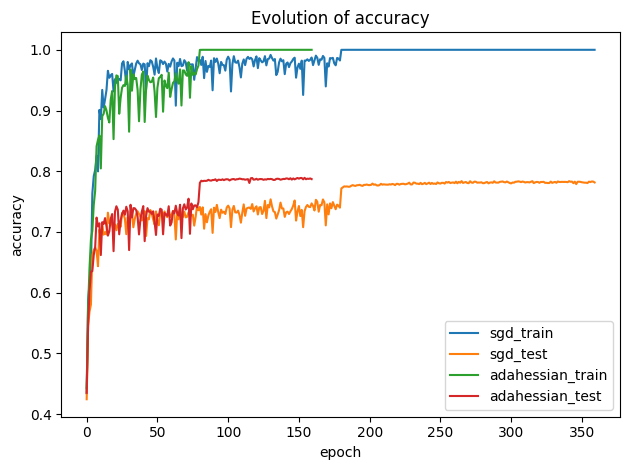

In [ ]:
plt.plot(sgd_train_acc)
plt.plot(sgd_test_acc)
plt.plot(adah_train_acc)
plt.plot(adah_test_acc)
plt.title(f"Evolution of accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.set(title=f"Evolution of accuracy",xlabel='epoch',ylabel='accuracy')
plt.legend(["sgd_train","sgd_test","adahessian_train","adahessian_test"])
plt.tight_layout()
plt.savefig("drive/MyDrive/Opti-ML/graphics/final_acc.pdf")
plt.show()

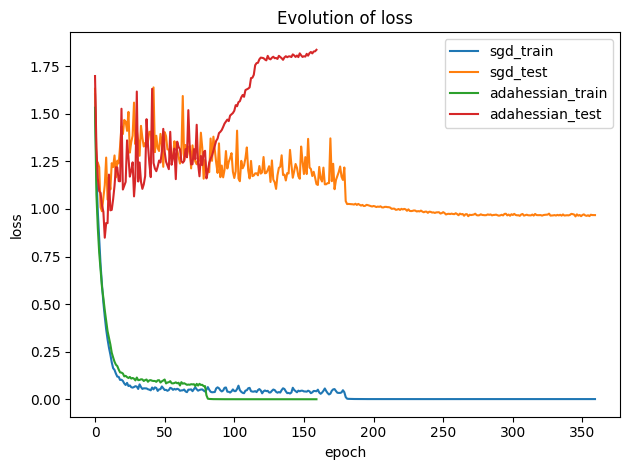

In [ ]:
plt.plot(sgd_train_loss)
plt.plot(sgd_test_loss)
plt.plot(adah_train_loss)
plt.plot(adah_test_loss)
plt.title(f"Evolution of loss")
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.set(title=f"Evolution of accuracy",xlabel='epoch',ylabel='accuracy')
plt.legend(["sgd_train","sgd_test","adahessian_train","adahessian_test"])
plt.tight_layout()
plt.savefig("drive/MyDrive/Opti-ML/graphics/final_loss.pdf")
plt.show()